In [1]:
import struct
import pandas as pd
import numpy as np
import os
from image_header import ImageHeader
import matplotlib.pyplot as plt

# Transform binary data to pd.DataFrame

In [19]:
struct_fmt = '=lldddddddddd' # int[5], float, byte[255]
struct_len = struct.calcsize(struct_fmt)
struct_unpack = struct.Struct(struct_fmt).unpack_from

struct_fmt2 = '=hhddddddddccccfhhhhh' # int[5], float, byte[255]
struct_len2 = struct.calcsize(struct_fmt2)
struct_unpack2 = struct.Struct(struct_fmt2).unpack_from

results = []
filename = 'outputADD.bin'
with open(filename, "rb") as f:
    while True:
        data1 = f.read(struct_len)
        if not data1:
            break
        s1 = struct_unpack(data1)
        # print(s1)
        for i in range(0, 97):
            data2 = f.read(struct_len2)
            if not data2:
                break
            s2 = struct_unpack2(data2) + s1
            results.append(s2)
f.close()
            

pnts = pd.DataFrame(results, columns=['row', 'col', 'x', 'y', 'z', 'norm_x', 'norm_y', 'norm_z',
                                      'alpha', 'radius', 'vis1', 'vis2', 'vis3', 'vis4', 'hrel',
                                      'R', 'G', 'B', 'N', 'P',
                                     'Serial', 'ImageCode', 'ViewZenith', 'SunAzimuth', 'SunElevation', 'AzimDiff',
                                     'SunVecX', 'SunVecY', 'SunVecZ', 'CamVecX', 'CamVecY', 'CamVecZ'])

# Transform visibilities to integers
pnts[['vis1', 'vis2', 'vis3', 'vis4']] = pnts[['vis1', 'vis2', 'vis3', 'vis4']].astype(int)
print(pnts.shape)

# Assign class to visibility
pnts['visibility'] = 'sunlit'
pnts.loc[(pnts['vis1'] == 1), 'visibility'] = 'self_shadowed'
pnts.loc[(pnts['vis2'] == 1), 'visibility'] = 'self_occluded'
pnts.loc[(pnts['vis3'] == 1), 'visibility'] = 'shadowed'
pnts.loc[(pnts['vis4'] == 1), 'visibility'] = 'occluded'


# Transform data
pnts['SunElevation'] = 90 - np.degrees(pnts['SunElevation'])
pnts['SunAzimuth'] = np.degrees(pnts['SunAzimuth'])

# Read tree-data and merge with point-data
young = pd.read_csv('/home/markus/Documents/Gradu2021/lisapuut.csv')
pnts = pd.merge(pnts, young, left_on='Serial', right_on='Serial')
pnts.loc[pnts['Luokka'] != 11, 'Plaji'] = 0
print(pnts.shape)

# Calculate additional angles to restrict used pixel values
pnts['AVX'] = np.cos(pnts['alpha'])
pnts['AVY'] = np.sin(pnts['alpha'])

pnts['NSUN2D'] = np.arccos((pnts['norm_x'] * pnts['SunVecX'] + pnts['norm_y'] * pnts['SunVecY'] + 0.000000001 * 0.000000001) /\
                           ((np.power(pnts['norm_x'] ** 2 + pnts['norm_y'] ** 2 + 0.000000001 ** 2, 0.5) * \
                     np.power(pnts['SunVecX'] ** 2 + pnts['SunVecY'] ** 2 + 0.000000001 ** 2, 0.5))))
pnts['NSUN2D'] = np.degrees(pnts['NSUN2D'])

pnts['NCAM3D'] = np.arccos((pnts['norm_x'] * pnts['CamVecX'] + pnts['norm_y'] * pnts['CamVecY'] + pnts['norm_z'] * pnts['CamVecZ']) /\
                 (np.power(pnts['CamVecX'] ** 2 + pnts['CamVecY'] ** 2 + pnts['CamVecZ'] ** 2, 0.5) * \
                 np.power(pnts['norm_x'] ** 2 + pnts['norm_y'] ** 2 + pnts['norm_z'] ** 2, 0.5)))
pnts['NCAM3D'] = np.degrees(pnts['NCAM3D'])



pnts = pnts[pnts['NCAM3D'] < 91]
mask = (((pnts['NSUN2D'] < 60) & (pnts['visibility'] == 'sunlit')) | ((pnts['NSUN2D'] > 120) & (pnts['visibility'] == 'self_shadowed')))
mask2 = (pnts['norm_z'] == 1.0)
pnts = pnts[mask | mask2]

pnts = pnts.drop_duplicates(subset=['Serial', 'ImageCode', 'row', 'col'])
pnts = pnts[pnts['ViewZenith'] < 20]

(4032581, 32)
(4032581, 44)


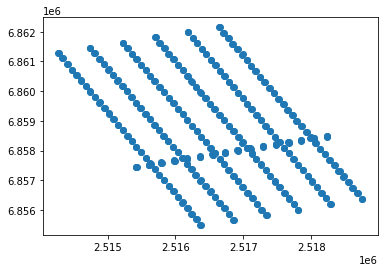

In [20]:
import time

def get_headers_in_dir(mydir: str) -> list:
    """
    Return header file paths in given directory (mydir)
    """
    ls = []
    for file in os.listdir(mydir):
        if file.endswith(".hdr"):
            ls.append(os.path.join(mydir, file))
    return ls

pan_headers = get_headers_in_dir('/media/markus/Ubuntu_Markus/Kuvat/Lvl2/PAN_HDR')
pan_headers[0]


res = []
for header_path in pan_headers:
    hdr1 = ImageHeader(header_path)
    hdr1.read_header()
    r = (hdr1.image_code, hdr1.x0, hdr1.y0)
    res.append(r)

imgc = pd.DataFrame(res, columns=['ImageCode', 'ImageX', 'ImageY'])
plt.scatter(imgc['ImageX'], imgc['ImageY'])

# Calculate image-pairs

In [21]:
triplets = pd.read_csv('triplets.csv')
imgc = pd.read_csv('image_pairs.csv') # 2 is with triplets
imgc.shape

(192, 6)

In [22]:
sun_vals = pd.read_csv('sun_elevation_azimuth_2012.csv')
sun_vals
res = []
xs = []
ys = []
if imgc is None:
    for header_path in pan_headers:

        hdr1 = ImageHeader(header_path)
        hdr1.read_header()

        image_filename = hdr1.get_filename()
        splitted_name = image_filename.split('/')
        image_num = splitted_name[-2]

        vals = sun_vals[sun_vals['image_number'] == int(image_num)]
        elev1 = np.radians(vals.iloc[0]['sun_elevation'])
        cl = 30
        for header_path2 in pan_headers:
            hdr2 = ImageHeader(header_path2)
            hdr2.read_header()

            image_filename = hdr2.get_filename()
            splitted_name = image_filename.split('/')
            image_num = splitted_name[-2]

            vals = sun_vals[sun_vals['image_number'] == int(image_num)]
            elev2 = np.radians(vals.iloc[0]['sun_elevation'])
            dist = np.sqrt((hdr2.x0-hdr1.x0)**2 + (hdr2.y0-hdr1.y0)**2)
            el = np.degrees(elev1) - np.degrees(elev2)
            if dist != 0 and dist < 30 and el < 5 and el > 0:
                if hdr1.image_code != hdr2.image_code:
                    r = (hdr1.image_code,
                             hdr2.image_code,
                             el, np.degrees(elev1),
                            np.degrees(elev2))
                    res.append(r)
                    xs.append(hdr2.x0)
                    ys.append(hdr2.y0)

    imgc = pd.DataFrame(res, columns=['ImageCode1', 'ImageCode2', 'ElevationDiff', 'Elevation1', 'Elevation2'])
    # imgc = imgc.drop_duplicates(subset=['ImageCode1', 'ImageCode2'])
    imgc.to_csv('image_pairs2.csv')

    plt.scatter(xs, ys)
imgc

Unnamed: 0  ImageCode1  ImageCode2  ElevationDiff  Elevation1  Elevation2
0             0      310368      310160       4.229555   37.345547   33.115992
1             1      310360      310152       4.231822   37.308239   33.076416
2             2      510428      510220       4.115184   38.489328   34.374144
3             3      210321      210113       4.302171   36.667089   32.364919
4             4      110298      110090       4.277106   36.124604   31.847498
..          ...         ...         ...            ...         ...         ...
187         187      610473      610265       4.048918   39.123107   35.074189
188         188      210324      210116       4.301015   36.678680   32.377665
189         189      310383      310175       4.227119   37.416791   33.189673
190         190      610458      610250       4.055713   39.062472   35.006759
191         191      510424      510216       4.119137   38.472218   34.353081

[192 rows x 6 columns]

# Calculate pair_id for pairs and for triplets calculate start_end_total

In [23]:
def h(d):
    """
    Function that calculate images pairs in locations of 5 m distance
    """
    d = d.iloc[0:3]
    d = d.sort_values(by=['Elevation1'], ascending=True)
    
    d['start_end_total'] = np.arange(1, d.shape[0]+1, 1)
    d['start_end_total'] = str(0) + '-' + d['start_end_total'].astype(str) + '-' +str(d.shape[0])
    
    dsh = d.shape[0]
    
    if d.shape[0] > 1:
        for i in range(0, d.shape[0] - 1):
            cod2 = d.iloc[i]['ImageCode1']
            cod1 = d.iloc[i+1]['ImageCode1']
            res = pd.DataFrame({
                'ImageCode1': cod1,
                'ImageCode2': cod2,
                'start_end_total': str(i+1) + '-' + str(i+2) + '-' + str(dsh),
                'Elevation1': d.iloc[i+1]['Elevation1'],
                'Elevation2': d.iloc[i]['Elevation1'],
            }, index=[0])
            d = d.append(res)
            
    d['ElevationDiff'] = d['Elevation1'] - d['Elevation2']
    d['pair_id'] = str(d.iloc[0]['ImageCode1']) + '-' 't'
    return d
    
tr = imgc.groupby('ImageCode2').apply(h)
tr.shape

(192, 8)

# Calculate mean values for each band for groups of Serial, ImageCode and visibility

In [24]:
res = pnts.groupby(['Serial', 'ImageCode', 'visibility'])[['B', 'G', 'R', 'N', 'P']].mean()
res['B'] = res['B']  - (77 + 67)
res['G'] = res['G'] - (76 + 50)
res['R'] = res['R'] - (47 + 38) 
res['N'] = res['N'] -  (214 + 40)
res['P'] = res['P'] - (60 + 47)

res_r = pnts.groupby(['Serial', 'ImageCode', 'visibility'])[['B', 'G', 'R', 'N', 'P']].mean()
res_r['B'] = -0.0000425049286896378 + 0.000163000081936 * (res_r['B']  - (77 + 67))
res_r['G'] = 0.001870326708756 + 0.000145135211975 * (res_r['G'] - (76 + 50))
res_r['R'] = 0.007979164620919 + 0.000122451943818 * (res_r['R'] - (47 + 38))
res_r['N'] = 0.007021768141202 + 0.000129384723333 * (res_r['N'] -  (214 + 40))
res_r['P'] = 0.006927989981104 + 0.000147029925454 * (res_r['P'] - (60 + 35))
res_r

B         G         R         N  \
Serial ImageCode visibility                                              
9001   210129    self_shadowed  0.009004  0.025491  0.031750  0.152235   
                 sunlit         0.002598  0.014062  0.020861  0.116637   
       210130    self_shadowed  0.010410  0.026761  0.029495  0.152925   
                 sunlit        -0.001897  0.006152  0.012219  0.070841   
       210131    self_shadowed  0.012631  0.029468  0.027216  0.171664   
...                                  ...       ...       ...       ...   
9923   710485    sunlit         0.022126  0.045353  0.040441  0.261483   
       710486    self_shadowed  0.015428  0.031082  0.029264  0.203798   
                 sunlit         0.020333  0.039693  0.033302  0.234053   
       710487    self_shadowed  0.013931  0.028542  0.028340  0.192801   
                 sunlit         0.016244  0.031732  0.031408  0.198630   

                                       P  
Serial ImageCode visibility               
9001   210129    self_shadowed  0.025301  
                 sunlit         0.014132  
       210130    self_shadowed  0.026360  
                 sunlit         0.014096  
       210131    self_shadowed  0.026843  
...                                  ...  
9923   710485    sunlit         0.047126  
       710486    self_shadowed  0.030740  
                 sunlit         0.043553  
       710487    self_shadowed  0.029778  
                 sunlit         0.033626  

[54232 rows x 5 columns]

# Calculating mean reflectances

In [25]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res_r.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res_r.loc[(i, row['ImageCode2'], 'sunlit'), :]
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = (vals1 + vals2) / 2
            
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res_r.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res_r.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            shadowb, shadowg, shadowr, shadown, shadowp = (vals1 + vals2) / 2
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            continue
            
reflectances = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

# CHA.to_csv("PAIRS/ADD/ABSOLUTE_CHANGES_BY_TREES_PAIRS_ADD.csv")

In [26]:
reflectance = reflectances.loc[reflectances['Species'] == 4, 'Species'] = 3
r_sp = reflectances.groupby('Species')['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP'].mean()
np.round(r_sp, 3)

/tmp/ipykernel_22568/415055877.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  r_sp = reflectances.groupby('Species')['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP'].mean()


SLB    SHB    SLG    SHG    SLR    SHR    SLN    SHN    SLP    SHP
Species                                                                      
0        0.026  0.016  0.042  0.028  0.048  0.033  0.132  0.108  0.049  0.032
1        0.022  0.014  0.043  0.028  0.038  0.028  0.237  0.176  0.044  0.029
2        0.016  0.008  0.036  0.020  0.033  0.021  0.212  0.141  0.039  0.022
3        0.024  0.014  0.047  0.030  0.043  0.029  0.312  0.226  0.047  0.030

# Calculate values for first image of pairs

In [27]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'sunlit'), :]
            diff = vals1 - vals2
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = vals2
            
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            diff = vals1 - vals2
            shadowb, shadowg, shadowr, shadown, shadowp = vals2
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            continue
            
pair_1 = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

# Calculate values for second image of pairs

In [28]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'sunlit'), :]
            diff = vals1 - vals2
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = vals1
            
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            diff = vals1 - vals2
            shadowb, shadowg, shadowr, shadown, shadowp = vals1
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            continue
            
pair_2 = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

In [29]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'sunlit'), :]
            diff = vals1 - vals2
            print(vals1.values)
            print(vals2.values)
            print(diff.values)
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = diff
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            diff = vals1 - vals2
            shadowb, shadowg, shadowr, shadown, shadowp = diff
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']

            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            print(e)
            continue
            
mean_diff = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

(9001, 110288, 'sunlit')
(9001, 110289, 'sunlit')
(9001, 110290, 'sunlit')
(9001, 110291, 'sunlit')
(9001, 110292, 'sunlit')
(9001, 110293, 'sunlit')
(9001, 110294, 'sunlit')
(9001, 110295, 'sunlit')
(9001, 110296, 'sunlit')
(9001, 110297, 'sunlit')
(9001, 110298, 'sunlit')
(9001, 110299, 'sunlit')
(9001, 110300, 'sunlit')
(9001, 110301, 'sunlit')
(9001, 110302, 'sunlit')
(9001, 110303, 'sunlit')
(9001, 110304, 'sunlit')
(9001, 110305, 'sunlit')
(9001, 110306, 'sunlit')
(9001, 110307, 'sunlit')
(9001, 110308, 'sunlit')
(9001, 110309, 'sunlit')
(9001, 110310, 'sunlit')
(9001, 110311, 'sunlit')
(9001, 110312, 'sunlit')
(9001, 110313, 'sunlit')
(9001, 110314, 'sunlit')
(9001, 110315, 'sunlit')
(9001, 110316, 'sunlit')
(9001, 110317, 'sunlit')
(9001, 110318, 'sunlit')
(9001, 110319, 'sunlit')
(9001, 210320, 'sunlit')
(9001, 210321, 'sunlit')
(9001, 210322, 'sunlit')
(9001, 210323, 'sunlit')
(9001, 210324, 'sunlit')
(9001, 210325, 'sunlit')
(9001, 210326, 'sunlit')
(9001, 210327, 'sunlit')


(9005, 110288, 'sunlit')
(9005, 110289, 'sunlit')
(9005, 110290, 'sunlit')
(9005, 110291, 'sunlit')
(9005, 110292, 'sunlit')
(9005, 110293, 'sunlit')
(9005, 110294, 'sunlit')
(9005, 110295, 'sunlit')
(9005, 110296, 'sunlit')
(9005, 110297, 'sunlit')
(9005, 110298, 'sunlit')
(9005, 110299, 'sunlit')
(9005, 110300, 'sunlit')
(9005, 110301, 'sunlit')
(9005, 110302, 'sunlit')
(9005, 110303, 'sunlit')
(9005, 110304, 'sunlit')
(9005, 110305, 'sunlit')
(9005, 110306, 'sunlit')
(9005, 110307, 'sunlit')
(9005, 110308, 'sunlit')
(9005, 110309, 'sunlit')
(9005, 110310, 'sunlit')
(9005, 110311, 'sunlit')
(9005, 110312, 'sunlit')
(9005, 110313, 'sunlit')
(9005, 110314, 'sunlit')
(9005, 110315, 'sunlit')
(9005, 110316, 'sunlit')
(9005, 110317, 'sunlit')
(9005, 110318, 'sunlit')
(9005, 110319, 'sunlit')
(9005, 210320, 'sunlit')
(9005, 210321, 'sunlit')
(9005, 210322, 'sunlit')
(9005, 210323, 'sunlit')
(9005, 210324, 'sunlit')
(9005, 210325, 'sunlit')
(9005, 210326, 'sunlit')
(9005, 210327, 'sunlit')


(9009, 110288, 'sunlit')
(9009, 110289, 'sunlit')
(9009, 110290, 'sunlit')
(9009, 110291, 'sunlit')
(9009, 110292, 'sunlit')
(9009, 110293, 'sunlit')
(9009, 110294, 'sunlit')
(9009, 110295, 'sunlit')
(9009, 110296, 'sunlit')
(9009, 110297, 'sunlit')
(9009, 110298, 'sunlit')
(9009, 110299, 'sunlit')
(9009, 110300, 'sunlit')
(9009, 110301, 'sunlit')
(9009, 110302, 'sunlit')
(9009, 110303, 'sunlit')
(9009, 110304, 'sunlit')
(9009, 110305, 'sunlit')
(9009, 110306, 'sunlit')
(9009, 110307, 'sunlit')
(9009, 110308, 'sunlit')
(9009, 110309, 'sunlit')
(9009, 110310, 'sunlit')
(9009, 110311, 'sunlit')
(9009, 110312, 'sunlit')
(9009, 110313, 'sunlit')
(9009, 110314, 'sunlit')
(9009, 110315, 'sunlit')
(9009, 110316, 'sunlit')
(9009, 110317, 'sunlit')
(9009, 110318, 'sunlit')
(9009, 110319, 'sunlit')
(9009, 210320, 'sunlit')
(9009, 210321, 'sunlit')
(9009, 210322, 'sunlit')
(9009, 210323, 'sunlit')
(9009, 210324, 'sunlit')
(9009, 210325, 'sunlit')
(9009, 210326, 'sunlit')
(9009, 210327, 'sunlit')


(9013, 110288, 'sunlit')
(9013, 110289, 'sunlit')
(9013, 110290, 'sunlit')
(9013, 110291, 'sunlit')
(9013, 110292, 'sunlit')
(9013, 110293, 'sunlit')
(9013, 110294, 'sunlit')
(9013, 110295, 'sunlit')
(9013, 110296, 'sunlit')
(9013, 110297, 'sunlit')
(9013, 110298, 'sunlit')
(9013, 110299, 'sunlit')
(9013, 110300, 'sunlit')
(9013, 110301, 'sunlit')
(9013, 110302, 'sunlit')
(9013, 110303, 'sunlit')
(9013, 110304, 'sunlit')
(9013, 110305, 'sunlit')
(9013, 110306, 'sunlit')
(9013, 110307, 'sunlit')
(9013, 110308, 'sunlit')
(9013, 110309, 'sunlit')
(9013, 110310, 'sunlit')
(9013, 110311, 'sunlit')
(9013, 110312, 'sunlit')
(9013, 110313, 'sunlit')
(9013, 110314, 'sunlit')
(9013, 110315, 'sunlit')
(9013, 110316, 'sunlit')
(9013, 110317, 'sunlit')
(9013, 110318, 'sunlit')
(9013, 110319, 'sunlit')
(9013, 210320, 'sunlit')
(9013, 210321, 'sunlit')
(9013, 210322, 'sunlit')
(9013, 210323, 'sunlit')
(9013, 210324, 'sunlit')
(9013, 210325, 'sunlit')
(9013, 210326, 'sunlit')
(9013, 210327, 'sunlit')


(9016, 610455, 'sunlit')
(9016, 610456, 'sunlit')
(9016, 610457, 'sunlit')
(9016, 610458, 'sunlit')
(9016, 610459, 'sunlit')
(9016, 610460, 'sunlit')
(9016, 610461, 'sunlit')
(9016, 610462, 'sunlit')
(9016, 610463, 'sunlit')
(9016, 610464, 'sunlit')
(9016, 610465, 'sunlit')
(9016, 610466, 'sunlit')
(9016, 610467, 'sunlit')
(9016, 610468, 'sunlit')
(9016, 610469, 'sunlit')
(9016, 610470, 'sunlit')
(9016, 610471, 'sunlit')
(9016, 610472, 'sunlit')
(9016, 610473, 'sunlit')
(9016, 610474, 'sunlit')
(9016, 610475, 'sunlit')
(9016, 610476, 'sunlit')
(9016, 610477, 'sunlit')
(9016, 610478, 'sunlit')
(9016, 610479, 'sunlit')
(9017, 110288, 'sunlit')
(9017, 110289, 'sunlit')
(9017, 110290, 'sunlit')
(9017, 110291, 'sunlit')
(9017, 110292, 'sunlit')
(9017, 110293, 'sunlit')
(9017, 110294, 'sunlit')
(9017, 110295, 'sunlit')
(9017, 110296, 'sunlit')
(9017, 110297, 'sunlit')
(9017, 110298, 'sunlit')
(9017, 110299, 'sunlit')
(9017, 110300, 'sunlit')
(9017, 110301, 'sunlit')
(9017, 110302, 'sunlit')


(9020, 310367, 'sunlit')
(9020, 310368, 'sunlit')
(9020, 310369, 'sunlit')
(9020, 310370, 'sunlit')
(9020, 310371, 'sunlit')
(9020, 310372, 'sunlit')
(9020, 310373, 'sunlit')
(9020, 310374, 'sunlit')
(9020, 310375, 'sunlit')
(9020, 310376, 'sunlit')
(9020, 310377, 'sunlit')
(9020, 310378, 'sunlit')
(9020, 310379, 'sunlit')
(9020, 310380, 'sunlit')
(9020, 310381, 'sunlit')
(9020, 310382, 'sunlit')
(9020, 310383, 'sunlit')
(9020, 410384, 'sunlit')
(9020, 410385, 'sunlit')
(9020, 410386, 'sunlit')
(9020, 410387, 'sunlit')
(9020, 410388, 'sunlit')
(9020, 410389, 'sunlit')
(9020, 410390, 'sunlit')
(9020, 410391, 'sunlit')
(9020, 410392, 'sunlit')
(9020, 410393, 'sunlit')
(9020, 410394, 'sunlit')
(9020, 410395, 'sunlit')
(9020, 410396, 'sunlit')
(9020, 410397, 'sunlit')
(9020, 410398, 'sunlit')
(9020, 410399, 'sunlit')
(9020, 410400, 'sunlit')
(9020, 410401, 'sunlit')
(9020, 410402, 'sunlit')
(9020, 410403, 'sunlit')
(9020, 410404, 'sunlit')
(9020, 410405, 'sunlit')
(9020, 410406, 'sunlit')


(9024, 410410, 'sunlit')
(9024, 410411, 'sunlit')
(9024, 410412, 'sunlit')
(9024, 410413, 'sunlit')
(9024, 410414, 'sunlit')
(9024, 410415, 'sunlit')
(9024, 510416, 'sunlit')
(9024, 510417, 'sunlit')
(9024, 510418, 'sunlit')
(9024, 510419, 'sunlit')
(9024, 510420, 'sunlit')
(9024, 510421, 'sunlit')
(9024, 510422, 'sunlit')
(9024, 510423, 'sunlit')
(9024, 510424, 'sunlit')
(9024, 510425, 'sunlit')
(9024, 510426, 'sunlit')
(9024, 510427, 'sunlit')
(9024, 510428, 'sunlit')
(9024, 510429, 'sunlit')
(9024, 510430, 'sunlit')
(9024, 510431, 'sunlit')
(9024, 510432, 'sunlit')
(9024, 510433, 'sunlit')
(9024, 510434, 'sunlit')
(9024, 510435, 'sunlit')
(9024, 510436, 'sunlit')
(9024, 510437, 'sunlit')
(9024, 510438, 'sunlit')
(9024, 510439, 'sunlit')
(9024, 510440, 'sunlit')
(9024, 510441, 'sunlit')
(9024, 510442, 'sunlit')
(9024, 510443, 'sunlit')
(9024, 510444, 'sunlit')
(9024, 510445, 'sunlit')
(9024, 510446, 'sunlit')
(9024, 510447, 'sunlit')
(9024, 610448, 'sunlit')
(9024, 610449, 'sunlit')


(9028, 410384, 'sunlit')
(9028, 410385, 'sunlit')
(9028, 410386, 'sunlit')
(9028, 410387, 'sunlit')
(9028, 410388, 'sunlit')
(9028, 410389, 'sunlit')
(9028, 410390, 'sunlit')
(9028, 410391, 'sunlit')
(9028, 410392, 'sunlit')
(9028, 410393, 'sunlit')
(9028, 410394, 'sunlit')
(9028, 410395, 'sunlit')
(9028, 410396, 'sunlit')
(9028, 410397, 'sunlit')
(9028, 410398, 'sunlit')
(9028, 410399, 'sunlit')
(9028, 410400, 'sunlit')
(9028, 410401, 'sunlit')
(9028, 410402, 'sunlit')
(9028, 410403, 'sunlit')
(9028, 410404, 'sunlit')
(9028, 410405, 'sunlit')
(9028, 410406, 'sunlit')
(9028, 410407, 'sunlit')
(9028, 410408, 'sunlit')
(9028, 410409, 'sunlit')
(9028, 410410, 'sunlit')
(9028, 410411, 'sunlit')
(9028, 410412, 'sunlit')
(9028, 410413, 'sunlit')
(9028, 410414, 'sunlit')
(9028, 410415, 'sunlit')
(9028, 510416, 'sunlit')
(9028, 510417, 'sunlit')
(9028, 510418, 'sunlit')
(9028, 510419, 'sunlit')
(9028, 510420, 'sunlit')
(9028, 510421, 'sunlit')
(9028, 510422, 'sunlit')
(9028, 510423, 'sunlit')


(9033, 110288, 'sunlit')
(9033, 110289, 'sunlit')
(9033, 110290, 'sunlit')
(9033, 110291, 'sunlit')
(9033, 110292, 'sunlit')
(9033, 110293, 'sunlit')
(9033, 110294, 'sunlit')
(9033, 110295, 'sunlit')
(9033, 110296, 'sunlit')
(9033, 110297, 'sunlit')
(9033, 110298, 'sunlit')
(9033, 110299, 'sunlit')
(9033, 110300, 'sunlit')
(9033, 110301, 'sunlit')
(9033, 110302, 'sunlit')
(9033, 110303, 'sunlit')
(9033, 110304, 'sunlit')
(9033, 110305, 'sunlit')
(9033, 110306, 'sunlit')
(9033, 110307, 'sunlit')
(9033, 110308, 'sunlit')
(9033, 110309, 'sunlit')
(9033, 110310, 'sunlit')
(9033, 110311, 'sunlit')
(9033, 110312, 'sunlit')
(9033, 110313, 'sunlit')
(9033, 110314, 'sunlit')
(9033, 110315, 'sunlit')
(9033, 110316, 'sunlit')
(9033, 110317, 'sunlit')
(9033, 110318, 'sunlit')
(9033, 110319, 'sunlit')
(9033, 210320, 'sunlit')
(9033, 210321, 'sunlit')
(9033, 210322, 'sunlit')
(9033, 210323, 'sunlit')
(9033, 210324, 'sunlit')
(9033, 210325, 'sunlit')
(9033, 210326, 'sunlit')
(9033, 210327, 'sunlit')


(9036, 410404, 'sunlit')
(9036, 410405, 'sunlit')
(9036, 410406, 'sunlit')
(9036, 410407, 'sunlit')
(9036, 410408, 'sunlit')
(9036, 410409, 'sunlit')
(9036, 410410, 'sunlit')
(9036, 410411, 'sunlit')
(9036, 410412, 'sunlit')
(9036, 410413, 'sunlit')
(9036, 410414, 'sunlit')
(9036, 410415, 'sunlit')
(9036, 510416, 'sunlit')
(9036, 510417, 'sunlit')
(9036, 510418, 'sunlit')
(9036, 510419, 'sunlit')
(9036, 510420, 'sunlit')
(9036, 510421, 'sunlit')
(9036, 510422, 'sunlit')
(9036, 510423, 'sunlit')
(9036, 510424, 'sunlit')
(9036, 510425, 'sunlit')
(9036, 510426, 'sunlit')
(9036, 510427, 'sunlit')
(9036, 510428, 'sunlit')
(9036, 510429, 'sunlit')
(9036, 510430, 'sunlit')
(9036, 510431, 'sunlit')
(9036, 510432, 'sunlit')
(9036, 510433, 'sunlit')
(9036, 510434, 'sunlit')
(9036, 510435, 'sunlit')
(9036, 510436, 'sunlit')
(9036, 510437, 'sunlit')
(9036, 510438, 'sunlit')
(9036, 510439, 'sunlit')
(9036, 510440, 'sunlit')
(9036, 510441, 'sunlit')
(9036, 510442, 'sunlit')
(9036, 510443, 'sunlit')


(9040, 510427, 'sunlit')
(9040, 510428, 'sunlit')
(9040, 510429, 'sunlit')
(9040, 510430, 'sunlit')
(9040, 510431, 'sunlit')
(9040, 510432, 'sunlit')
(9040, 510433, 'sunlit')
(9040, 510434, 'sunlit')
(9040, 510435, 'sunlit')
(9040, 510436, 'sunlit')
(9040, 510437, 'sunlit')
(9040, 510438, 'sunlit')
(9040, 510439, 'sunlit')
(9040, 510440, 'sunlit')
(9040, 510441, 'sunlit')
(9040, 510442, 'sunlit')
(9040, 510443, 'sunlit')
(9040, 510444, 'sunlit')
(9040, 510445, 'sunlit')
(9040, 510446, 'sunlit')
(9040, 510447, 'sunlit')
(9040, 610448, 'sunlit')
(9040, 610449, 'sunlit')
(9040, 610450, 'sunlit')
(9040, 610451, 'sunlit')
(9040, 610452, 'sunlit')
(9040, 610453, 'sunlit')
(9040, 610454, 'sunlit')
(9040, 610455, 'sunlit')
(9040, 610456, 'sunlit')
(9040, 610457, 'sunlit')
(9040, 610458, 'sunlit')
(9040, 610459, 'sunlit')
(9040, 610460, 'sunlit')
(9040, 610461, 'sunlit')
(9040, 610462, 'sunlit')
(9040, 610463, 'sunlit')
(9040, 610464, 'sunlit')
(9040, 610465, 'sunlit')
(9040, 610466, 'sunlit')


(9044, 510444, 'sunlit')
(9044, 510445, 'sunlit')
(9044, 510446, 'sunlit')
(9044, 510447, 'sunlit')
(9044, 610448, 'sunlit')
(9044, 610449, 'sunlit')
(9044, 610450, 'sunlit')
(9044, 610451, 'sunlit')
(9044, 610452, 'sunlit')
(9044, 610453, 'sunlit')
(9044, 610454, 'sunlit')
(9044, 610455, 'sunlit')
(9044, 610456, 'sunlit')
(9044, 610457, 'sunlit')
(9044, 610458, 'sunlit')
(9044, 610459, 'sunlit')
(9044, 610460, 'sunlit')
(9044, 610461, 'sunlit')
(9044, 610462, 'sunlit')
(9044, 610463, 'sunlit')
(9044, 610464, 'sunlit')
(9044, 610465, 'sunlit')
(9044, 610466, 'sunlit')
(9044, 610467, 'sunlit')
(9044, 610468, 'sunlit')
(9044, 610469, 'sunlit')
(9044, 610470, 'sunlit')
(9044, 610471, 'sunlit')
(9044, 610472, 'sunlit')
(9044, 610473, 'sunlit')
(9044, 610474, 'sunlit')
(9044, 610475, 'sunlit')
(9044, 610476, 'sunlit')
(9044, 610477, 'sunlit')
(9044, 610478, 'sunlit')
(9044, 610479, 'sunlit')
(9045, 110288, 'sunlit')
(9045, 110289, 'sunlit')
(9045, 110290, 'sunlit')
(9045, 110291, 'sunlit')


(9048, 510431, 'sunlit')
(9048, 510432, 'sunlit')
(9048, 510433, 'sunlit')
(9048, 510434, 'sunlit')
(9048, 510435, 'sunlit')
(9048, 510436, 'sunlit')
(9048, 510437, 'sunlit')
(9048, 510438, 'sunlit')
(9048, 510439, 'sunlit')
(9048, 510440, 'sunlit')
(9048, 510441, 'sunlit')
(9048, 510442, 'sunlit')
(9048, 510443, 'sunlit')
(9048, 510444, 'sunlit')
(9048, 510445, 'sunlit')
(9048, 510446, 'sunlit')
(9048, 510447, 'sunlit')
(9048, 610448, 'sunlit')
(9048, 610449, 'sunlit')
(9048, 610450, 'sunlit')
(9048, 610451, 'sunlit')
(9048, 610452, 'sunlit')
(9048, 610453, 'sunlit')
(9048, 610454, 'sunlit')
(9048, 610455, 'sunlit')
(9048, 610456, 'sunlit')
(9048, 610457, 'sunlit')
(9048, 610458, 'sunlit')
(9048, 610459, 'sunlit')
(9048, 610460, 'sunlit')
(9048, 610461, 'sunlit')
(9048, 610462, 'sunlit')
(9048, 610463, 'sunlit')
(9048, 610464, 'sunlit')
(9048, 610465, 'sunlit')
(9048, 610466, 'sunlit')
(9048, 610467, 'sunlit')
(9048, 610468, 'sunlit')
(9048, 610469, 'sunlit')
(9048, 610470, 'sunlit')


(9052, 410399, 'sunlit')
(9052, 410400, 'sunlit')
(9052, 410401, 'sunlit')
(9052, 410402, 'sunlit')
(9052, 410403, 'sunlit')
(9052, 410404, 'sunlit')
(9052, 410405, 'sunlit')
(9052, 410406, 'sunlit')
(9052, 410407, 'sunlit')
(9052, 410408, 'sunlit')
(9052, 410409, 'sunlit')
(9052, 410410, 'sunlit')
(9052, 410411, 'sunlit')
(9052, 410412, 'sunlit')
(9052, 410413, 'sunlit')
(9052, 410414, 'sunlit')
(9052, 410415, 'sunlit')
(9052, 510416, 'sunlit')
(9052, 510417, 'sunlit')
(9052, 510418, 'sunlit')
(9052, 510419, 'sunlit')
(9052, 510420, 'sunlit')
(9052, 510421, 'sunlit')
(9052, 510422, 'sunlit')
(9052, 510423, 'sunlit')
(9052, 510424, 'sunlit')
(9052, 510425, 'sunlit')
(9052, 510426, 'sunlit')
(9052, 510427, 'sunlit')
(9052, 510428, 'sunlit')
(9052, 510429, 'sunlit')
(9052, 510430, 'sunlit')
(9052, 510431, 'sunlit')
(9052, 510432, 'sunlit')
(9052, 510433, 'sunlit')
(9052, 510434, 'sunlit')
(9052, 510435, 'sunlit')
(9052, 510436, 'sunlit')
(9052, 510437, 'sunlit')
(9052, 510438, 'sunlit')


[ 214.05263158  454.05263158  400.         2208.36842105  349.52631579]
[ 202.5625  356.8125  329.9375 2120.5     300.    ]
[11.49013158 97.24013158 70.0625     87.86842105 49.52631579]
(9056, 210345, 'sunlit')
(9056, 210346, 'sunlit')
(9056, 210347, 'sunlit')
(9056, 210348, 'sunlit')
(9056, 210349, 'sunlit')
(9056, 210350, 'sunlit')
(9056, 210351, 'sunlit')
(9056, 310352, 'sunlit')
(9056, 310353, 'sunlit')
(9056, 310354, 'sunlit')
(9056, 310355, 'sunlit')
(9056, 310356, 'sunlit')
(9056, 310357, 'sunlit')
(9056, 310358, 'sunlit')
[ 265.9   501.05  498.65 2295.7   431.7 ]
[ 220.75        455.875       393.91666667 2273.375       374.45833333]
[ 45.15        45.175      104.73333333  22.325       57.24166667]
[ 230.38888889  464.          462.5        2353.27777778  392.16666667]
[ 204.85714286  388.52380952  350.85714286 2082.95238095  321.33333333]
[ 25.53174603  75.47619048 111.64285714 270.32539683  70.83333333]
[ 249.88235294  466.52941176  383.         2314.23529412  379.52941176]


(9059, 310371, 'sunlit')
(9059, 310372, 'sunlit')
(9059, 310373, 'sunlit')
(9059, 310374, 'sunlit')
(9059, 310375, 'sunlit')
(9059, 310376, 'sunlit')
(9059, 310377, 'sunlit')
(9059, 310378, 'sunlit')
(9059, 310379, 'sunlit')
(9059, 310380, 'sunlit')
(9059, 310381, 'sunlit')
(9059, 310382, 'sunlit')
(9059, 310383, 'sunlit')
(9059, 410384, 'sunlit')
(9059, 410385, 'sunlit')
(9059, 410386, 'sunlit')
(9059, 410387, 'sunlit')
(9059, 410388, 'sunlit')
(9059, 410389, 'sunlit')
(9059, 410390, 'sunlit')
(9059, 410391, 'sunlit')
(9059, 410392, 'sunlit')
(9059, 410393, 'sunlit')
(9059, 410394, 'sunlit')
(9059, 410395, 'sunlit')
(9059, 410396, 'sunlit')
(9059, 410397, 'sunlit')
(9059, 410398, 'sunlit')
(9059, 410399, 'sunlit')
(9059, 410400, 'sunlit')
(9059, 410401, 'sunlit')
(9059, 410402, 'sunlit')
(9059, 410403, 'sunlit')
(9059, 410404, 'sunlit')
(9059, 410405, 'sunlit')
(9059, 410406, 'sunlit')
(9059, 410407, 'sunlit')
(9059, 410408, 'sunlit')
(9059, 410409, 'sunlit')
(9059, 410410, 'sunlit')


(9062, 510426, 'sunlit')
(9062, 510427, 'sunlit')
(9062, 510428, 'sunlit')
(9062, 510429, 'sunlit')
(9062, 510430, 'sunlit')
(9062, 510431, 'sunlit')
(9062, 510432, 'sunlit')
(9062, 510433, 'sunlit')
(9062, 510434, 'sunlit')
(9062, 510435, 'sunlit')
(9062, 510436, 'sunlit')
(9062, 510437, 'sunlit')
(9062, 510438, 'sunlit')
(9062, 510439, 'sunlit')
(9062, 510440, 'sunlit')
(9062, 510441, 'sunlit')
(9062, 510442, 'sunlit')
(9062, 510443, 'sunlit')
(9062, 510444, 'sunlit')
(9062, 510445, 'sunlit')
(9062, 510446, 'sunlit')
(9062, 510447, 'sunlit')
(9062, 610448, 'sunlit')
(9062, 610449, 'sunlit')
(9062, 610450, 'sunlit')
(9062, 610451, 'sunlit')
(9062, 610452, 'sunlit')
(9062, 610453, 'sunlit')
(9062, 610454, 'sunlit')
(9062, 610455, 'sunlit')
(9062, 610456, 'sunlit')
(9062, 610457, 'sunlit')
(9062, 610458, 'sunlit')
(9062, 610459, 'sunlit')
(9062, 610460, 'sunlit')
(9062, 610461, 'sunlit')
(9062, 610462, 'sunlit')
(9062, 610463, 'sunlit')
(9062, 610464, 'sunlit')
(9062, 610465, 'sunlit')


(9066, 110295, 'sunlit')
(9066, 110296, 'sunlit')
(9066, 110297, 'sunlit')
(9066, 110298, 'sunlit')
(9066, 110299, 'sunlit')
(9066, 110300, 'sunlit')
(9066, 110301, 'sunlit')
(9066, 110302, 'sunlit')
(9066, 110303, 'sunlit')
(9066, 110304, 'sunlit')
(9066, 110305, 'sunlit')
(9066, 110306, 'sunlit')
(9066, 110307, 'sunlit')
(9066, 110308, 'sunlit')
(9066, 110309, 'sunlit')
(9066, 110310, 'sunlit')
(9066, 110311, 'sunlit')
(9066, 110312, 'sunlit')
(9066, 110313, 'sunlit')
(9066, 110314, 'sunlit')
(9066, 110315, 'sunlit')
(9066, 110316, 'sunlit')
(9066, 110317, 'sunlit')
(9066, 110318, 'sunlit')
(9066, 110319, 'sunlit')
(9066, 210320, 'sunlit')
(9066, 210321, 'sunlit')
(9066, 210322, 'sunlit')
(9066, 210323, 'sunlit')
(9066, 210324, 'sunlit')
(9066, 210325, 'sunlit')
(9066, 210326, 'sunlit')
(9066, 210327, 'sunlit')
(9066, 210328, 'sunlit')
(9066, 210329, 'sunlit')
(9066, 210330, 'sunlit')
(9066, 210331, 'sunlit')
(9066, 210332, 'sunlit')
(9066, 210333, 'sunlit')
(9066, 210334, 'sunlit')


(9069, 510446, 'sunlit')
(9069, 510447, 'sunlit')
(9069, 610448, 'sunlit')
(9069, 610449, 'sunlit')
(9069, 610450, 'sunlit')
(9069, 610451, 'sunlit')
(9069, 610452, 'sunlit')
(9069, 610453, 'sunlit')
(9069, 610454, 'sunlit')
(9069, 610455, 'sunlit')
(9069, 610456, 'sunlit')
(9069, 610457, 'sunlit')
(9069, 610458, 'sunlit')
(9069, 610459, 'sunlit')
(9069, 610460, 'sunlit')
(9069, 610461, 'sunlit')
(9069, 610462, 'sunlit')
(9069, 610463, 'sunlit')
(9069, 610464, 'sunlit')
(9069, 610465, 'sunlit')
(9069, 610466, 'sunlit')
(9069, 610467, 'sunlit')
(9069, 610468, 'sunlit')
(9069, 610469, 'sunlit')
(9069, 610470, 'sunlit')
(9069, 610471, 'sunlit')
(9069, 610472, 'sunlit')
(9069, 610473, 'sunlit')
(9069, 610474, 'sunlit')
(9069, 610475, 'sunlit')
(9069, 610476, 'sunlit')
(9069, 610477, 'sunlit')
(9069, 610478, 'sunlit')
(9069, 610479, 'sunlit')
(9070, 110288, 'sunlit')
(9070, 110289, 'sunlit')
(9070, 110290, 'sunlit')
(9070, 110291, 'sunlit')
(9070, 110292, 'sunlit')
(9070, 110293, 'sunlit')


(9073, 610479, 'sunlit')
(9074, 110288, 'sunlit')
(9074, 110289, 'sunlit')
(9074, 110290, 'sunlit')
(9074, 110291, 'sunlit')
(9074, 110292, 'sunlit')
(9074, 110293, 'sunlit')
(9074, 110294, 'sunlit')
(9074, 110295, 'sunlit')
(9074, 110296, 'sunlit')
(9074, 110297, 'sunlit')
(9074, 110298, 'sunlit')
(9074, 110299, 'sunlit')
(9074, 110300, 'sunlit')
(9074, 110301, 'sunlit')
(9074, 110302, 'sunlit')
(9074, 110303, 'sunlit')
(9074, 110304, 'sunlit')
(9074, 110305, 'sunlit')
(9074, 110306, 'sunlit')
(9074, 110307, 'sunlit')
(9074, 110308, 'sunlit')
(9074, 110309, 'sunlit')
(9074, 110310, 'sunlit')
(9074, 110311, 'sunlit')
(9074, 110312, 'sunlit')
(9074, 110313, 'sunlit')
(9074, 110314, 'sunlit')
(9074, 110315, 'sunlit')
(9074, 110316, 'sunlit')
(9074, 110317, 'sunlit')
(9074, 110318, 'sunlit')
(9074, 110319, 'sunlit')
(9074, 210320, 'sunlit')
(9074, 210321, 'sunlit')
(9074, 210322, 'sunlit')
(9074, 210323, 'sunlit')
(9074, 210324, 'sunlit')
(9074, 210325, 'sunlit')
(9074, 210326, 'sunlit')


(9076, 310369, 'sunlit')
(9076, 310370, 'sunlit')
(9076, 310371, 'sunlit')
(9076, 310372, 'sunlit')
(9076, 310373, 'sunlit')
(9076, 310374, 'sunlit')
(9076, 310375, 'sunlit')
(9076, 310376, 'sunlit')
(9076, 310377, 'sunlit')
(9076, 310378, 'sunlit')
(9076, 310379, 'sunlit')
(9076, 310380, 'sunlit')
(9076, 310381, 'sunlit')
(9076, 310382, 'sunlit')
(9076, 310383, 'sunlit')
(9076, 410384, 'sunlit')
(9076, 410385, 'sunlit')
(9076, 410386, 'sunlit')
(9076, 410387, 'sunlit')
(9076, 410388, 'sunlit')
(9076, 410389, 'sunlit')
(9076, 410390, 'sunlit')
(9076, 410391, 'sunlit')
(9076, 410392, 'sunlit')
(9076, 410393, 'sunlit')
(9076, 410394, 'sunlit')
(9076, 410395, 'sunlit')
(9076, 410396, 'sunlit')
(9076, 410397, 'sunlit')
(9076, 410398, 'sunlit')
(9076, 410399, 'sunlit')
(9076, 410400, 'sunlit')
(9076, 410401, 'sunlit')
(9076, 410402, 'sunlit')
(9076, 410403, 'sunlit')
(9076, 410404, 'sunlit')
(9076, 410405, 'sunlit')
(9076, 410406, 'sunlit')
(9076, 410407, 'sunlit')
(9076, 410408, 'sunlit')


[ 179.88888889  357.44444444  316.05555556 1738.72222222  281.61111111]
[ 150.2173913   302.13043478  269.47826087 1587.26086957  246.95652174]
[ 29.67149758  55.31400966  46.57729469 151.46135266  34.65458937]
[ 140.85714286  322.71428571  291.07142857 1643.28571429  250.57142857]
[ 142.2   290.35  318.1  1484.    217.35]
[ -1.34285714  32.36428571 -27.02857143 159.28571429  33.22142857]
(9080, 310364, 'sunlit')
(9080, 310365, 'sunlit')
(9080, 310366, 'sunlit')
(9080, 310367, 'sunlit')
(9080, 310368, 'sunlit')
(9080, 310369, 'sunlit')
(9080, 310370, 'sunlit')
(9080, 310371, 'sunlit')
(9080, 310372, 'sunlit')
(9080, 310373, 'sunlit')
(9080, 310374, 'sunlit')
(9080, 310375, 'sunlit')
(9080, 310376, 'sunlit')
(9080, 310377, 'sunlit')
(9080, 310378, 'sunlit')
(9080, 310379, 'sunlit')
(9080, 310380, 'sunlit')
(9080, 310381, 'sunlit')
(9080, 310382, 'sunlit')
(9080, 310383, 'sunlit')
(9080, 410384, 'sunlit')
(9080, 410385, 'sunlit')
(9080, 410386, 'sunlit')
(9080, 410387, 'sunlit')
(9080, 4

(9084, 410405, 'sunlit')
(9084, 410406, 'sunlit')
(9084, 410407, 'sunlit')
(9084, 410408, 'sunlit')
(9084, 410409, 'sunlit')
(9084, 410410, 'sunlit')
(9084, 410411, 'sunlit')
(9084, 410412, 'sunlit')
(9084, 410413, 'sunlit')
(9084, 410414, 'sunlit')
(9084, 410415, 'sunlit')
(9084, 510416, 'sunlit')
(9084, 510417, 'sunlit')
(9084, 510418, 'sunlit')
(9084, 510419, 'sunlit')
(9084, 510420, 'sunlit')
(9084, 510421, 'sunlit')
(9084, 510422, 'sunlit')
(9084, 510423, 'sunlit')
(9084, 510424, 'sunlit')
(9084, 510425, 'sunlit')
(9084, 510426, 'sunlit')
(9084, 510427, 'sunlit')
(9084, 510428, 'sunlit')
(9084, 510429, 'sunlit')
(9084, 510430, 'sunlit')
(9084, 510431, 'sunlit')
(9084, 510432, 'sunlit')
(9084, 510433, 'sunlit')
(9084, 510434, 'sunlit')
(9084, 510435, 'sunlit')
(9084, 510436, 'sunlit')
(9084, 510437, 'sunlit')
(9084, 510438, 'sunlit')
(9084, 510439, 'sunlit')
(9084, 510440, 'sunlit')
(9084, 510441, 'sunlit')
(9084, 510442, 'sunlit')
(9084, 510443, 'sunlit')
(9084, 510444, 'sunlit')


(9088, 410413, 'sunlit')
(9088, 410414, 'sunlit')
(9088, 410415, 'sunlit')
(9088, 510416, 'sunlit')
(9088, 510417, 'sunlit')
(9088, 510418, 'sunlit')
(9088, 510419, 'sunlit')
(9088, 510420, 'sunlit')
(9088, 510421, 'sunlit')
(9088, 510422, 'sunlit')
(9088, 510423, 'sunlit')
(9088, 510424, 'sunlit')
(9088, 510425, 'sunlit')
(9088, 510426, 'sunlit')
(9088, 510427, 'sunlit')
(9088, 510428, 'sunlit')
(9088, 510429, 'sunlit')
(9088, 510430, 'sunlit')
(9088, 510431, 'sunlit')
(9088, 510432, 'sunlit')
(9088, 510433, 'sunlit')
(9088, 510434, 'sunlit')
(9088, 510435, 'sunlit')
(9088, 510436, 'sunlit')
(9088, 510437, 'sunlit')
(9088, 510438, 'sunlit')
(9088, 510439, 'sunlit')
(9088, 510440, 'sunlit')
(9088, 510441, 'sunlit')
(9088, 510442, 'sunlit')
(9088, 510443, 'sunlit')
(9088, 510444, 'sunlit')
(9088, 510445, 'sunlit')
(9088, 510446, 'sunlit')
(9088, 510447, 'sunlit')
(9088, 610448, 'sunlit')
(9088, 610449, 'sunlit')
(9088, 610450, 'sunlit')
(9088, 610451, 'sunlit')
(9088, 610452, 'sunlit')


(9093, 110288, 'sunlit')
(9093, 110289, 'sunlit')
(9093, 110290, 'sunlit')
(9093, 110291, 'sunlit')
(9093, 110292, 'sunlit')
(9093, 110293, 'sunlit')
(9093, 110294, 'sunlit')
(9093, 110295, 'sunlit')
(9093, 110296, 'sunlit')
(9093, 110297, 'sunlit')
(9093, 110298, 'sunlit')
(9093, 110299, 'sunlit')
(9093, 110300, 'sunlit')
(9093, 110301, 'sunlit')
(9093, 110302, 'sunlit')
(9093, 110303, 'sunlit')
(9093, 110304, 'sunlit')
(9093, 110305, 'sunlit')
(9093, 110306, 'sunlit')
(9093, 110307, 'sunlit')
(9093, 110308, 'sunlit')
(9093, 110309, 'sunlit')
(9093, 110310, 'sunlit')
(9093, 110311, 'sunlit')
(9093, 110312, 'sunlit')
(9093, 110313, 'sunlit')
(9093, 110314, 'sunlit')
(9093, 110315, 'sunlit')
(9093, 110316, 'sunlit')
(9093, 110317, 'sunlit')
(9093, 110318, 'sunlit')
(9093, 110319, 'sunlit')
(9093, 210320, 'sunlit')
(9093, 210321, 'sunlit')
(9093, 210322, 'sunlit')
(9093, 210323, 'sunlit')
(9093, 210324, 'sunlit')
(9093, 210325, 'sunlit')
(9093, 210326, 'sunlit')
(9093, 210327, 'sunlit')


(9097, 110288, 'sunlit')
(9097, 110289, 'sunlit')
(9097, 110290, 'sunlit')
(9097, 110291, 'sunlit')
(9097, 110292, 'sunlit')
(9097, 110293, 'sunlit')
(9097, 110294, 'sunlit')
(9097, 110295, 'sunlit')
(9097, 110296, 'sunlit')
(9097, 110297, 'sunlit')
(9097, 110298, 'sunlit')
(9097, 110299, 'sunlit')
(9097, 110300, 'sunlit')
(9097, 110301, 'sunlit')
(9097, 110302, 'sunlit')
(9097, 110303, 'sunlit')
(9097, 110304, 'sunlit')
(9097, 110305, 'sunlit')
(9097, 110306, 'sunlit')
(9097, 110307, 'sunlit')
(9097, 110308, 'sunlit')
(9097, 110309, 'sunlit')
(9097, 110310, 'sunlit')
(9097, 110311, 'sunlit')
(9097, 110312, 'sunlit')
(9097, 110313, 'sunlit')
(9097, 110314, 'sunlit')
(9097, 110315, 'sunlit')
(9097, 110316, 'sunlit')
(9097, 110317, 'sunlit')
(9097, 110318, 'sunlit')
(9097, 110319, 'sunlit')
(9097, 210320, 'sunlit')
(9097, 210321, 'sunlit')
(9097, 210322, 'sunlit')
(9097, 210323, 'sunlit')
(9097, 210324, 'sunlit')
(9097, 210325, 'sunlit')
(9097, 210326, 'sunlit')
(9097, 210327, 'sunlit')


(9101, 110288, 'sunlit')
(9101, 110289, 'sunlit')
(9101, 110290, 'sunlit')
(9101, 110291, 'sunlit')
(9101, 110292, 'sunlit')
(9101, 110293, 'sunlit')
(9101, 110294, 'sunlit')
(9101, 110295, 'sunlit')
(9101, 110296, 'sunlit')
(9101, 110297, 'sunlit')
(9101, 110298, 'sunlit')
(9101, 110299, 'sunlit')
(9101, 110300, 'sunlit')
(9101, 110301, 'sunlit')
(9101, 110302, 'sunlit')
(9101, 110303, 'sunlit')
(9101, 110304, 'sunlit')
(9101, 110305, 'sunlit')
(9101, 110306, 'sunlit')
(9101, 110307, 'sunlit')
(9101, 110308, 'sunlit')
(9101, 110309, 'sunlit')
(9101, 110310, 'sunlit')
(9101, 110311, 'sunlit')
(9101, 110312, 'sunlit')
(9101, 110313, 'sunlit')
(9101, 110314, 'sunlit')
(9101, 110315, 'sunlit')
(9101, 110316, 'sunlit')
(9101, 110317, 'sunlit')
(9101, 110318, 'sunlit')
(9101, 110319, 'sunlit')
(9101, 210320, 'sunlit')
(9101, 210321, 'sunlit')
(9101, 210322, 'sunlit')
(9101, 210323, 'sunlit')
(9101, 210324, 'sunlit')
(9101, 210325, 'sunlit')
(9101, 210326, 'sunlit')
(9101, 210327, 'sunlit')


(9105, 210321, 'sunlit')
(9105, 210322, 'sunlit')
(9105, 210323, 'sunlit')
(9105, 210324, 'sunlit')
(9105, 210325, 'sunlit')
(9105, 210326, 'sunlit')
(9105, 210327, 'sunlit')
(9105, 210328, 'sunlit')
(9105, 210329, 'sunlit')
(9105, 210330, 'sunlit')
(9105, 210331, 'sunlit')
(9105, 210332, 'sunlit')
(9105, 210333, 'sunlit')
(9105, 210334, 'sunlit')
(9105, 210335, 'sunlit')
(9105, 210336, 'sunlit')
(9105, 210337, 'sunlit')
(9105, 210338, 'sunlit')
(9105, 210339, 'sunlit')
[134.33333333 253.66666667 313.33333333 970.33333333 299.33333333]
[107.5 176.5 281.5 783.  212. ]
[ 26.83333333  77.16666667  31.83333333 187.33333333  87.33333333]
[100.    165.875 212.625 778.125 152.125]
[ 36.   88.4 158.4 582.6  99.4]
[ 64.     77.475  54.225 195.525  52.725]
[103.35714286 175.21428571 264.35714286 928.         207.92857143]
[ 45.71428571 108.85714286 171.         659.85714286 108.71428571]
[ 57.64285714  66.35714286  93.35714286 268.14285714  99.21428571]
(9105, 210343, 'sunlit')
(9105, 210344, 's

(9109, 110288, 'sunlit')
(9109, 110289, 'sunlit')
(9109, 110290, 'sunlit')
(9109, 110291, 'sunlit')
(9109, 110292, 'sunlit')
(9109, 110293, 'sunlit')
(9109, 110294, 'sunlit')
(9109, 110295, 'sunlit')
(9109, 110296, 'sunlit')
(9109, 110297, 'sunlit')
(9109, 110298, 'sunlit')
(9109, 110299, 'sunlit')
(9109, 110300, 'sunlit')
(9109, 110301, 'sunlit')
(9109, 110302, 'sunlit')
(9109, 110303, 'sunlit')
(9109, 110304, 'sunlit')
(9109, 110305, 'sunlit')
(9109, 110306, 'sunlit')
(9109, 110307, 'sunlit')
(9109, 110308, 'sunlit')
(9109, 110309, 'sunlit')
(9109, 110310, 'sunlit')
(9109, 110311, 'sunlit')
(9109, 110312, 'sunlit')
(9109, 110313, 'sunlit')
(9109, 110314, 'sunlit')
(9109, 110315, 'sunlit')
(9109, 110316, 'sunlit')
(9109, 110317, 'sunlit')
(9109, 110318, 'sunlit')
(9109, 110319, 'sunlit')
(9109, 210320, 'sunlit')
(9109, 210321, 'sunlit')
(9109, 210322, 'sunlit')
(9109, 210323, 'sunlit')
(9109, 210324, 'sunlit')
(9109, 210325, 'sunlit')
(9109, 210326, 'sunlit')
(9109, 210327, 'sunlit')


(9112, 510416, 'sunlit')
(9112, 510417, 'sunlit')
(9112, 510418, 'sunlit')
(9112, 510419, 'sunlit')
(9112, 510420, 'sunlit')
(9112, 510421, 'sunlit')
(9112, 510422, 'sunlit')
(9112, 510423, 'sunlit')
(9112, 510424, 'sunlit')
(9112, 510425, 'sunlit')
(9112, 510426, 'sunlit')
(9112, 510427, 'sunlit')
(9112, 510428, 'sunlit')
(9112, 510429, 'sunlit')
(9112, 510430, 'sunlit')
(9112, 510431, 'sunlit')
(9112, 510432, 'sunlit')
(9112, 510433, 'sunlit')
(9112, 510434, 'sunlit')
(9112, 510435, 'sunlit')
(9112, 510436, 'sunlit')
(9112, 510437, 'sunlit')
(9112, 510438, 'sunlit')
(9112, 510439, 'sunlit')
(9112, 510440, 'sunlit')
(9112, 510441, 'sunlit')
(9112, 510442, 'sunlit')
(9112, 510443, 'sunlit')
(9112, 510444, 'sunlit')
(9112, 510445, 'sunlit')
(9112, 510446, 'sunlit')
(9112, 510447, 'sunlit')
(9112, 610448, 'sunlit')
(9112, 610449, 'sunlit')
(9112, 610450, 'sunlit')
(9112, 610451, 'sunlit')
(9112, 610452, 'sunlit')
(9112, 610453, 'sunlit')
(9112, 610454, 'sunlit')
(9112, 610455, 'sunlit')


(9116, 510446, 'sunlit')
(9116, 510447, 'sunlit')
(9116, 610448, 'sunlit')
(9116, 610449, 'sunlit')
(9116, 610450, 'sunlit')
(9116, 610451, 'sunlit')
(9116, 610452, 'sunlit')
(9116, 610453, 'sunlit')
(9116, 610454, 'sunlit')
(9116, 610455, 'sunlit')
(9116, 610456, 'sunlit')
(9116, 610457, 'sunlit')
(9116, 610458, 'sunlit')
(9116, 610459, 'sunlit')
(9116, 610460, 'sunlit')
(9116, 610461, 'sunlit')
(9116, 610462, 'sunlit')
(9116, 610463, 'sunlit')
(9116, 610464, 'sunlit')
(9116, 610465, 'sunlit')
(9116, 610466, 'sunlit')
(9116, 610467, 'sunlit')
(9116, 610468, 'sunlit')
(9116, 610469, 'sunlit')
(9116, 610470, 'sunlit')
(9116, 610471, 'sunlit')
(9116, 610472, 'sunlit')
(9116, 610473, 'sunlit')
(9116, 610474, 'sunlit')
(9116, 610475, 'sunlit')
(9116, 610476, 'sunlit')
(9116, 610477, 'sunlit')
(9116, 610478, 'sunlit')
(9116, 610479, 'sunlit')
(9117, 110288, 'sunlit')
(9117, 110289, 'sunlit')
(9117, 110290, 'sunlit')
(9117, 110291, 'sunlit')
(9117, 110292, 'sunlit')
(9117, 110293, 'sunlit')


(9120, 610474, 'sunlit')
(9120, 610475, 'sunlit')
(9120, 610476, 'sunlit')
(9120, 610477, 'sunlit')
(9120, 610478, 'sunlit')
(9120, 610479, 'sunlit')
(9121, 110288, 'sunlit')
(9121, 110289, 'sunlit')
(9121, 110290, 'sunlit')
(9121, 110291, 'sunlit')
(9121, 110292, 'sunlit')
(9121, 110293, 'sunlit')
(9121, 110294, 'sunlit')
(9121, 110295, 'sunlit')
(9121, 110296, 'sunlit')
(9121, 110297, 'sunlit')
(9121, 110298, 'sunlit')
(9121, 110299, 'sunlit')
(9121, 110300, 'sunlit')
(9121, 110301, 'sunlit')
(9121, 110302, 'sunlit')
(9121, 110303, 'sunlit')
(9121, 110304, 'sunlit')
(9121, 110305, 'sunlit')
(9121, 110306, 'sunlit')
(9121, 110307, 'sunlit')
(9121, 110308, 'sunlit')
(9121, 110309, 'sunlit')
(9121, 110310, 'sunlit')
(9121, 110311, 'sunlit')
(9121, 110312, 'sunlit')
(9121, 110313, 'sunlit')
(9121, 110314, 'sunlit')
(9121, 110315, 'sunlit')
(9121, 110316, 'sunlit')
(9121, 110317, 'sunlit')
(9121, 110318, 'sunlit')
(9121, 110319, 'sunlit')
(9121, 210320, 'sunlit')
(9121, 210321, 'sunlit')


(9124, 410415, 'sunlit')
(9124, 510416, 'sunlit')
(9124, 510417, 'sunlit')
(9124, 510418, 'sunlit')
(9124, 510419, 'sunlit')
(9124, 510420, 'sunlit')
(9124, 510421, 'sunlit')
(9124, 510422, 'sunlit')
(9124, 510423, 'sunlit')
(9124, 510424, 'sunlit')
(9124, 510425, 'sunlit')
(9124, 510426, 'sunlit')
(9124, 510427, 'sunlit')
(9124, 510428, 'sunlit')
(9124, 510429, 'sunlit')
(9124, 510430, 'sunlit')
(9124, 510431, 'sunlit')
(9124, 510432, 'sunlit')
(9124, 510433, 'sunlit')
(9124, 510434, 'sunlit')
(9124, 510435, 'sunlit')
(9124, 510436, 'sunlit')
(9124, 510437, 'sunlit')
(9124, 510438, 'sunlit')
(9124, 510439, 'sunlit')
(9124, 510440, 'sunlit')
(9124, 510441, 'sunlit')
(9124, 510442, 'sunlit')
(9124, 510443, 'sunlit')
(9124, 510444, 'sunlit')
(9124, 510445, 'sunlit')
(9124, 510446, 'sunlit')
(9124, 510447, 'sunlit')
(9124, 610448, 'sunlit')
(9124, 610449, 'sunlit')
(9124, 610450, 'sunlit')
(9124, 610451, 'sunlit')
(9124, 610452, 'sunlit')
(9124, 610453, 'sunlit')
(9124, 610454, 'sunlit')


(9128, 410398, 'sunlit')
(9128, 410399, 'sunlit')
(9128, 410400, 'sunlit')
(9128, 410401, 'sunlit')
(9128, 410402, 'sunlit')
(9128, 410403, 'sunlit')
[ 264.5         442.66666667  543.22222222 1353.          461.33333333]
[ 255.71428571  399.23809524  510.95238095 1453.14285714  437.66666667]
[   8.78571429   43.42857143   32.26984127 -100.14285714   23.66666667]
[ 308.65384615  537.19230769  700.26923077 1397.5         464.03846154]
[ 292.33333333  512.04166667  714.125      1424.70833333  462.20833333]
[ 16.32051282  25.15064103 -13.85576923 -27.20833333   1.83012821]
(9128, 410406, 'sunlit')
(9128, 410407, 'sunlit')
(9128, 410408, 'sunlit')
(9128, 410409, 'sunlit')
(9128, 410410, 'sunlit')
(9128, 410411, 'sunlit')
(9128, 410412, 'sunlit')
(9128, 410413, 'sunlit')
(9128, 410414, 'sunlit')
(9128, 410415, 'sunlit')
(9128, 510416, 'sunlit')
(9128, 510417, 'sunlit')
(9128, 510418, 'sunlit')
(9128, 510419, 'sunlit')
(9128, 510420, 'sunlit')
(9128, 510421, 'sunlit')
(9128, 510422, 'sunlit'

(9132, 410408, 'sunlit')
(9132, 410409, 'sunlit')
(9132, 410410, 'sunlit')
(9132, 410411, 'sunlit')
(9132, 410412, 'sunlit')
(9132, 410413, 'sunlit')
(9132, 410414, 'sunlit')
(9132, 410415, 'sunlit')
(9132, 510416, 'sunlit')
(9132, 510417, 'sunlit')
(9132, 510418, 'sunlit')
(9132, 510419, 'sunlit')
(9132, 510420, 'sunlit')
(9132, 510421, 'sunlit')
(9132, 510422, 'sunlit')
(9132, 510423, 'sunlit')
(9132, 510424, 'sunlit')
(9132, 510425, 'sunlit')
(9132, 510426, 'sunlit')
(9132, 510427, 'sunlit')
(9132, 510428, 'sunlit')
(9132, 510429, 'sunlit')
(9132, 510430, 'sunlit')
(9132, 510431, 'sunlit')
(9132, 510432, 'sunlit')
(9132, 510433, 'sunlit')
(9132, 510434, 'sunlit')
(9132, 510435, 'sunlit')
(9132, 510436, 'sunlit')
(9132, 510437, 'sunlit')
(9132, 510438, 'sunlit')
(9132, 510439, 'sunlit')
(9132, 510440, 'sunlit')
(9132, 510441, 'sunlit')
(9132, 510442, 'sunlit')
(9132, 510443, 'sunlit')
(9132, 510444, 'sunlit')
(9132, 510445, 'sunlit')
(9132, 510446, 'sunlit')
(9132, 510447, 'sunlit')


(9136, 310360, 'sunlit')
[ 229.11538462  425.80769231  346.46153846 3044.57692308  376.42307692]
[ 184.96  378.28  378.28 3061.04  333.6 ]
[ 44.15538462  47.52769231 -31.81846154 -16.46307692  42.82307692]
[ 221.40909091  409.45454545  347.81818182 3046.04545455  351.18181818]
[ 203.2173913   392.86956522  327.13043478 3119.69565217  337.04347826]
[ 18.1916996   16.58498024  20.68774704 -73.65019763  14.13833992]
[ 181.23529412  407.64705882  342.58823529 3087.70588235  331.88235294]
[ 206.1   412.1   399.85 3135.7   341.75]
[-24.86470588  -4.45294118 -57.26176471 -47.99411765  -9.86764706]
[ 200.6         424.          384.93333333 3083.2         348.86666667]
[ 197.68421053  406.94736842  334.21052632 3255.68421053  335.42105263]
[   2.91578947   17.05263158   50.72280702 -172.48421053   13.44561404]
[ 182.3  416.2  408.7 2997.9  318.9]
[ 184.33333333  394.          348.91666667 3120.58333333  314.83333333]
[  -2.03333333   22.2          59.78333333 -122.68333333    4.06666667]
(9136

(9141, 110288, 'sunlit')
(9141, 110289, 'sunlit')
(9141, 110290, 'sunlit')
(9141, 110291, 'sunlit')
(9141, 110292, 'sunlit')
(9141, 110293, 'sunlit')
(9141, 110294, 'sunlit')
(9141, 110295, 'sunlit')
(9141, 110296, 'sunlit')
(9141, 110297, 'sunlit')
(9141, 110298, 'sunlit')
(9141, 110299, 'sunlit')
(9141, 110300, 'sunlit')
(9141, 110301, 'sunlit')
(9141, 110302, 'sunlit')
(9141, 110303, 'sunlit')
(9141, 110304, 'sunlit')
(9141, 110305, 'sunlit')
(9141, 110306, 'sunlit')
(9141, 110307, 'sunlit')
(9141, 110308, 'sunlit')
(9141, 110309, 'sunlit')
(9141, 110310, 'sunlit')
(9141, 110311, 'sunlit')
(9141, 110312, 'sunlit')
(9141, 110313, 'sunlit')
(9141, 110314, 'sunlit')
(9141, 110315, 'sunlit')
(9141, 110316, 'sunlit')
(9141, 110317, 'sunlit')
(9141, 110318, 'sunlit')
(9141, 110319, 'sunlit')
(9141, 210320, 'sunlit')
(9141, 210321, 'sunlit')
(9141, 210322, 'sunlit')
(9141, 210323, 'sunlit')
(9141, 210324, 'sunlit')
(9141, 210325, 'sunlit')
(9141, 210326, 'sunlit')
(9141, 210327, 'sunlit')


(9145, 110288, 'sunlit')
(9145, 110289, 'sunlit')
(9145, 110290, 'sunlit')
(9145, 110291, 'sunlit')
(9145, 110292, 'sunlit')
(9145, 110293, 'sunlit')
(9145, 110294, 'sunlit')
(9145, 110295, 'sunlit')
(9145, 110296, 'sunlit')
(9145, 110297, 'sunlit')
(9145, 110298, 'sunlit')
(9145, 110299, 'sunlit')
(9145, 110300, 'sunlit')
(9145, 110301, 'sunlit')
(9145, 110302, 'sunlit')
(9145, 110303, 'sunlit')
(9145, 110304, 'sunlit')
(9145, 110305, 'sunlit')
(9145, 110306, 'sunlit')
(9145, 110307, 'sunlit')
(9145, 110308, 'sunlit')
(9145, 110309, 'sunlit')
(9145, 110310, 'sunlit')
(9145, 110311, 'sunlit')
(9145, 110312, 'sunlit')
(9145, 110313, 'sunlit')
(9145, 110314, 'sunlit')
(9145, 110315, 'sunlit')
(9145, 110316, 'sunlit')
(9145, 110317, 'sunlit')
(9145, 110318, 'sunlit')
(9145, 110319, 'sunlit')
(9145, 210320, 'sunlit')
(9145, 210321, 'sunlit')
(9145, 210322, 'sunlit')
(9145, 210323, 'sunlit')
(9145, 210324, 'sunlit')
(9145, 210325, 'sunlit')
(9145, 210326, 'sunlit')
(9145, 210327, 'sunlit')


(9149, 110288, 'sunlit')
(9149, 110289, 'sunlit')
(9149, 110290, 'sunlit')
(9149, 110291, 'sunlit')
(9149, 110292, 'sunlit')
(9149, 110293, 'sunlit')
(9149, 110294, 'sunlit')
(9149, 110295, 'sunlit')
(9149, 110296, 'sunlit')
(9149, 110297, 'sunlit')
(9149, 110298, 'sunlit')
(9149, 110299, 'sunlit')
(9149, 110300, 'sunlit')
(9149, 110301, 'sunlit')
(9149, 110302, 'sunlit')
(9149, 110303, 'sunlit')
(9149, 110304, 'sunlit')
(9149, 110305, 'sunlit')
(9149, 110306, 'sunlit')
(9149, 110307, 'sunlit')
(9149, 110308, 'sunlit')
(9149, 110309, 'sunlit')
(9149, 110310, 'sunlit')
(9149, 110311, 'sunlit')
(9149, 110312, 'sunlit')
(9149, 110313, 'sunlit')
(9149, 110314, 'sunlit')
(9149, 110315, 'sunlit')
(9149, 110316, 'sunlit')
(9149, 110317, 'sunlit')
(9149, 110318, 'sunlit')
(9149, 110319, 'sunlit')
(9149, 210320, 'sunlit')
(9149, 210321, 'sunlit')
(9149, 210322, 'sunlit')
(9149, 210323, 'sunlit')
(9149, 210324, 'sunlit')
(9149, 210325, 'sunlit')
(9149, 210326, 'sunlit')
(9149, 210327, 'sunlit')


(9153, 310359, 'sunlit')
(9153, 310360, 'sunlit')
[ 146.          295.23529412  217.         1864.64705882  247.29411765]
[  59.90909091  127.36363636  126.36363636 1169.54545455   99.27272727]
[ 86.09090909 167.87165775  90.63636364 695.10160428 148.02139037]
[ 150.5         284.41666667  212.         1890.41666667  259.08333333]
[  60.27272727  138.09090909   99.27272727 1215.36363636  114.63636364]
[ 90.22727273 146.32575758 112.72727273 675.0530303  144.4469697 ]
[ 130.          304.41666667  230.83333333 2052.66666667  268.25      ]
[  74.8  173.2  152.5 1353.8  127.2]
[ 55.2        131.21666667  78.33333333 698.86666667 141.05      ]
[ 169.   350.5  296.9 2132.6  329.3]
[  98.33333333  221.16666667  163.33333333 1628.33333333  191.33333333]
[ 70.66666667 129.33333333 133.56666667 504.26666667 137.96666667]
[ 178.4  367.6  340.6 2115.8  298.8]
[  81.          190.83333333  148.83333333 1424.5         171.33333333]
[ 97.4        176.76666667 191.76666667 691.3        127.46666667]


(9158, 110288, 'sunlit')
(9158, 110289, 'sunlit')
(9158, 110290, 'sunlit')
(9158, 110291, 'sunlit')
(9158, 110292, 'sunlit')
(9158, 110293, 'sunlit')
(9158, 110294, 'sunlit')
(9158, 110295, 'sunlit')
(9158, 110296, 'sunlit')
(9158, 110297, 'sunlit')
(9158, 110298, 'sunlit')
(9158, 110299, 'sunlit')
(9158, 110300, 'sunlit')
(9158, 110301, 'sunlit')
(9158, 110302, 'sunlit')
(9158, 110303, 'sunlit')
(9158, 110304, 'sunlit')
(9158, 110305, 'sunlit')
(9158, 110306, 'sunlit')
(9158, 110307, 'sunlit')
(9158, 110308, 'sunlit')
(9158, 110309, 'sunlit')
(9158, 110310, 'sunlit')
(9158, 110311, 'sunlit')
(9158, 110312, 'sunlit')
(9158, 110313, 'sunlit')
(9158, 110314, 'sunlit')
(9158, 110315, 'sunlit')
(9158, 110316, 'sunlit')
(9158, 110317, 'sunlit')
(9158, 110318, 'sunlit')
(9158, 110319, 'sunlit')
(9158, 210320, 'sunlit')
(9158, 210321, 'sunlit')
(9158, 210322, 'sunlit')
(9158, 210323, 'sunlit')
(9158, 210324, 'sunlit')
(9158, 210325, 'sunlit')
(9158, 210326, 'sunlit')
(9158, 210327, 'sunlit')


(9163, 110288, 'sunlit')
(9163, 110289, 'sunlit')
(9163, 110290, 'sunlit')
(9163, 110291, 'sunlit')
(9163, 110292, 'sunlit')
(9163, 110293, 'sunlit')
(9163, 110294, 'sunlit')
(9163, 110295, 'sunlit')
(9163, 110296, 'sunlit')
(9163, 110297, 'sunlit')
(9163, 110298, 'sunlit')
(9163, 110299, 'sunlit')
(9163, 110300, 'sunlit')
(9163, 110301, 'sunlit')
(9163, 110302, 'sunlit')
(9163, 110303, 'sunlit')
(9163, 110304, 'sunlit')
(9163, 110305, 'sunlit')
(9163, 110306, 'sunlit')
(9163, 110307, 'sunlit')
(9163, 110308, 'sunlit')
(9163, 110309, 'sunlit')
(9163, 110310, 'sunlit')
(9163, 110311, 'sunlit')
(9163, 110312, 'sunlit')
(9163, 110313, 'sunlit')
(9163, 110314, 'sunlit')
(9163, 110315, 'sunlit')
(9163, 110316, 'sunlit')
(9163, 110317, 'sunlit')
(9163, 110318, 'sunlit')
(9163, 110319, 'sunlit')
(9163, 210320, 'sunlit')
(9163, 210321, 'sunlit')
(9163, 210322, 'sunlit')
(9163, 210323, 'sunlit')
(9163, 210324, 'sunlit')
(9163, 210325, 'sunlit')
(9163, 210326, 'sunlit')
(9163, 210327, 'sunlit')


(9167, 110288, 'sunlit')
(9167, 110289, 'sunlit')
(9167, 110290, 'sunlit')
(9167, 110291, 'sunlit')
(9167, 110292, 'sunlit')
(9167, 110293, 'sunlit')
(9167, 110294, 'sunlit')
(9167, 110295, 'sunlit')
(9167, 110296, 'sunlit')
(9167, 110297, 'sunlit')
(9167, 110298, 'sunlit')
(9167, 110299, 'sunlit')
(9167, 110300, 'sunlit')
(9167, 110301, 'sunlit')
(9167, 110302, 'sunlit')
(9167, 110303, 'sunlit')
(9167, 110304, 'sunlit')
(9167, 110305, 'sunlit')
(9167, 110306, 'sunlit')
(9167, 110307, 'sunlit')
(9167, 110308, 'sunlit')
(9167, 110309, 'sunlit')
(9167, 110310, 'sunlit')
(9167, 110311, 'sunlit')
(9167, 110312, 'sunlit')
(9167, 110313, 'sunlit')
(9167, 110314, 'sunlit')
(9167, 110315, 'sunlit')
(9167, 110316, 'sunlit')
(9167, 110317, 'sunlit')
(9167, 110318, 'sunlit')
(9167, 110319, 'sunlit')
(9167, 210320, 'sunlit')
(9167, 210321, 'sunlit')
(9167, 210322, 'sunlit')
(9167, 210323, 'sunlit')
(9167, 210324, 'sunlit')
(9167, 210325, 'sunlit')
(9167, 210326, 'sunlit')
(9167, 210327, 'sunlit')


(9171, 110288, 'sunlit')
(9171, 110289, 'sunlit')
(9171, 110290, 'sunlit')
(9171, 110291, 'sunlit')
(9171, 110292, 'sunlit')
(9171, 110293, 'sunlit')
(9171, 110294, 'sunlit')
(9171, 110295, 'sunlit')
(9171, 110296, 'sunlit')
(9171, 110297, 'sunlit')
(9171, 110298, 'sunlit')
(9171, 110299, 'sunlit')
(9171, 110300, 'sunlit')
(9171, 110301, 'sunlit')
(9171, 110302, 'sunlit')
(9171, 110303, 'sunlit')
(9171, 110304, 'sunlit')
(9171, 110305, 'sunlit')
(9171, 110306, 'sunlit')
(9171, 110307, 'sunlit')
(9171, 110308, 'sunlit')
(9171, 110309, 'sunlit')
(9171, 110310, 'sunlit')
(9171, 110311, 'sunlit')
(9171, 110312, 'sunlit')
(9171, 110313, 'sunlit')
(9171, 110314, 'sunlit')
(9171, 110315, 'sunlit')
(9171, 110316, 'sunlit')
(9171, 110317, 'sunlit')
(9171, 110318, 'sunlit')
(9171, 110319, 'sunlit')
(9171, 210320, 'sunlit')
(9171, 210321, 'sunlit')
(9171, 210322, 'sunlit')
(9171, 210323, 'sunlit')
(9171, 210324, 'sunlit')
(9171, 210325, 'sunlit')
(9171, 210326, 'sunlit')
(9171, 210327, 'sunlit')


(9175, 110288, 'sunlit')
(9175, 110289, 'sunlit')
(9175, 110290, 'sunlit')
(9175, 110291, 'sunlit')
(9175, 110292, 'sunlit')
(9175, 110293, 'sunlit')
(9175, 110294, 'sunlit')
(9175, 110295, 'sunlit')
(9175, 110296, 'sunlit')
(9175, 110297, 'sunlit')
(9175, 110298, 'sunlit')
(9175, 110299, 'sunlit')
(9175, 110300, 'sunlit')
(9175, 110301, 'sunlit')
(9175, 110302, 'sunlit')
(9175, 110303, 'sunlit')
(9175, 110304, 'sunlit')
(9175, 110305, 'sunlit')
(9175, 110306, 'sunlit')
(9175, 110307, 'sunlit')
(9175, 110308, 'sunlit')
(9175, 110309, 'sunlit')
(9175, 110310, 'sunlit')
(9175, 110311, 'sunlit')
(9175, 110312, 'sunlit')
(9175, 110313, 'sunlit')
(9175, 110314, 'sunlit')
(9175, 110315, 'sunlit')
(9175, 110316, 'sunlit')
(9175, 110317, 'sunlit')
(9175, 110318, 'sunlit')
(9175, 110319, 'sunlit')
(9175, 210320, 'sunlit')
(9175, 210321, 'sunlit')
(9175, 210322, 'sunlit')
(9175, 210323, 'sunlit')
(9175, 210324, 'sunlit')
(9175, 210325, 'sunlit')
(9175, 210326, 'sunlit')
(9175, 210327, 'sunlit')


(9178, 610474, 'sunlit')
(9178, 610475, 'sunlit')
(9178, 610476, 'sunlit')
(9178, 610477, 'sunlit')
(9178, 610478, 'sunlit')
(9178, 610479, 'sunlit')
(9179, 110288, 'sunlit')
(9179, 110289, 'sunlit')
(9179, 110290, 'sunlit')
(9179, 110291, 'sunlit')
(9179, 110292, 'sunlit')
(9179, 110293, 'sunlit')
(9179, 110294, 'sunlit')
(9179, 110295, 'sunlit')
(9179, 110296, 'sunlit')
(9179, 110297, 'sunlit')
(9179, 110298, 'sunlit')
(9179, 110299, 'sunlit')
(9179, 110300, 'sunlit')
(9179, 110301, 'sunlit')
(9179, 110302, 'sunlit')
(9179, 110303, 'sunlit')
(9179, 110304, 'sunlit')
(9179, 110305, 'sunlit')
(9179, 110306, 'sunlit')
(9179, 110307, 'sunlit')
(9179, 110308, 'sunlit')
(9179, 110309, 'sunlit')
(9179, 110310, 'sunlit')
(9179, 110311, 'sunlit')
(9179, 110312, 'sunlit')
(9179, 110313, 'sunlit')
(9179, 110314, 'sunlit')
(9179, 110315, 'sunlit')
(9179, 110316, 'sunlit')
(9179, 110317, 'sunlit')
(9179, 110318, 'sunlit')
(9179, 110319, 'sunlit')
(9179, 210320, 'sunlit')
(9179, 210321, 'sunlit')


(9182, 510440, 'sunlit')
(9182, 510441, 'sunlit')
(9182, 510442, 'sunlit')
(9182, 510443, 'sunlit')
(9182, 510444, 'sunlit')
(9182, 510445, 'sunlit')
(9182, 510446, 'sunlit')
(9182, 510447, 'sunlit')
(9182, 610448, 'sunlit')
(9182, 610449, 'sunlit')
(9182, 610450, 'sunlit')
(9182, 610451, 'sunlit')
(9182, 610452, 'sunlit')
(9182, 610453, 'sunlit')
(9182, 610454, 'sunlit')
(9182, 610455, 'sunlit')
(9182, 610456, 'sunlit')
(9182, 610457, 'sunlit')
(9182, 610458, 'sunlit')
(9182, 610459, 'sunlit')
(9182, 610460, 'sunlit')
(9182, 610461, 'sunlit')
(9182, 610462, 'sunlit')
(9182, 610463, 'sunlit')
(9182, 610464, 'sunlit')
(9182, 610465, 'sunlit')
(9182, 610466, 'sunlit')
(9182, 610467, 'sunlit')
(9182, 610468, 'sunlit')
(9182, 610469, 'sunlit')
(9182, 610470, 'sunlit')
(9182, 610471, 'sunlit')
(9182, 610472, 'sunlit')
(9182, 610473, 'sunlit')
(9182, 610474, 'sunlit')
(9182, 610475, 'sunlit')
(9182, 610476, 'sunlit')
(9182, 610477, 'sunlit')
(9182, 610478, 'sunlit')
(9182, 610479, 'sunlit')


(9186, 410406, 'sunlit')
(9186, 410407, 'sunlit')
(9186, 410408, 'sunlit')
(9186, 410409, 'sunlit')
(9186, 410410, 'sunlit')
(9186, 410411, 'sunlit')
(9186, 410412, 'sunlit')
(9186, 410413, 'sunlit')
(9186, 410414, 'sunlit')
(9186, 410415, 'sunlit')
(9186, 510416, 'sunlit')
(9186, 510417, 'sunlit')
(9186, 510418, 'sunlit')
(9186, 510419, 'sunlit')
(9186, 510420, 'sunlit')
(9186, 510421, 'sunlit')
(9186, 510422, 'sunlit')
(9186, 510423, 'sunlit')
(9186, 510424, 'sunlit')
(9186, 510425, 'sunlit')
(9186, 510426, 'sunlit')
(9186, 510427, 'sunlit')
(9186, 510428, 'sunlit')
(9186, 510429, 'sunlit')
(9186, 510430, 'sunlit')
(9186, 510431, 'sunlit')
(9186, 510432, 'sunlit')
(9186, 510433, 'sunlit')
(9186, 510434, 'sunlit')
(9186, 510435, 'sunlit')
(9186, 510436, 'sunlit')
(9186, 510437, 'sunlit')
(9186, 510438, 'sunlit')
(9186, 510439, 'sunlit')
(9186, 510440, 'sunlit')
(9186, 510441, 'sunlit')
(9186, 510442, 'sunlit')
(9186, 510443, 'sunlit')
(9186, 510444, 'sunlit')
(9186, 510445, 'sunlit')


(9191, 110288, 'sunlit')
(9191, 110289, 'sunlit')
(9191, 110290, 'sunlit')
(9191, 110291, 'sunlit')
(9191, 110292, 'sunlit')
(9191, 110293, 'sunlit')
(9191, 110294, 'sunlit')
(9191, 110295, 'sunlit')
(9191, 110296, 'sunlit')
(9191, 110297, 'sunlit')
(9191, 110298, 'sunlit')
(9191, 110299, 'sunlit')
(9191, 110300, 'sunlit')
(9191, 110301, 'sunlit')
(9191, 110302, 'sunlit')
(9191, 110303, 'sunlit')
(9191, 110304, 'sunlit')
(9191, 110305, 'sunlit')
(9191, 110306, 'sunlit')
(9191, 110307, 'sunlit')
(9191, 110308, 'sunlit')
(9191, 110309, 'sunlit')
(9191, 110310, 'sunlit')
(9191, 110311, 'sunlit')
(9191, 110312, 'sunlit')
(9191, 110313, 'sunlit')
(9191, 110314, 'sunlit')
(9191, 110315, 'sunlit')
(9191, 110316, 'sunlit')
(9191, 110317, 'sunlit')
(9191, 110318, 'sunlit')
(9191, 110319, 'sunlit')
(9191, 210320, 'sunlit')
(9191, 210321, 'sunlit')
(9191, 210322, 'sunlit')
(9191, 210323, 'sunlit')
(9191, 210324, 'sunlit')
(9191, 210325, 'sunlit')
(9191, 210326, 'sunlit')
(9191, 210327, 'sunlit')


(9195, 110288, 'sunlit')
(9195, 110289, 'sunlit')
(9195, 110290, 'sunlit')
(9195, 110291, 'sunlit')
(9195, 110292, 'sunlit')
(9195, 110293, 'sunlit')
(9195, 110294, 'sunlit')
(9195, 110295, 'sunlit')
(9195, 110296, 'sunlit')
(9195, 110297, 'sunlit')
(9195, 110298, 'sunlit')
(9195, 110299, 'sunlit')
(9195, 110300, 'sunlit')
(9195, 110301, 'sunlit')
(9195, 110302, 'sunlit')
(9195, 110303, 'sunlit')
(9195, 110304, 'sunlit')
(9195, 110305, 'sunlit')
(9195, 110306, 'sunlit')
(9195, 110307, 'sunlit')
(9195, 110308, 'sunlit')
(9195, 110309, 'sunlit')
(9195, 110310, 'sunlit')
(9195, 110311, 'sunlit')
(9195, 110312, 'sunlit')
(9195, 110313, 'sunlit')
(9195, 110314, 'sunlit')
(9195, 110315, 'sunlit')
(9195, 110316, 'sunlit')
(9195, 110317, 'sunlit')
(9195, 110318, 'sunlit')
(9195, 110319, 'sunlit')
(9195, 210320, 'sunlit')
(9195, 210321, 'sunlit')
(9195, 210322, 'sunlit')
(9195, 210323, 'sunlit')
(9195, 210324, 'sunlit')
(9195, 210325, 'sunlit')
(9195, 210326, 'sunlit')
(9195, 210327, 'sunlit')


[  6.11538462  11.05384615   9.6        -12.25384615  11.33846154]
[ 131.77777778  341.11111111  274.33333333 2397.11111111  248.66666667]
[ 141.84615385  342.69230769  301.53846154 2442.61538462  243.61538462]
[-10.06837607  -1.58119658 -27.20512821 -45.5042735    5.05128205]
(9199, 310364, 'sunlit')
(9199, 310365, 'sunlit')
(9199, 310366, 'sunlit')
(9199, 310367, 'sunlit')
(9199, 310368, 'sunlit')
(9199, 310369, 'sunlit')
(9199, 310370, 'sunlit')
(9199, 310371, 'sunlit')
(9199, 310372, 'sunlit')
(9199, 310373, 'sunlit')
(9199, 310374, 'sunlit')
(9199, 310375, 'sunlit')
(9199, 310376, 'sunlit')
(9199, 310377, 'sunlit')
(9199, 310378, 'sunlit')
(9199, 310379, 'sunlit')
(9199, 310380, 'sunlit')
(9199, 310381, 'sunlit')
(9199, 310382, 'sunlit')
(9199, 310383, 'sunlit')
(9199, 410384, 'sunlit')
(9199, 410385, 'sunlit')
(9199, 410386, 'sunlit')
(9199, 410387, 'sunlit')
(9199, 410388, 'sunlit')
(9199, 410389, 'sunlit')
(9199, 410390, 'sunlit')
(9199, 410391, 'sunlit')
(9199, 410392, 'sunlit

(9203, 310382, 'sunlit')
(9203, 310383, 'sunlit')
(9203, 410384, 'sunlit')
(9203, 410385, 'sunlit')
(9203, 410386, 'sunlit')
(9203, 410387, 'sunlit')
(9203, 410388, 'sunlit')
(9203, 410389, 'sunlit')
(9203, 410390, 'sunlit')
(9203, 410391, 'sunlit')
(9203, 410392, 'sunlit')
(9203, 410393, 'sunlit')
(9203, 410394, 'sunlit')
(9203, 410395, 'sunlit')
(9203, 410396, 'sunlit')
(9203, 410397, 'sunlit')
(9203, 410398, 'sunlit')
(9203, 410399, 'sunlit')
(9203, 410400, 'sunlit')
(9203, 410401, 'sunlit')
(9203, 410402, 'sunlit')
(9203, 410403, 'sunlit')
(9203, 410404, 'sunlit')
(9203, 410405, 'sunlit')
[ 209.26086957  386.04347826  341.73913043 1869.26086957  312.73913043]
[ 194.88  337.84  337.12 1818.84  276.72]
[14.38086957 48.20347826  4.61913043 50.42086957 36.01913043]
(9203, 410407, 'sunlit')
(9203, 410408, 'sunlit')
(9203, 410409, 'sunlit')
(9203, 410410, 'sunlit')
(9203, 410411, 'sunlit')
(9203, 410412, 'sunlit')
(9203, 410413, 'sunlit')
(9203, 410414, 'sunlit')
(9203, 410415, 'sunlit')

(9208, 110288, 'sunlit')
(9208, 110289, 'sunlit')
(9208, 110290, 'sunlit')
(9208, 110291, 'sunlit')
(9208, 110292, 'sunlit')
(9208, 110293, 'sunlit')
(9208, 110294, 'sunlit')
(9208, 110295, 'sunlit')
(9208, 110296, 'sunlit')
(9208, 110297, 'sunlit')
(9208, 110298, 'sunlit')
(9208, 110299, 'sunlit')
(9208, 110300, 'sunlit')
(9208, 110301, 'sunlit')
(9208, 110302, 'sunlit')
(9208, 110303, 'sunlit')
(9208, 110304, 'sunlit')
(9208, 110305, 'sunlit')
(9208, 110306, 'sunlit')
(9208, 110307, 'sunlit')
(9208, 110308, 'sunlit')
(9208, 110309, 'sunlit')
(9208, 110310, 'sunlit')
(9208, 110311, 'sunlit')
(9208, 110312, 'sunlit')
(9208, 110313, 'sunlit')
(9208, 110314, 'sunlit')
(9208, 110315, 'sunlit')
(9208, 110316, 'sunlit')
(9208, 110317, 'sunlit')
(9208, 110318, 'sunlit')
(9208, 110319, 'sunlit')
(9208, 210320, 'sunlit')
(9208, 210321, 'sunlit')
(9208, 210322, 'sunlit')
(9208, 210323, 'sunlit')
(9208, 210324, 'sunlit')
(9208, 210325, 'sunlit')
(9208, 210326, 'sunlit')
(9208, 210327, 'sunlit')


(9212, 110288, 'sunlit')
(9212, 110289, 'sunlit')
(9212, 110290, 'sunlit')
(9212, 110291, 'sunlit')
(9212, 110292, 'sunlit')
(9212, 110293, 'sunlit')
(9212, 110294, 'sunlit')
(9212, 110295, 'sunlit')
(9212, 110296, 'sunlit')
(9212, 110297, 'sunlit')
(9212, 110298, 'sunlit')
(9212, 110299, 'sunlit')
(9212, 110300, 'sunlit')
(9212, 110301, 'sunlit')
(9212, 110302, 'sunlit')
(9212, 110303, 'sunlit')
(9212, 110304, 'sunlit')
(9212, 110305, 'sunlit')
(9212, 110306, 'sunlit')
(9212, 110307, 'sunlit')
(9212, 110308, 'sunlit')
(9212, 110309, 'sunlit')
(9212, 110310, 'sunlit')
(9212, 110311, 'sunlit')
(9212, 110312, 'sunlit')
(9212, 110313, 'sunlit')
(9212, 110314, 'sunlit')
(9212, 110315, 'sunlit')
(9212, 110316, 'sunlit')
(9212, 110317, 'sunlit')
(9212, 110318, 'sunlit')
(9212, 110319, 'sunlit')
(9212, 210320, 'sunlit')
(9212, 210321, 'sunlit')
(9212, 210322, 'sunlit')
(9212, 210323, 'sunlit')
(9212, 210324, 'sunlit')
(9212, 210325, 'sunlit')
(9212, 210326, 'sunlit')
(9212, 210327, 'sunlit')


(9216, 610476, 'sunlit')
(9216, 610477, 'sunlit')
(9216, 610478, 'sunlit')
(9216, 610479, 'sunlit')
(9217, 110288, 'sunlit')
(9217, 110289, 'sunlit')
(9217, 110290, 'sunlit')
(9217, 110291, 'sunlit')
(9217, 110292, 'sunlit')
(9217, 110293, 'sunlit')
(9217, 110294, 'sunlit')
(9217, 110295, 'sunlit')
(9217, 110296, 'sunlit')
(9217, 110297, 'sunlit')
(9217, 110298, 'sunlit')
(9217, 110299, 'sunlit')
(9217, 110300, 'sunlit')
(9217, 110301, 'sunlit')
(9217, 110302, 'sunlit')
(9217, 110303, 'sunlit')
(9217, 110304, 'sunlit')
(9217, 110305, 'sunlit')
(9217, 110306, 'sunlit')
(9217, 110307, 'sunlit')
(9217, 110308, 'sunlit')
(9217, 110309, 'sunlit')
(9217, 110310, 'sunlit')
(9217, 110311, 'sunlit')
(9217, 110312, 'sunlit')
(9217, 110313, 'sunlit')
(9217, 110314, 'sunlit')
(9217, 110315, 'sunlit')
(9217, 110316, 'sunlit')
(9217, 110317, 'sunlit')
(9217, 110318, 'sunlit')
(9217, 110319, 'sunlit')
(9217, 210320, 'sunlit')
(9217, 210321, 'sunlit')
(9217, 210322, 'sunlit')
(9217, 210323, 'sunlit')


(9221, 110288, 'sunlit')
(9221, 110289, 'sunlit')
(9221, 110290, 'sunlit')
(9221, 110291, 'sunlit')
(9221, 110292, 'sunlit')
(9221, 110293, 'sunlit')
(9221, 110294, 'sunlit')
(9221, 110295, 'sunlit')
(9221, 110296, 'sunlit')
(9221, 110297, 'sunlit')
(9221, 110298, 'sunlit')
(9221, 110299, 'sunlit')
(9221, 110300, 'sunlit')
(9221, 110301, 'sunlit')
(9221, 110302, 'sunlit')
(9221, 110303, 'sunlit')
(9221, 110304, 'sunlit')
(9221, 110305, 'sunlit')
(9221, 110306, 'sunlit')
(9221, 110307, 'sunlit')
(9221, 110308, 'sunlit')
(9221, 110309, 'sunlit')
(9221, 110310, 'sunlit')
(9221, 110311, 'sunlit')
(9221, 110312, 'sunlit')
(9221, 110313, 'sunlit')
(9221, 110314, 'sunlit')
(9221, 110315, 'sunlit')
(9221, 110316, 'sunlit')
(9221, 110317, 'sunlit')
(9221, 110318, 'sunlit')
(9221, 110319, 'sunlit')
(9221, 210320, 'sunlit')
(9221, 210321, 'sunlit')
(9221, 210322, 'sunlit')
(9221, 210323, 'sunlit')
(9221, 210324, 'sunlit')
(9221, 210325, 'sunlit')
(9221, 210326, 'sunlit')
(9221, 210327, 'sunlit')


(9225, 110288, 'sunlit')
(9225, 110289, 'sunlit')
(9225, 110290, 'sunlit')
(9225, 110291, 'sunlit')
(9225, 110292, 'sunlit')
(9225, 110293, 'sunlit')
(9225, 110294, 'sunlit')
(9225, 110295, 'sunlit')
(9225, 110296, 'sunlit')
(9225, 110297, 'sunlit')
(9225, 110298, 'sunlit')
(9225, 110299, 'sunlit')
(9225, 110300, 'sunlit')
(9225, 110301, 'sunlit')
(9225, 110302, 'sunlit')
(9225, 110303, 'sunlit')
(9225, 110304, 'sunlit')
(9225, 110305, 'sunlit')
(9225, 110306, 'sunlit')
(9225, 110307, 'sunlit')
(9225, 110308, 'sunlit')
(9225, 110309, 'sunlit')
(9225, 110310, 'sunlit')
(9225, 110311, 'sunlit')
(9225, 110312, 'sunlit')
(9225, 110313, 'sunlit')
(9225, 110314, 'sunlit')
(9225, 110315, 'sunlit')
(9225, 110316, 'sunlit')
(9225, 110317, 'sunlit')
(9225, 110318, 'sunlit')
(9225, 110319, 'sunlit')
(9225, 210320, 'sunlit')
(9225, 210321, 'sunlit')
(9225, 210322, 'sunlit')
(9225, 210323, 'sunlit')
(9225, 210324, 'sunlit')
(9225, 210325, 'sunlit')
(9225, 210326, 'sunlit')
(9225, 210327, 'sunlit')


(9229, 410414, 'sunlit')
(9229, 410415, 'sunlit')
(9229, 510416, 'sunlit')
(9229, 510417, 'sunlit')
(9229, 510418, 'sunlit')
(9229, 510419, 'sunlit')
(9229, 510420, 'sunlit')
(9229, 510421, 'sunlit')
(9229, 510422, 'sunlit')
(9229, 510423, 'sunlit')
(9229, 510424, 'sunlit')
(9229, 510425, 'sunlit')
(9229, 510426, 'sunlit')
(9229, 510427, 'sunlit')
(9229, 510428, 'sunlit')
(9229, 510429, 'sunlit')
(9229, 510430, 'sunlit')
(9229, 510431, 'sunlit')
(9229, 510432, 'sunlit')
(9229, 510433, 'sunlit')
(9229, 510434, 'sunlit')
(9229, 510435, 'sunlit')
(9229, 510436, 'sunlit')
(9229, 510437, 'sunlit')
(9229, 510438, 'sunlit')
(9229, 510439, 'sunlit')
(9229, 510440, 'sunlit')
(9229, 510441, 'sunlit')
(9229, 510442, 'sunlit')
(9229, 510443, 'sunlit')
(9229, 510444, 'sunlit')
(9229, 510445, 'sunlit')
(9229, 510446, 'sunlit')
(9229, 510447, 'sunlit')
(9229, 610448, 'sunlit')
(9229, 610449, 'sunlit')
(9229, 610450, 'sunlit')
(9229, 610451, 'sunlit')
(9229, 610452, 'sunlit')
(9229, 610453, 'sunlit')


(9234, 110288, 'sunlit')
(9234, 110289, 'sunlit')
(9234, 110290, 'sunlit')
(9234, 110291, 'sunlit')
(9234, 110292, 'sunlit')
(9234, 110293, 'sunlit')
(9234, 110294, 'sunlit')
(9234, 110295, 'sunlit')
(9234, 110296, 'sunlit')
(9234, 110297, 'sunlit')
(9234, 110298, 'sunlit')
(9234, 110299, 'sunlit')
(9234, 110300, 'sunlit')
(9234, 110301, 'sunlit')
(9234, 110302, 'sunlit')
(9234, 110303, 'sunlit')
(9234, 110304, 'sunlit')
(9234, 110305, 'sunlit')
(9234, 110306, 'sunlit')
(9234, 110307, 'sunlit')
(9234, 110308, 'sunlit')
(9234, 110309, 'sunlit')
(9234, 110310, 'sunlit')
(9234, 110311, 'sunlit')
(9234, 110312, 'sunlit')
(9234, 110313, 'sunlit')
(9234, 110314, 'sunlit')
(9234, 110315, 'sunlit')
(9234, 110316, 'sunlit')
(9234, 110317, 'sunlit')
(9234, 110318, 'sunlit')
(9234, 110319, 'sunlit')
(9234, 210320, 'sunlit')
(9234, 210321, 'sunlit')
(9234, 210322, 'sunlit')
(9234, 210323, 'sunlit')
(9234, 210324, 'sunlit')
(9234, 210325, 'sunlit')
(9234, 210326, 'sunlit')
(9234, 210327, 'sunlit')


(9238, 310375, 'sunlit')
(9238, 310376, 'sunlit')
(9238, 310377, 'sunlit')
(9238, 310378, 'sunlit')
(9238, 310379, 'sunlit')
(9238, 310380, 'sunlit')
(9238, 310381, 'sunlit')
(9238, 310382, 'sunlit')
(9238, 310383, 'sunlit')
(9238, 410384, 'sunlit')
(9238, 410385, 'sunlit')
(9238, 410386, 'sunlit')
(9238, 410387, 'sunlit')
(9238, 410388, 'sunlit')
(9238, 410389, 'sunlit')
(9238, 410390, 'sunlit')
(9238, 410391, 'sunlit')
(9238, 410392, 'sunlit')
(9238, 410393, 'sunlit')
(9238, 410394, 'sunlit')
(9238, 410395, 'sunlit')
(9238, 410396, 'sunlit')
(9238, 410397, 'sunlit')
(9238, 410398, 'sunlit')
(9238, 410399, 'sunlit')
(9238, 410400, 'sunlit')
(9238, 410401, 'sunlit')
(9238, 410402, 'sunlit')
(9238, 410403, 'sunlit')
(9238, 410404, 'sunlit')
(9238, 410405, 'sunlit')
[ 240.3   476.3   428.95 2418.4   360.6 ]
[ 212.29166667  405.04166667  389.875      2246.20833333  327.375     ]
[ 28.00833333  71.25833333  39.075      172.19166667  33.225     ]
(9238, 410407, 'sunlit')
(9238, 410408, 'sun

(9242, 510431, 'sunlit')
(9242, 510432, 'sunlit')
(9242, 510433, 'sunlit')
(9242, 510434, 'sunlit')
(9242, 510435, 'sunlit')
(9242, 510436, 'sunlit')
(9242, 510437, 'sunlit')
(9242, 510438, 'sunlit')
(9242, 510439, 'sunlit')
(9242, 510440, 'sunlit')
(9242, 510441, 'sunlit')
(9242, 510442, 'sunlit')
(9242, 510443, 'sunlit')
(9242, 510444, 'sunlit')
(9242, 510445, 'sunlit')
(9242, 510446, 'sunlit')
(9242, 510447, 'sunlit')
(9242, 610448, 'sunlit')
(9242, 610449, 'sunlit')
(9242, 610450, 'sunlit')
(9242, 610451, 'sunlit')
(9242, 610452, 'sunlit')
(9242, 610453, 'sunlit')
(9242, 610454, 'sunlit')
(9242, 610455, 'sunlit')
(9242, 610456, 'sunlit')
(9242, 610457, 'sunlit')
(9242, 610458, 'sunlit')
(9242, 610459, 'sunlit')
(9242, 610460, 'sunlit')
(9242, 610461, 'sunlit')
(9242, 610462, 'sunlit')
(9242, 610463, 'sunlit')
(9242, 610464, 'sunlit')
(9242, 610465, 'sunlit')
(9242, 610466, 'sunlit')
(9242, 610467, 'sunlit')
(9242, 610468, 'sunlit')
(9242, 610469, 'sunlit')
(9242, 610470, 'sunlit')


(9247, 110288, 'sunlit')
(9247, 110289, 'sunlit')
(9247, 110290, 'sunlit')
(9247, 110291, 'sunlit')
(9247, 110292, 'sunlit')
(9247, 110293, 'sunlit')
(9247, 110294, 'sunlit')
(9247, 110295, 'sunlit')
(9247, 110296, 'sunlit')
(9247, 110297, 'sunlit')
(9247, 110298, 'sunlit')
(9247, 110299, 'sunlit')
(9247, 110300, 'sunlit')
(9247, 110301, 'sunlit')
(9247, 110302, 'sunlit')
(9247, 110303, 'sunlit')
(9247, 110304, 'sunlit')
(9247, 110305, 'sunlit')
(9247, 110306, 'sunlit')
(9247, 110307, 'sunlit')
(9247, 110308, 'sunlit')
(9247, 110309, 'sunlit')
(9247, 110310, 'sunlit')
(9247, 110311, 'sunlit')
(9247, 110312, 'sunlit')
(9247, 110313, 'sunlit')
(9247, 110314, 'sunlit')
(9247, 110315, 'sunlit')
(9247, 110316, 'sunlit')
(9247, 110317, 'sunlit')
(9247, 110318, 'sunlit')
(9247, 110319, 'sunlit')
(9247, 210320, 'sunlit')
(9247, 210321, 'sunlit')
(9247, 210322, 'sunlit')
(9247, 210323, 'sunlit')
(9247, 210324, 'sunlit')
(9247, 210325, 'sunlit')
(9247, 210326, 'sunlit')
(9247, 210327, 'sunlit')


(9251, 110288, 'sunlit')
(9251, 110289, 'sunlit')
(9251, 110290, 'sunlit')
(9251, 110291, 'sunlit')
(9251, 110292, 'sunlit')
(9251, 110293, 'sunlit')
(9251, 110294, 'sunlit')
(9251, 110295, 'sunlit')
(9251, 110296, 'sunlit')
(9251, 110297, 'sunlit')
(9251, 110298, 'sunlit')
(9251, 110299, 'sunlit')
(9251, 110300, 'sunlit')
(9251, 110301, 'sunlit')
(9251, 110302, 'sunlit')
(9251, 110303, 'sunlit')
(9251, 110304, 'sunlit')
(9251, 110305, 'sunlit')
(9251, 110306, 'sunlit')
(9251, 110307, 'sunlit')
(9251, 110308, 'sunlit')
(9251, 110309, 'sunlit')
(9251, 110310, 'sunlit')
(9251, 110311, 'sunlit')
(9251, 110312, 'sunlit')
(9251, 110313, 'sunlit')
(9251, 110314, 'sunlit')
(9251, 110315, 'sunlit')
(9251, 110316, 'sunlit')
(9251, 110317, 'sunlit')
(9251, 110318, 'sunlit')
(9251, 110319, 'sunlit')
(9251, 210320, 'sunlit')
(9251, 210321, 'sunlit')
(9251, 210322, 'sunlit')
(9251, 210323, 'sunlit')
(9251, 210324, 'sunlit')
(9251, 210325, 'sunlit')
(9251, 210326, 'sunlit')
(9251, 210327, 'sunlit')


(9256, 110288, 'sunlit')
(9256, 110289, 'sunlit')
(9256, 110290, 'sunlit')
(9256, 110291, 'sunlit')
(9256, 110292, 'sunlit')
(9256, 110293, 'sunlit')
(9256, 110294, 'sunlit')
(9256, 110295, 'sunlit')
(9256, 110296, 'sunlit')
(9256, 110297, 'sunlit')
(9256, 110298, 'sunlit')
(9256, 110299, 'sunlit')
(9256, 110300, 'sunlit')
(9256, 110301, 'sunlit')
(9256, 110302, 'sunlit')
(9256, 110303, 'sunlit')
(9256, 110304, 'sunlit')
(9256, 110305, 'sunlit')
(9256, 110306, 'sunlit')
(9256, 110307, 'sunlit')
(9256, 110308, 'sunlit')
(9256, 110309, 'sunlit')
(9256, 110310, 'sunlit')
(9256, 110311, 'sunlit')
(9256, 110312, 'sunlit')
(9256, 110313, 'sunlit')
(9256, 110314, 'sunlit')
(9256, 110315, 'sunlit')
(9256, 110316, 'sunlit')
(9256, 110317, 'sunlit')
(9256, 110318, 'sunlit')
(9256, 110319, 'sunlit')
(9256, 210320, 'sunlit')
(9256, 210321, 'sunlit')
(9256, 210322, 'sunlit')
(9256, 210323, 'sunlit')
(9256, 210324, 'sunlit')
(9256, 210325, 'sunlit')
(9256, 210326, 'sunlit')
(9256, 210327, 'sunlit')


(9260, 110288, 'sunlit')
(9260, 110289, 'sunlit')
(9260, 110290, 'sunlit')
(9260, 110291, 'sunlit')
(9260, 110292, 'sunlit')
(9260, 110293, 'sunlit')
(9260, 110294, 'sunlit')
(9260, 110295, 'sunlit')
(9260, 110296, 'sunlit')
(9260, 110297, 'sunlit')
(9260, 110298, 'sunlit')
(9260, 110299, 'sunlit')
(9260, 110300, 'sunlit')
(9260, 110301, 'sunlit')
(9260, 110302, 'sunlit')
(9260, 110303, 'sunlit')
(9260, 110304, 'sunlit')
(9260, 110305, 'sunlit')
(9260, 110306, 'sunlit')
(9260, 110307, 'sunlit')
(9260, 110308, 'sunlit')
(9260, 110309, 'sunlit')
(9260, 110310, 'sunlit')
(9260, 110311, 'sunlit')
(9260, 110312, 'sunlit')
(9260, 110313, 'sunlit')
(9260, 110314, 'sunlit')
(9260, 110315, 'sunlit')
(9260, 110316, 'sunlit')
(9260, 110317, 'sunlit')
(9260, 110318, 'sunlit')
(9260, 110319, 'sunlit')
(9260, 210320, 'sunlit')
(9260, 210321, 'sunlit')
(9260, 210322, 'sunlit')
(9260, 210323, 'sunlit')
(9260, 210324, 'sunlit')
(9260, 210325, 'sunlit')
(9260, 210326, 'sunlit')
(9260, 210327, 'sunlit')


(9263, 410386, 'sunlit')
(9263, 410387, 'sunlit')
(9263, 410388, 'sunlit')
(9263, 410389, 'sunlit')
(9263, 410390, 'sunlit')
(9263, 410391, 'sunlit')
(9263, 410392, 'sunlit')
(9263, 410393, 'sunlit')
(9263, 410394, 'sunlit')
(9263, 410395, 'sunlit')
(9263, 410396, 'sunlit')
(9263, 410397, 'sunlit')
(9263, 410398, 'sunlit')
(9263, 410399, 'sunlit')
(9263, 410400, 'sunlit')
(9263, 410401, 'sunlit')
(9263, 410402, 'sunlit')
(9263, 410403, 'sunlit')
(9263, 410404, 'sunlit')
[ 207.21052632  429.31578947  414.31578947 2772.26315789  331.21052632]
[ 204.24  424.72  444.84 2826.68  332.6 ]
[  2.97052632   4.59578947 -30.52421053 -54.41684211  -1.38947368]
[ 253.27272727  469.90909091  466.31818182 2995.04545455  380.04545455]
[ 224.88888889  407.03703704  433.81481481 2897.96296296  339.51851852]
[28.38383838 62.87205387 32.503367   97.08249158 40.52693603]
(9263, 410407, 'sunlit')
(9263, 410408, 'sunlit')
(9263, 410409, 'sunlit')
(9263, 410410, 'sunlit')
(9263, 410411, 'sunlit')
(9263, 410412

[ 122.4375  301.875   281.125  2687.1875  232.75  ]
[ 11.2625  56.825    7.975  287.3125  61.85  ]
[ 133.6  361.9  316.4 2847.   278.4]
[ 113.          303.92857143  230.         2668.35714286  234.5       ]
[ 20.6         57.97142857  86.4        178.64285714  43.9       ]
(9267, 310365, 'sunlit')
(9267, 310366, 'sunlit')
(9267, 310367, 'sunlit')
(9267, 310368, 'sunlit')
(9267, 310369, 'sunlit')
(9267, 310370, 'sunlit')
(9267, 310371, 'sunlit')
(9267, 310372, 'sunlit')
(9267, 310373, 'sunlit')
(9267, 310374, 'sunlit')
(9267, 310375, 'sunlit')
(9267, 310376, 'sunlit')
(9267, 310377, 'sunlit')
(9267, 310378, 'sunlit')
(9267, 310379, 'sunlit')
(9267, 310380, 'sunlit')
(9267, 310381, 'sunlit')
(9267, 310382, 'sunlit')
(9267, 310383, 'sunlit')
(9267, 410384, 'sunlit')
(9267, 410385, 'sunlit')
(9267, 410386, 'sunlit')
(9267, 410387, 'sunlit')
(9267, 410388, 'sunlit')
(9267, 410389, 'sunlit')
(9267, 410390, 'sunlit')
(9267, 410391, 'sunlit')
(9267, 410392, 'sunlit')
(9267, 410393, 'sunlit')


(9272, 110288, 'sunlit')
(9272, 110289, 'sunlit')
(9272, 110290, 'sunlit')
(9272, 110291, 'sunlit')
(9272, 110292, 'sunlit')
(9272, 110293, 'sunlit')
(9272, 110294, 'sunlit')
(9272, 110295, 'sunlit')
(9272, 110296, 'sunlit')
(9272, 110297, 'sunlit')
(9272, 110298, 'sunlit')
(9272, 110299, 'sunlit')
(9272, 110300, 'sunlit')
(9272, 110301, 'sunlit')
(9272, 110302, 'sunlit')
(9272, 110303, 'sunlit')
(9272, 110304, 'sunlit')
(9272, 110305, 'sunlit')
(9272, 110306, 'sunlit')
(9272, 110307, 'sunlit')
(9272, 110308, 'sunlit')
(9272, 110309, 'sunlit')
(9272, 110310, 'sunlit')
(9272, 110311, 'sunlit')
(9272, 110312, 'sunlit')
(9272, 110313, 'sunlit')
(9272, 110314, 'sunlit')
(9272, 110315, 'sunlit')
(9272, 110316, 'sunlit')
(9272, 110317, 'sunlit')
(9272, 110318, 'sunlit')
(9272, 110319, 'sunlit')
(9272, 210320, 'sunlit')
(9272, 210321, 'sunlit')
(9272, 210322, 'sunlit')
(9272, 210323, 'sunlit')
(9272, 210324, 'sunlit')
(9272, 210325, 'sunlit')
(9272, 210326, 'sunlit')
(9272, 210327, 'sunlit')


(9276, 110288, 'sunlit')
(9276, 110289, 'sunlit')
(9276, 110290, 'sunlit')
(9276, 110291, 'sunlit')
(9276, 110292, 'sunlit')
(9276, 110293, 'sunlit')
(9276, 110294, 'sunlit')
(9276, 110295, 'sunlit')
(9276, 110296, 'sunlit')
(9276, 110297, 'sunlit')
(9276, 110298, 'sunlit')
(9276, 110299, 'sunlit')
(9276, 110300, 'sunlit')
(9276, 110301, 'sunlit')
(9276, 110302, 'sunlit')
(9276, 110303, 'sunlit')
(9276, 110304, 'sunlit')
(9276, 110305, 'sunlit')
(9276, 110306, 'sunlit')
(9276, 110307, 'sunlit')
(9276, 110308, 'sunlit')
(9276, 110309, 'sunlit')
(9276, 110310, 'sunlit')
(9276, 110311, 'sunlit')
(9276, 110312, 'sunlit')
(9276, 110313, 'sunlit')
(9276, 110314, 'sunlit')
(9276, 110315, 'sunlit')
(9276, 110316, 'sunlit')
(9276, 110317, 'sunlit')
(9276, 110318, 'sunlit')
(9276, 110319, 'sunlit')
(9276, 210320, 'sunlit')
(9276, 210321, 'sunlit')
(9276, 210322, 'sunlit')
(9276, 210323, 'sunlit')
(9276, 210324, 'sunlit')
(9276, 210325, 'sunlit')
(9276, 210326, 'sunlit')
(9276, 210327, 'sunlit')


(9280, 510417, 'sunlit')
(9280, 510418, 'sunlit')
(9280, 510419, 'sunlit')
(9280, 510420, 'sunlit')
(9280, 510421, 'sunlit')
(9280, 510422, 'sunlit')
(9280, 510423, 'sunlit')
(9280, 510424, 'sunlit')
(9280, 510425, 'sunlit')
(9280, 510426, 'sunlit')
(9280, 510427, 'sunlit')
(9280, 510428, 'sunlit')
(9280, 510429, 'sunlit')
(9280, 510430, 'sunlit')
(9280, 510431, 'sunlit')
(9280, 510432, 'sunlit')
(9280, 510433, 'sunlit')
(9280, 510434, 'sunlit')
(9280, 510435, 'sunlit')
(9280, 510436, 'sunlit')
(9280, 510437, 'sunlit')
(9280, 510438, 'sunlit')
(9280, 510439, 'sunlit')
(9280, 510440, 'sunlit')
(9280, 510441, 'sunlit')
(9280, 510442, 'sunlit')
(9280, 510443, 'sunlit')
(9280, 510444, 'sunlit')
(9280, 510445, 'sunlit')
(9280, 510446, 'sunlit')
(9280, 510447, 'sunlit')
(9280, 610448, 'sunlit')
(9280, 610449, 'sunlit')
(9280, 610450, 'sunlit')
(9280, 610451, 'sunlit')
(9280, 610452, 'sunlit')
(9280, 610453, 'sunlit')
(9280, 610454, 'sunlit')
(9280, 610455, 'sunlit')
(9280, 610456, 'sunlit')


(9285, 110288, 'sunlit')
(9285, 110289, 'sunlit')
(9285, 110290, 'sunlit')
(9285, 110291, 'sunlit')
(9285, 110292, 'sunlit')
(9285, 110293, 'sunlit')
(9285, 110294, 'sunlit')
(9285, 110295, 'sunlit')
(9285, 110296, 'sunlit')
(9285, 110297, 'sunlit')
(9285, 110298, 'sunlit')
(9285, 110299, 'sunlit')
(9285, 110300, 'sunlit')
(9285, 110301, 'sunlit')
(9285, 110302, 'sunlit')
(9285, 110303, 'sunlit')
(9285, 110304, 'sunlit')
(9285, 110305, 'sunlit')
(9285, 110306, 'sunlit')
(9285, 110307, 'sunlit')
(9285, 110308, 'sunlit')
(9285, 110309, 'sunlit')
(9285, 110310, 'sunlit')
(9285, 110311, 'sunlit')
(9285, 110312, 'sunlit')
(9285, 110313, 'sunlit')
(9285, 110314, 'sunlit')
(9285, 110315, 'sunlit')
(9285, 110316, 'sunlit')
(9285, 110317, 'sunlit')
(9285, 110318, 'sunlit')
(9285, 110319, 'sunlit')
(9285, 210320, 'sunlit')
(9285, 210321, 'sunlit')
(9285, 210322, 'sunlit')
(9285, 210323, 'sunlit')
(9285, 210324, 'sunlit')
(9285, 210325, 'sunlit')
(9285, 210326, 'sunlit')
(9285, 210327, 'sunlit')


(9289, 110288, 'sunlit')
(9289, 110289, 'sunlit')
(9289, 110290, 'sunlit')
(9289, 110291, 'sunlit')
(9289, 110292, 'sunlit')
(9289, 110293, 'sunlit')
(9289, 110294, 'sunlit')
(9289, 110295, 'sunlit')
(9289, 110296, 'sunlit')
(9289, 110297, 'sunlit')
(9289, 110298, 'sunlit')
(9289, 110299, 'sunlit')
(9289, 110300, 'sunlit')
(9289, 110301, 'sunlit')
(9289, 110302, 'sunlit')
(9289, 110303, 'sunlit')
(9289, 110304, 'sunlit')
(9289, 110305, 'sunlit')
(9289, 110306, 'sunlit')
(9289, 110307, 'sunlit')
(9289, 110308, 'sunlit')
(9289, 110309, 'sunlit')
(9289, 110310, 'sunlit')
(9289, 110311, 'sunlit')
(9289, 110312, 'sunlit')
(9289, 110313, 'sunlit')
(9289, 110314, 'sunlit')
(9289, 110315, 'sunlit')
(9289, 110316, 'sunlit')
(9289, 110317, 'sunlit')
(9289, 110318, 'sunlit')
(9289, 110319, 'sunlit')
(9289, 210320, 'sunlit')
(9289, 210321, 'sunlit')
(9289, 210322, 'sunlit')
(9289, 210323, 'sunlit')
(9289, 210324, 'sunlit')
(9289, 210325, 'sunlit')
(9289, 210326, 'sunlit')
(9289, 210327, 'sunlit')


(9292, 410387, 'sunlit')
(9292, 410388, 'sunlit')
(9292, 410389, 'sunlit')
(9292, 410390, 'sunlit')
(9292, 410391, 'sunlit')
(9292, 410392, 'sunlit')
(9292, 410393, 'sunlit')
(9292, 410394, 'sunlit')
(9292, 410395, 'sunlit')
(9292, 410396, 'sunlit')
(9292, 410397, 'sunlit')
(9292, 410398, 'sunlit')
(9292, 410399, 'sunlit')
(9292, 410400, 'sunlit')
(9292, 410401, 'sunlit')
(9292, 410402, 'sunlit')
(9292, 410403, 'sunlit')
(9292, 410404, 'sunlit')
[ 143.57142857  356.          280.92857143 1943.35714286  249.78571429]
[ 131.3   315.25  292.15 1967.25  236.  ]
[ 12.27142857  40.75       -11.22142857 -23.89285714  13.78571429]
[ 183.42105263  390.73684211  326.31578947 2217.          313.78947368]
[ 162.90909091  332.          302.36363636 2107.09090909  264.09090909]
[ 20.51196172  58.73684211  23.95215311 109.90909091  49.69856459]
(9292, 410407, 'sunlit')
(9292, 410408, 'sunlit')
(9292, 410409, 'sunlit')
(9292, 410410, 'sunlit')
(9292, 410411, 'sunlit')
(9292, 410412, 'sunlit')
(9292, 4

(9297, 110288, 'sunlit')
(9297, 110289, 'sunlit')
(9297, 110290, 'sunlit')
(9297, 110291, 'sunlit')
(9297, 110292, 'sunlit')
(9297, 110293, 'sunlit')
(9297, 110294, 'sunlit')
(9297, 110295, 'sunlit')
(9297, 110296, 'sunlit')
(9297, 110297, 'sunlit')
(9297, 110298, 'sunlit')
(9297, 110299, 'sunlit')
(9297, 110300, 'sunlit')
(9297, 110301, 'sunlit')
(9297, 110302, 'sunlit')
(9297, 110303, 'sunlit')
(9297, 110304, 'sunlit')
(9297, 110305, 'sunlit')
(9297, 110306, 'sunlit')
(9297, 110307, 'sunlit')
(9297, 110308, 'sunlit')
(9297, 110309, 'sunlit')
(9297, 110310, 'sunlit')
(9297, 110311, 'sunlit')
(9297, 110312, 'sunlit')
(9297, 110313, 'sunlit')
(9297, 110314, 'sunlit')
(9297, 110315, 'sunlit')
(9297, 110316, 'sunlit')
(9297, 110317, 'sunlit')
(9297, 110318, 'sunlit')
(9297, 110319, 'sunlit')
(9297, 210320, 'sunlit')
(9297, 210321, 'sunlit')
(9297, 210322, 'sunlit')
(9297, 210323, 'sunlit')
(9297, 210324, 'sunlit')
(9297, 210325, 'sunlit')
(9297, 210326, 'sunlit')
(9297, 210327, 'sunlit')


(9301, 110288, 'sunlit')
(9301, 110289, 'sunlit')
(9301, 110290, 'sunlit')
(9301, 110291, 'sunlit')
(9301, 110292, 'sunlit')
(9301, 110293, 'sunlit')
(9301, 110294, 'sunlit')
(9301, 110295, 'sunlit')
(9301, 110296, 'sunlit')
(9301, 110297, 'sunlit')
(9301, 110298, 'sunlit')
(9301, 110299, 'sunlit')
(9301, 110300, 'sunlit')
(9301, 110301, 'sunlit')
(9301, 110302, 'sunlit')
(9301, 110303, 'sunlit')
(9301, 110304, 'sunlit')
(9301, 110305, 'sunlit')
(9301, 110306, 'sunlit')
(9301, 110307, 'sunlit')
(9301, 110308, 'sunlit')
(9301, 110309, 'sunlit')
(9301, 110310, 'sunlit')
(9301, 110311, 'sunlit')
(9301, 110312, 'sunlit')
(9301, 110313, 'sunlit')
(9301, 110314, 'sunlit')
(9301, 110315, 'sunlit')
(9301, 110316, 'sunlit')
(9301, 110317, 'sunlit')
(9301, 110318, 'sunlit')
(9301, 110319, 'sunlit')
(9301, 210320, 'sunlit')
(9301, 210321, 'sunlit')
(9301, 210322, 'sunlit')
(9301, 210323, 'sunlit')
(9301, 210324, 'sunlit')
(9301, 210325, 'sunlit')
(9301, 210326, 'sunlit')
(9301, 210327, 'sunlit')


(9304, 410414, 'sunlit')
(9304, 410415, 'sunlit')
(9304, 510416, 'sunlit')
(9304, 510417, 'sunlit')
(9304, 510418, 'sunlit')
(9304, 510419, 'sunlit')
(9304, 510420, 'sunlit')
(9304, 510421, 'sunlit')
(9304, 510422, 'sunlit')
(9304, 510423, 'sunlit')
(9304, 510424, 'sunlit')
(9304, 510425, 'sunlit')
(9304, 510426, 'sunlit')
(9304, 510427, 'sunlit')
(9304, 510428, 'sunlit')
(9304, 510429, 'sunlit')
(9304, 510430, 'sunlit')
(9304, 510431, 'sunlit')
(9304, 510432, 'sunlit')
(9304, 510433, 'sunlit')
(9304, 510434, 'sunlit')
(9304, 510435, 'sunlit')
(9304, 510436, 'sunlit')
(9304, 510437, 'sunlit')
(9304, 510438, 'sunlit')
(9304, 510439, 'sunlit')
(9304, 510440, 'sunlit')
(9304, 510441, 'sunlit')
(9304, 510442, 'sunlit')
(9304, 510443, 'sunlit')
(9304, 510444, 'sunlit')
(9304, 510445, 'sunlit')
(9304, 510446, 'sunlit')
(9304, 510447, 'sunlit')
(9304, 610448, 'sunlit')
(9304, 610449, 'sunlit')
(9304, 610450, 'sunlit')
(9304, 610451, 'sunlit')
(9304, 610452, 'sunlit')
(9304, 610453, 'sunlit')


(9309, 110288, 'sunlit')
(9309, 110289, 'sunlit')
(9309, 110290, 'sunlit')
(9309, 110291, 'sunlit')
(9309, 110292, 'sunlit')
(9309, 110293, 'sunlit')
(9309, 110294, 'sunlit')
(9309, 110295, 'sunlit')
(9309, 110296, 'sunlit')
(9309, 110297, 'sunlit')
(9309, 110298, 'sunlit')
(9309, 110299, 'sunlit')
(9309, 110300, 'sunlit')
(9309, 110301, 'sunlit')
(9309, 110302, 'sunlit')
(9309, 110303, 'sunlit')
(9309, 110304, 'sunlit')
(9309, 110305, 'sunlit')
(9309, 110306, 'sunlit')
(9309, 110307, 'sunlit')
(9309, 110308, 'sunlit')
(9309, 110309, 'sunlit')
(9309, 110310, 'sunlit')
(9309, 110311, 'sunlit')
(9309, 110312, 'sunlit')
(9309, 110313, 'sunlit')
(9309, 110314, 'sunlit')
(9309, 110315, 'sunlit')
(9309, 110316, 'sunlit')
(9309, 110317, 'sunlit')
(9309, 110318, 'sunlit')
(9309, 110319, 'sunlit')
(9309, 210320, 'sunlit')
(9309, 210321, 'sunlit')
(9309, 210322, 'sunlit')
(9309, 210323, 'sunlit')
(9309, 210324, 'sunlit')
(9309, 210325, 'sunlit')
(9309, 210326, 'sunlit')
(9309, 210327, 'sunlit')


(9313, 110288, 'sunlit')
(9313, 110289, 'sunlit')
(9313, 110290, 'sunlit')
(9313, 110291, 'sunlit')
(9313, 110292, 'sunlit')
(9313, 110293, 'sunlit')
(9313, 110294, 'sunlit')
(9313, 110295, 'sunlit')
(9313, 110296, 'sunlit')
(9313, 110297, 'sunlit')
(9313, 110298, 'sunlit')
(9313, 110299, 'sunlit')
(9313, 110300, 'sunlit')
(9313, 110301, 'sunlit')
(9313, 110302, 'sunlit')
(9313, 110303, 'sunlit')
(9313, 110304, 'sunlit')
(9313, 110305, 'sunlit')
(9313, 110306, 'sunlit')
(9313, 110307, 'sunlit')
(9313, 110308, 'sunlit')
(9313, 110309, 'sunlit')
(9313, 110310, 'sunlit')
(9313, 110311, 'sunlit')
(9313, 110312, 'sunlit')
(9313, 110313, 'sunlit')
(9313, 110314, 'sunlit')
(9313, 110315, 'sunlit')
(9313, 110316, 'sunlit')
(9313, 110317, 'sunlit')
(9313, 110318, 'sunlit')
(9313, 110319, 'sunlit')
(9313, 210320, 'sunlit')
(9313, 210321, 'sunlit')
(9313, 210322, 'sunlit')
(9313, 210323, 'sunlit')
(9313, 210324, 'sunlit')
(9313, 210325, 'sunlit')
(9313, 210326, 'sunlit')
(9313, 210327, 'sunlit')


(9317, 110288, 'sunlit')
(9317, 110289, 'sunlit')
(9317, 110290, 'sunlit')
(9317, 110291, 'sunlit')
(9317, 110292, 'sunlit')
(9317, 110293, 'sunlit')
(9317, 110294, 'sunlit')
(9317, 110295, 'sunlit')
(9317, 110296, 'sunlit')
(9317, 110297, 'sunlit')
(9317, 110298, 'sunlit')
(9317, 110299, 'sunlit')
(9317, 110300, 'sunlit')
(9317, 110301, 'sunlit')
(9317, 110302, 'sunlit')
(9317, 110303, 'sunlit')
(9317, 110304, 'sunlit')
(9317, 110305, 'sunlit')
(9317, 110306, 'sunlit')
(9317, 110307, 'sunlit')
(9317, 110308, 'sunlit')
(9317, 110309, 'sunlit')
(9317, 110310, 'sunlit')
(9317, 110311, 'sunlit')
(9317, 110312, 'sunlit')
(9317, 110313, 'sunlit')
(9317, 110314, 'sunlit')
(9317, 110315, 'sunlit')
(9317, 110316, 'sunlit')
(9317, 110317, 'sunlit')
(9317, 110318, 'sunlit')
(9317, 110319, 'sunlit')
(9317, 210320, 'sunlit')
(9317, 210321, 'sunlit')
(9317, 210322, 'sunlit')
(9317, 210323, 'sunlit')
(9317, 210324, 'sunlit')
(9317, 210325, 'sunlit')
(9317, 210326, 'sunlit')
(9317, 210327, 'sunlit')


(9321, 110288, 'sunlit')
(9321, 110289, 'sunlit')
(9321, 110290, 'sunlit')
(9321, 110291, 'sunlit')
(9321, 110292, 'sunlit')
(9321, 110293, 'sunlit')
(9321, 110294, 'sunlit')
(9321, 110295, 'sunlit')
(9321, 110296, 'sunlit')
(9321, 110297, 'sunlit')
(9321, 110298, 'sunlit')
(9321, 110299, 'sunlit')
(9321, 110300, 'sunlit')
(9321, 110301, 'sunlit')
(9321, 110302, 'sunlit')
(9321, 110303, 'sunlit')
(9321, 110304, 'sunlit')
(9321, 110305, 'sunlit')
(9321, 110306, 'sunlit')
(9321, 110307, 'sunlit')
(9321, 110308, 'sunlit')
(9321, 110309, 'sunlit')
(9321, 110310, 'sunlit')
(9321, 110311, 'sunlit')
(9321, 110312, 'sunlit')
(9321, 110313, 'sunlit')
(9321, 110314, 'sunlit')
(9321, 110315, 'sunlit')
(9321, 110316, 'sunlit')
(9321, 110317, 'sunlit')
(9321, 110318, 'sunlit')
(9321, 110319, 'sunlit')
(9321, 210320, 'sunlit')
(9321, 210321, 'sunlit')
(9321, 210322, 'sunlit')
(9321, 210323, 'sunlit')
(9321, 210324, 'sunlit')
(9321, 210325, 'sunlit')
(9321, 210326, 'sunlit')
(9321, 210327, 'sunlit')


(9326, 110288, 'sunlit')
(9326, 110289, 'sunlit')
(9326, 110290, 'sunlit')
(9326, 110291, 'sunlit')
(9326, 110292, 'sunlit')
(9326, 110293, 'sunlit')
(9326, 110294, 'sunlit')
(9326, 110295, 'sunlit')
(9326, 110296, 'sunlit')
(9326, 110297, 'sunlit')
(9326, 110298, 'sunlit')
(9326, 110299, 'sunlit')
(9326, 110300, 'sunlit')
(9326, 110301, 'sunlit')
(9326, 110302, 'sunlit')
(9326, 110303, 'sunlit')
(9326, 110304, 'sunlit')
(9326, 110305, 'sunlit')
(9326, 110306, 'sunlit')
(9326, 110307, 'sunlit')
(9326, 110308, 'sunlit')
(9326, 110309, 'sunlit')
(9326, 110310, 'sunlit')
(9326, 110311, 'sunlit')
(9326, 110312, 'sunlit')
(9326, 110313, 'sunlit')
(9326, 110314, 'sunlit')
(9326, 110315, 'sunlit')
(9326, 110316, 'sunlit')
(9326, 110317, 'sunlit')
(9326, 110318, 'sunlit')
(9326, 110319, 'sunlit')
(9326, 210320, 'sunlit')
(9326, 210321, 'sunlit')
(9326, 210322, 'sunlit')
(9326, 210323, 'sunlit')
(9326, 210324, 'sunlit')
(9326, 210325, 'sunlit')
(9326, 210326, 'sunlit')
(9326, 210327, 'sunlit')


(9330, 110288, 'sunlit')
(9330, 110289, 'sunlit')
(9330, 110290, 'sunlit')
(9330, 110291, 'sunlit')
(9330, 110292, 'sunlit')
(9330, 110293, 'sunlit')
(9330, 110294, 'sunlit')
(9330, 110295, 'sunlit')
(9330, 110296, 'sunlit')
(9330, 110297, 'sunlit')
(9330, 110298, 'sunlit')
(9330, 110299, 'sunlit')
(9330, 110300, 'sunlit')
(9330, 110301, 'sunlit')
(9330, 110302, 'sunlit')
(9330, 110303, 'sunlit')
(9330, 110304, 'sunlit')
(9330, 110305, 'sunlit')
(9330, 110306, 'sunlit')
(9330, 110307, 'sunlit')
(9330, 110308, 'sunlit')
(9330, 110309, 'sunlit')
(9330, 110310, 'sunlit')
(9330, 110311, 'sunlit')
(9330, 110312, 'sunlit')
(9330, 110313, 'sunlit')
(9330, 110314, 'sunlit')
(9330, 110315, 'sunlit')
(9330, 110316, 'sunlit')
(9330, 110317, 'sunlit')
(9330, 110318, 'sunlit')
(9330, 110319, 'sunlit')
(9330, 210320, 'sunlit')
(9330, 210321, 'sunlit')
(9330, 210322, 'sunlit')
(9330, 210323, 'sunlit')
(9330, 210324, 'sunlit')
(9330, 210325, 'sunlit')
(9330, 210326, 'sunlit')
(9330, 210327, 'sunlit')


(9334, 110288, 'sunlit')
(9334, 110289, 'sunlit')
(9334, 110290, 'sunlit')
(9334, 110291, 'sunlit')
(9334, 110292, 'sunlit')
(9334, 110293, 'sunlit')
(9334, 110294, 'sunlit')
(9334, 110295, 'sunlit')
(9334, 110296, 'sunlit')
(9334, 110297, 'sunlit')
(9334, 110298, 'sunlit')
(9334, 110299, 'sunlit')
(9334, 110300, 'sunlit')
(9334, 110301, 'sunlit')
(9334, 110302, 'sunlit')
(9334, 110303, 'sunlit')
(9334, 110304, 'sunlit')
(9334, 110305, 'sunlit')
(9334, 110306, 'sunlit')
(9334, 110307, 'sunlit')
(9334, 110308, 'sunlit')
(9334, 110309, 'sunlit')
(9334, 110310, 'sunlit')
(9334, 110311, 'sunlit')
(9334, 110312, 'sunlit')
(9334, 110313, 'sunlit')
(9334, 110314, 'sunlit')
(9334, 110315, 'sunlit')
(9334, 110316, 'sunlit')
(9334, 110317, 'sunlit')
(9334, 110318, 'sunlit')
(9334, 110319, 'sunlit')
(9334, 210320, 'sunlit')
(9334, 210321, 'sunlit')
(9334, 210322, 'sunlit')
(9334, 210323, 'sunlit')
(9334, 210324, 'sunlit')
(9334, 210325, 'sunlit')
(9334, 210326, 'sunlit')
(9334, 210327, 'sunlit')


(9338, 410402, 'sunlit')
(9338, 410403, 'sunlit')
[ 175.88235294  338.64705882  287.47058824 2428.          286.41176471]
[ 171.69230769  300.61538462  266.15384615 2367.38461538  304.69230769]
[  4.19004525  38.03167421  21.31674208  60.61538462 -18.28054299]
[ 182.72222222  382.05555556  326.83333333 2715.27777778  282.77777778]
[ 196.          399.81818182  383.45454545 2816.09090909  311.09090909]
[ -13.27777778  -17.76262626  -56.62121212 -100.81313131  -28.31313131]
(9338, 410406, 'sunlit')
(9338, 410407, 'sunlit')
(9338, 410408, 'sunlit')
(9338, 410409, 'sunlit')
(9338, 410410, 'sunlit')
(9338, 410411, 'sunlit')
(9338, 410412, 'sunlit')
(9338, 410413, 'sunlit')
(9338, 410414, 'sunlit')
(9338, 410415, 'sunlit')
(9338, 510416, 'sunlit')
(9338, 510417, 'sunlit')
(9338, 510418, 'sunlit')
(9338, 510419, 'sunlit')
(9338, 510420, 'sunlit')
(9338, 510421, 'sunlit')
(9338, 510422, 'sunlit')
(9338, 510423, 'sunlit')
(9338, 510424, 'sunlit')
(9338, 510425, 'sunlit')
(9338, 510426, 'sunlit'

(9342, 510441, 'sunlit')
(9342, 510442, 'sunlit')
(9342, 510443, 'sunlit')
(9342, 510444, 'sunlit')
(9342, 510445, 'sunlit')
(9342, 510446, 'sunlit')
(9342, 510447, 'sunlit')
(9342, 610448, 'sunlit')
(9342, 610449, 'sunlit')
(9342, 610450, 'sunlit')
(9342, 610451, 'sunlit')
(9342, 610452, 'sunlit')
(9342, 610453, 'sunlit')
(9342, 610454, 'sunlit')
(9342, 610455, 'sunlit')
(9342, 610456, 'sunlit')
(9342, 610457, 'sunlit')
(9342, 610458, 'sunlit')
(9342, 610459, 'sunlit')
(9342, 610460, 'sunlit')
(9342, 610461, 'sunlit')
(9342, 610462, 'sunlit')
(9342, 610463, 'sunlit')
(9342, 610464, 'sunlit')
(9342, 610465, 'sunlit')
(9342, 610466, 'sunlit')
(9342, 610467, 'sunlit')
(9342, 610468, 'sunlit')
(9342, 610469, 'sunlit')
(9342, 610470, 'sunlit')
(9342, 610471, 'sunlit')
(9342, 610472, 'sunlit')
(9342, 610473, 'sunlit')
(9342, 610474, 'sunlit')
(9342, 610475, 'sunlit')
(9342, 610476, 'sunlit')
(9342, 610477, 'sunlit')
(9342, 610478, 'sunlit')
(9342, 610479, 'sunlit')
(9343, 110288, 'sunlit')


[ 266.05  421.5   538.3  1093.3   363.85]
[ 18.13181818  27.18181818 -22.84545455 113.06363636   2.24090909]
(9346, 410406, 'sunlit')
(9346, 410407, 'sunlit')
(9346, 410408, 'sunlit')
(9346, 410409, 'sunlit')
(9346, 410410, 'sunlit')
(9346, 410411, 'sunlit')
(9346, 410412, 'sunlit')
(9346, 410413, 'sunlit')
(9346, 410414, 'sunlit')
(9346, 410415, 'sunlit')
(9346, 510416, 'sunlit')
(9346, 510417, 'sunlit')
(9346, 510418, 'sunlit')
(9346, 510419, 'sunlit')
(9346, 510420, 'sunlit')
(9346, 510421, 'sunlit')
(9346, 510422, 'sunlit')
(9346, 510423, 'sunlit')
(9346, 510424, 'sunlit')
(9346, 510425, 'sunlit')
(9346, 510426, 'sunlit')
(9346, 510427, 'sunlit')
(9346, 510428, 'sunlit')
(9346, 510429, 'sunlit')
(9346, 510430, 'sunlit')
(9346, 510431, 'sunlit')
(9346, 510432, 'sunlit')
(9346, 510433, 'sunlit')
(9346, 510434, 'sunlit')
(9346, 510435, 'sunlit')
(9346, 510436, 'sunlit')
(9346, 510437, 'sunlit')
(9346, 510438, 'sunlit')
(9346, 510439, 'sunlit')
(9346, 510440, 'sunlit')
(9346, 510441, '

(9351, 110288, 'sunlit')
(9351, 110289, 'sunlit')
(9351, 110290, 'sunlit')
(9351, 110291, 'sunlit')
(9351, 110292, 'sunlit')
(9351, 110293, 'sunlit')
(9351, 110294, 'sunlit')
(9351, 110295, 'sunlit')
(9351, 110296, 'sunlit')
(9351, 110297, 'sunlit')
(9351, 110298, 'sunlit')
(9351, 110299, 'sunlit')
(9351, 110300, 'sunlit')
(9351, 110301, 'sunlit')
(9351, 110302, 'sunlit')
(9351, 110303, 'sunlit')
(9351, 110304, 'sunlit')
(9351, 110305, 'sunlit')
(9351, 110306, 'sunlit')
(9351, 110307, 'sunlit')
(9351, 110308, 'sunlit')
(9351, 110309, 'sunlit')
(9351, 110310, 'sunlit')
(9351, 110311, 'sunlit')
(9351, 110312, 'sunlit')
(9351, 110313, 'sunlit')
(9351, 110314, 'sunlit')
(9351, 110315, 'sunlit')
(9351, 110316, 'sunlit')
(9351, 110317, 'sunlit')
(9351, 110318, 'sunlit')
(9351, 110319, 'sunlit')
(9351, 210320, 'sunlit')
(9351, 210321, 'sunlit')
(9351, 210322, 'sunlit')
(9351, 210323, 'sunlit')
(9351, 210324, 'sunlit')
(9351, 210325, 'sunlit')
(9351, 210326, 'sunlit')
(9351, 210327, 'sunlit')


(9355, 610477, 'sunlit')
(9355, 610478, 'sunlit')
(9355, 610479, 'sunlit')
(9356, 110288, 'sunlit')
(9356, 110289, 'sunlit')
(9356, 110290, 'sunlit')
(9356, 110291, 'sunlit')
(9356, 110292, 'sunlit')
(9356, 110293, 'sunlit')
(9356, 110294, 'sunlit')
(9356, 110295, 'sunlit')
(9356, 110296, 'sunlit')
(9356, 110297, 'sunlit')
(9356, 110298, 'sunlit')
(9356, 110299, 'sunlit')
(9356, 110300, 'sunlit')
(9356, 110301, 'sunlit')
(9356, 110302, 'sunlit')
(9356, 110303, 'sunlit')
(9356, 110304, 'sunlit')
(9356, 110305, 'sunlit')
(9356, 110306, 'sunlit')
(9356, 110307, 'sunlit')
(9356, 110308, 'sunlit')
(9356, 110309, 'sunlit')
(9356, 110310, 'sunlit')
(9356, 110311, 'sunlit')
(9356, 110312, 'sunlit')
(9356, 110313, 'sunlit')
(9356, 110314, 'sunlit')
(9356, 110315, 'sunlit')
(9356, 110316, 'sunlit')
(9356, 110317, 'sunlit')
(9356, 110318, 'sunlit')
(9356, 110319, 'sunlit')
(9356, 210320, 'sunlit')
(9356, 210321, 'sunlit')
(9356, 210322, 'sunlit')
(9356, 210323, 'sunlit')
(9356, 210324, 'sunlit')


(9359, 510441, 'sunlit')
(9359, 510442, 'sunlit')
(9359, 510443, 'sunlit')
(9359, 510444, 'sunlit')
(9359, 510445, 'sunlit')
(9359, 510446, 'sunlit')
(9359, 510447, 'sunlit')
(9359, 610448, 'sunlit')
(9359, 610449, 'sunlit')
(9359, 610450, 'sunlit')
(9359, 610451, 'sunlit')
(9359, 610452, 'sunlit')
(9359, 610453, 'sunlit')
(9359, 610454, 'sunlit')
(9359, 610455, 'sunlit')
(9359, 610456, 'sunlit')
(9359, 610457, 'sunlit')
(9359, 610458, 'sunlit')
(9359, 610459, 'sunlit')
(9359, 610460, 'sunlit')
(9359, 610461, 'sunlit')
(9359, 610462, 'sunlit')
(9359, 610463, 'sunlit')
(9359, 610464, 'sunlit')
(9359, 610465, 'sunlit')
(9359, 610466, 'sunlit')
(9359, 610467, 'sunlit')
(9359, 610468, 'sunlit')
(9359, 610469, 'sunlit')
(9359, 610470, 'sunlit')
(9359, 610471, 'sunlit')
(9359, 610472, 'sunlit')
(9359, 610473, 'sunlit')
(9359, 610474, 'sunlit')
(9359, 610475, 'sunlit')
(9359, 610476, 'sunlit')
(9359, 610477, 'sunlit')
(9359, 610478, 'sunlit')
(9359, 610479, 'sunlit')
(9360, 110288, 'sunlit')


(9364, 110288, 'sunlit')
(9364, 110289, 'sunlit')
(9364, 110290, 'sunlit')
(9364, 110291, 'sunlit')
(9364, 110292, 'sunlit')
(9364, 110293, 'sunlit')
(9364, 110294, 'sunlit')
(9364, 110295, 'sunlit')
(9364, 110296, 'sunlit')
(9364, 110297, 'sunlit')
(9364, 110298, 'sunlit')
(9364, 110299, 'sunlit')
(9364, 110300, 'sunlit')
(9364, 110301, 'sunlit')
(9364, 110302, 'sunlit')
(9364, 110303, 'sunlit')
(9364, 110304, 'sunlit')
(9364, 110305, 'sunlit')
(9364, 110306, 'sunlit')
(9364, 110307, 'sunlit')
(9364, 110308, 'sunlit')
(9364, 110309, 'sunlit')
(9364, 110310, 'sunlit')
(9364, 110311, 'sunlit')
(9364, 110312, 'sunlit')
(9364, 110313, 'sunlit')
(9364, 110314, 'sunlit')
(9364, 110315, 'sunlit')
(9364, 110316, 'sunlit')
(9364, 110317, 'sunlit')
(9364, 110318, 'sunlit')
(9364, 110319, 'sunlit')
(9364, 210320, 'sunlit')
(9364, 210321, 'sunlit')
(9364, 210322, 'sunlit')
(9364, 210323, 'sunlit')
(9364, 210324, 'sunlit')
(9364, 210325, 'sunlit')
(9364, 210326, 'sunlit')
(9364, 210327, 'sunlit')


(9367, 510426, 'sunlit')
(9367, 510427, 'sunlit')
(9367, 510428, 'sunlit')
(9367, 510429, 'sunlit')
(9367, 510430, 'sunlit')
(9367, 510431, 'sunlit')
(9367, 510432, 'sunlit')
(9367, 510433, 'sunlit')
(9367, 510434, 'sunlit')
(9367, 510435, 'sunlit')
(9367, 510436, 'sunlit')
(9367, 510437, 'sunlit')
(9367, 510438, 'sunlit')
(9367, 510439, 'sunlit')
(9367, 510440, 'sunlit')
(9367, 510441, 'sunlit')
(9367, 510442, 'sunlit')
(9367, 510443, 'sunlit')
(9367, 510444, 'sunlit')
(9367, 510445, 'sunlit')
(9367, 510446, 'sunlit')
(9367, 510447, 'sunlit')
(9367, 610448, 'sunlit')
(9367, 610449, 'sunlit')
(9367, 610450, 'sunlit')
(9367, 610451, 'sunlit')
(9367, 610452, 'sunlit')
(9367, 610453, 'sunlit')
(9367, 610454, 'sunlit')
(9367, 610455, 'sunlit')
(9367, 610456, 'sunlit')
(9367, 610457, 'sunlit')
(9367, 610458, 'sunlit')
(9367, 610459, 'sunlit')
(9367, 610460, 'sunlit')
(9367, 610461, 'sunlit')
(9367, 610462, 'sunlit')
(9367, 610463, 'sunlit')
(9367, 610464, 'sunlit')
(9367, 610465, 'sunlit')


(9371, 510424, 'sunlit')
(9371, 510425, 'sunlit')
(9371, 510426, 'sunlit')
(9371, 510427, 'sunlit')
(9371, 510428, 'sunlit')
(9371, 510429, 'sunlit')
(9371, 510430, 'sunlit')
(9371, 510431, 'sunlit')
(9371, 510432, 'sunlit')
(9371, 510433, 'sunlit')
(9371, 510434, 'sunlit')
(9371, 510435, 'sunlit')
(9371, 510436, 'sunlit')
(9371, 510437, 'sunlit')
(9371, 510438, 'sunlit')
(9371, 510439, 'sunlit')
(9371, 510440, 'sunlit')
(9371, 510441, 'sunlit')
(9371, 510442, 'sunlit')
(9371, 510443, 'sunlit')
(9371, 510444, 'sunlit')
(9371, 510445, 'sunlit')
(9371, 510446, 'sunlit')
(9371, 510447, 'sunlit')
(9371, 610448, 'sunlit')
(9371, 610449, 'sunlit')
(9371, 610450, 'sunlit')
(9371, 610451, 'sunlit')
(9371, 610452, 'sunlit')
(9371, 610453, 'sunlit')
(9371, 610454, 'sunlit')
(9371, 610455, 'sunlit')
(9371, 610456, 'sunlit')
(9371, 610457, 'sunlit')
(9371, 610458, 'sunlit')
(9371, 610459, 'sunlit')
(9371, 610460, 'sunlit')
(9371, 610461, 'sunlit')
(9371, 610462, 'sunlit')
(9371, 610463, 'sunlit')


[ 179.35  294.7   310.65 2273.3   252.95]
[ -31.41666667  -16.36666667  -51.91666667 -373.3         -15.81666667]
[ 146.54545455  275.68181818  244.90909091 1896.18181818  227.09090909]
[ 203.375       319.29166667  287.125      2476.58333333  268.125     ]
[ -56.82954545  -43.60984848  -42.21590909 -580.40151515  -41.03409091]
[ 166.65217391  318.34782609  313.08695652 2168.7826087   256.86956522]
[ 193.95833333  331.          338.45833333 2406.54166667  250.79166667]
[ -27.30615942  -12.65217391  -25.37137681 -237.75905797    6.07789855]
[ 186.17857143  335.25        299.96428571 2130.39285714  284.71428571]
[ 201.33333333  330.55555556  318.81481481 2421.77777778  322.03703704]
[ -15.1547619     4.69444444  -18.8505291  -291.38492063  -37.32275132]
(9375, 410405, 'sunlit')
(9375, 410406, 'sunlit')
(9375, 410407, 'sunlit')
(9375, 410408, 'sunlit')
(9375, 410409, 'sunlit')
(9375, 410410, 'sunlit')
(9375, 410411, 'sunlit')
(9375, 410412, 'sunlit')
(9375, 410413, 'sunlit')
(9375, 410414

(9380, 110288, 'sunlit')
(9380, 110289, 'sunlit')
(9380, 110290, 'sunlit')
(9380, 110291, 'sunlit')
(9380, 110292, 'sunlit')
(9380, 110293, 'sunlit')
(9380, 110294, 'sunlit')
(9380, 110295, 'sunlit')
(9380, 110296, 'sunlit')
(9380, 110297, 'sunlit')
(9380, 110298, 'sunlit')
(9380, 110299, 'sunlit')
(9380, 110300, 'sunlit')
(9380, 110301, 'sunlit')
(9380, 110302, 'sunlit')
(9380, 110303, 'sunlit')
(9380, 110304, 'sunlit')
(9380, 110305, 'sunlit')
(9380, 110306, 'sunlit')
(9380, 110307, 'sunlit')
(9380, 110308, 'sunlit')
(9380, 110309, 'sunlit')
(9380, 110310, 'sunlit')
(9380, 110311, 'sunlit')
(9380, 110312, 'sunlit')
(9380, 110313, 'sunlit')
(9380, 110314, 'sunlit')
(9380, 110315, 'sunlit')
(9380, 110316, 'sunlit')
(9380, 110317, 'sunlit')
(9380, 110318, 'sunlit')
(9380, 110319, 'sunlit')
(9380, 210320, 'sunlit')
(9380, 210321, 'sunlit')
(9380, 210322, 'sunlit')
(9380, 210323, 'sunlit')
(9380, 210324, 'sunlit')
(9380, 210325, 'sunlit')
(9380, 210326, 'sunlit')
(9380, 210327, 'sunlit')


(9385, 110288, 'sunlit')
(9385, 110289, 'sunlit')
(9385, 110290, 'sunlit')
(9385, 110291, 'sunlit')
(9385, 110292, 'sunlit')
(9385, 110293, 'sunlit')
(9385, 110294, 'sunlit')
(9385, 110295, 'sunlit')
(9385, 110296, 'sunlit')
(9385, 110297, 'sunlit')
(9385, 110298, 'sunlit')
(9385, 110299, 'sunlit')
(9385, 110300, 'sunlit')
(9385, 110301, 'sunlit')
(9385, 110302, 'sunlit')
(9385, 110303, 'sunlit')
(9385, 110304, 'sunlit')
(9385, 110305, 'sunlit')
(9385, 110306, 'sunlit')
(9385, 110307, 'sunlit')
(9385, 110308, 'sunlit')
(9385, 110309, 'sunlit')
(9385, 110310, 'sunlit')
(9385, 110311, 'sunlit')
(9385, 110312, 'sunlit')
(9385, 110313, 'sunlit')
(9385, 110314, 'sunlit')
(9385, 110315, 'sunlit')
(9385, 110316, 'sunlit')
(9385, 110317, 'sunlit')
(9385, 110318, 'sunlit')
(9385, 110319, 'sunlit')
(9385, 210320, 'sunlit')
(9385, 210321, 'sunlit')
(9385, 210322, 'sunlit')
(9385, 210323, 'sunlit')
(9385, 210324, 'sunlit')
(9385, 210325, 'sunlit')
(9385, 210326, 'sunlit')
(9385, 210327, 'sunlit')


(9389, 110288, 'sunlit')
(9389, 110289, 'sunlit')
(9389, 110290, 'sunlit')
(9389, 110291, 'sunlit')
(9389, 110292, 'sunlit')
(9389, 110293, 'sunlit')
(9389, 110294, 'sunlit')
(9389, 110295, 'sunlit')
(9389, 110296, 'sunlit')
(9389, 110297, 'sunlit')
(9389, 110298, 'sunlit')
(9389, 110299, 'sunlit')
(9389, 110300, 'sunlit')
(9389, 110301, 'sunlit')
(9389, 110302, 'sunlit')
(9389, 110303, 'sunlit')
(9389, 110304, 'sunlit')
(9389, 110305, 'sunlit')
(9389, 110306, 'sunlit')
(9389, 110307, 'sunlit')
(9389, 110308, 'sunlit')
(9389, 110309, 'sunlit')
(9389, 110310, 'sunlit')
(9389, 110311, 'sunlit')
(9389, 110312, 'sunlit')
(9389, 110313, 'sunlit')
(9389, 110314, 'sunlit')
(9389, 110315, 'sunlit')
(9389, 110316, 'sunlit')
(9389, 110317, 'sunlit')
(9389, 110318, 'sunlit')
(9389, 110319, 'sunlit')
(9389, 210320, 'sunlit')
(9389, 210321, 'sunlit')
(9389, 210322, 'sunlit')
(9389, 210323, 'sunlit')
(9389, 210324, 'sunlit')
(9389, 210325, 'sunlit')
(9389, 210326, 'sunlit')
(9389, 210327, 'sunlit')


(9394, 110288, 'sunlit')
(9394, 110289, 'sunlit')
(9394, 110290, 'sunlit')
(9394, 110291, 'sunlit')
(9394, 110292, 'sunlit')
(9394, 110293, 'sunlit')
(9394, 110294, 'sunlit')
(9394, 110295, 'sunlit')
(9394, 110296, 'sunlit')
(9394, 110297, 'sunlit')
(9394, 110298, 'sunlit')
(9394, 110299, 'sunlit')
(9394, 110300, 'sunlit')
(9394, 110301, 'sunlit')
(9394, 110302, 'sunlit')
(9394, 110303, 'sunlit')
(9394, 110304, 'sunlit')
(9394, 110305, 'sunlit')
(9394, 110306, 'sunlit')
(9394, 110307, 'sunlit')
(9394, 110308, 'sunlit')
(9394, 110309, 'sunlit')
(9394, 110310, 'sunlit')
(9394, 110311, 'sunlit')
(9394, 110312, 'sunlit')
(9394, 110313, 'sunlit')
(9394, 110314, 'sunlit')
(9394, 110315, 'sunlit')
(9394, 110316, 'sunlit')
(9394, 110317, 'sunlit')
(9394, 110318, 'sunlit')
(9394, 110319, 'sunlit')
(9394, 210320, 'sunlit')
(9394, 210321, 'sunlit')
(9394, 210322, 'sunlit')
(9394, 210323, 'sunlit')
(9394, 210324, 'sunlit')
(9394, 210325, 'sunlit')
(9394, 210326, 'sunlit')
(9394, 210327, 'sunlit')


(9398, 110288, 'sunlit')
(9398, 110289, 'sunlit')
(9398, 110290, 'sunlit')
(9398, 110291, 'sunlit')
(9398, 110292, 'sunlit')
(9398, 110293, 'sunlit')
(9398, 110294, 'sunlit')
(9398, 110295, 'sunlit')
(9398, 110296, 'sunlit')
(9398, 110297, 'sunlit')
(9398, 110298, 'sunlit')
(9398, 110299, 'sunlit')
(9398, 110300, 'sunlit')
(9398, 110301, 'sunlit')
(9398, 110302, 'sunlit')
(9398, 110303, 'sunlit')
(9398, 110304, 'sunlit')
(9398, 110305, 'sunlit')
(9398, 110306, 'sunlit')
(9398, 110307, 'sunlit')
(9398, 110308, 'sunlit')
(9398, 110309, 'sunlit')
(9398, 110310, 'sunlit')
(9398, 110311, 'sunlit')
(9398, 110312, 'sunlit')
(9398, 110313, 'sunlit')
(9398, 110314, 'sunlit')
(9398, 110315, 'sunlit')
(9398, 110316, 'sunlit')
(9398, 110317, 'sunlit')
(9398, 110318, 'sunlit')
(9398, 110319, 'sunlit')
(9398, 210320, 'sunlit')
(9398, 210321, 'sunlit')
(9398, 210322, 'sunlit')
(9398, 210323, 'sunlit')
(9398, 210324, 'sunlit')
(9398, 210325, 'sunlit')
(9398, 210326, 'sunlit')
(9398, 210327, 'sunlit')


(9402, 110288, 'sunlit')
(9402, 110289, 'sunlit')
(9402, 110290, 'sunlit')
(9402, 110291, 'sunlit')
(9402, 110292, 'sunlit')
(9402, 110293, 'sunlit')
(9402, 110294, 'sunlit')
(9402, 110295, 'sunlit')
(9402, 110296, 'sunlit')
(9402, 110297, 'sunlit')
(9402, 110298, 'sunlit')
(9402, 110299, 'sunlit')
(9402, 110300, 'sunlit')
(9402, 110301, 'sunlit')
(9402, 110302, 'sunlit')
(9402, 110303, 'sunlit')
(9402, 110304, 'sunlit')
(9402, 110305, 'sunlit')
(9402, 110306, 'sunlit')
(9402, 110307, 'sunlit')
(9402, 110308, 'sunlit')
(9402, 110309, 'sunlit')
(9402, 110310, 'sunlit')
(9402, 110311, 'sunlit')
(9402, 110312, 'sunlit')
(9402, 110313, 'sunlit')
(9402, 110314, 'sunlit')
(9402, 110315, 'sunlit')
(9402, 110316, 'sunlit')
(9402, 110317, 'sunlit')
(9402, 110318, 'sunlit')
(9402, 110319, 'sunlit')
(9402, 210320, 'sunlit')
(9402, 210321, 'sunlit')
(9402, 210322, 'sunlit')
(9402, 210323, 'sunlit')
(9402, 210324, 'sunlit')
(9402, 210325, 'sunlit')
(9402, 210326, 'sunlit')
(9402, 210327, 'sunlit')


(9407, 110288, 'sunlit')
(9407, 110289, 'sunlit')
(9407, 110290, 'sunlit')
(9407, 110291, 'sunlit')
(9407, 110292, 'sunlit')
(9407, 110293, 'sunlit')
(9407, 110294, 'sunlit')
(9407, 110295, 'sunlit')
(9407, 110296, 'sunlit')
(9407, 110297, 'sunlit')
(9407, 110298, 'sunlit')
(9407, 110299, 'sunlit')
(9407, 110300, 'sunlit')
(9407, 110301, 'sunlit')
(9407, 110302, 'sunlit')
(9407, 110303, 'sunlit')
(9407, 110304, 'sunlit')
(9407, 110305, 'sunlit')
(9407, 110306, 'sunlit')
(9407, 110307, 'sunlit')
(9407, 110308, 'sunlit')
(9407, 110309, 'sunlit')
(9407, 110310, 'sunlit')
(9407, 110311, 'sunlit')
(9407, 110312, 'sunlit')
(9407, 110313, 'sunlit')
(9407, 110314, 'sunlit')
(9407, 110315, 'sunlit')
(9407, 110316, 'sunlit')
(9407, 110317, 'sunlit')
(9407, 110318, 'sunlit')
(9407, 110319, 'sunlit')
(9407, 210320, 'sunlit')
(9407, 210321, 'sunlit')
(9407, 210322, 'sunlit')
(9407, 210323, 'sunlit')
(9407, 210324, 'sunlit')
(9407, 210325, 'sunlit')
(9407, 210326, 'sunlit')
(9407, 210327, 'sunlit')


(9411, 110288, 'sunlit')
(9411, 110289, 'sunlit')
(9411, 110290, 'sunlit')
(9411, 110291, 'sunlit')
(9411, 110292, 'sunlit')
(9411, 110293, 'sunlit')
(9411, 110294, 'sunlit')
(9411, 110295, 'sunlit')
(9411, 110296, 'sunlit')
(9411, 110297, 'sunlit')
(9411, 110298, 'sunlit')
(9411, 110299, 'sunlit')
(9411, 110300, 'sunlit')
(9411, 110301, 'sunlit')
(9411, 110302, 'sunlit')
(9411, 110303, 'sunlit')
(9411, 110304, 'sunlit')
(9411, 110305, 'sunlit')
(9411, 110306, 'sunlit')
(9411, 110307, 'sunlit')
(9411, 110308, 'sunlit')
(9411, 110309, 'sunlit')
(9411, 110310, 'sunlit')
(9411, 110311, 'sunlit')
(9411, 110312, 'sunlit')
(9411, 110313, 'sunlit')
(9411, 110314, 'sunlit')
(9411, 110315, 'sunlit')
(9411, 110316, 'sunlit')
(9411, 110317, 'sunlit')
(9411, 110318, 'sunlit')
(9411, 110319, 'sunlit')
(9411, 210320, 'sunlit')
(9411, 210321, 'sunlit')
(9411, 210322, 'sunlit')
(9411, 210323, 'sunlit')
(9411, 210324, 'sunlit')
(9411, 210325, 'sunlit')
(9411, 210326, 'sunlit')
(9411, 210327, 'sunlit')


(9415, 110288, 'sunlit')
(9415, 110289, 'sunlit')
(9415, 110290, 'sunlit')
(9415, 110291, 'sunlit')
(9415, 110292, 'sunlit')
(9415, 110293, 'sunlit')
(9415, 110294, 'sunlit')
(9415, 110295, 'sunlit')
(9415, 110296, 'sunlit')
(9415, 110297, 'sunlit')
(9415, 110298, 'sunlit')
(9415, 110299, 'sunlit')
(9415, 110300, 'sunlit')
(9415, 110301, 'sunlit')
(9415, 110302, 'sunlit')
(9415, 110303, 'sunlit')
(9415, 110304, 'sunlit')
(9415, 110305, 'sunlit')
(9415, 110306, 'sunlit')
(9415, 110307, 'sunlit')
(9415, 110308, 'sunlit')
(9415, 110309, 'sunlit')
(9415, 110310, 'sunlit')
(9415, 110311, 'sunlit')
(9415, 110312, 'sunlit')
(9415, 110313, 'sunlit')
(9415, 110314, 'sunlit')
(9415, 110315, 'sunlit')
(9415, 110316, 'sunlit')
(9415, 110317, 'sunlit')
(9415, 110318, 'sunlit')
(9415, 110319, 'sunlit')
(9415, 210320, 'sunlit')
(9415, 210321, 'sunlit')
(9415, 210322, 'sunlit')
(9415, 210323, 'sunlit')
(9415, 210324, 'sunlit')
(9415, 210325, 'sunlit')
(9415, 210326, 'sunlit')
(9415, 210327, 'sunlit')


(9418, 410408, 'sunlit')
(9418, 410409, 'sunlit')
(9418, 410410, 'sunlit')
(9418, 410411, 'sunlit')
(9418, 410412, 'sunlit')
(9418, 410413, 'sunlit')
(9418, 410414, 'sunlit')
(9418, 410415, 'sunlit')
(9418, 510416, 'sunlit')
(9418, 510417, 'sunlit')
(9418, 510418, 'sunlit')
(9418, 510419, 'sunlit')
(9418, 510420, 'sunlit')
(9418, 510421, 'sunlit')
(9418, 510422, 'sunlit')
(9418, 510423, 'sunlit')
(9418, 510424, 'sunlit')
(9418, 510425, 'sunlit')
(9418, 510426, 'sunlit')
(9418, 510427, 'sunlit')
(9418, 510428, 'sunlit')
(9418, 510429, 'sunlit')
(9418, 510430, 'sunlit')
(9418, 510431, 'sunlit')
(9418, 510432, 'sunlit')
(9418, 510433, 'sunlit')
(9418, 510434, 'sunlit')
(9418, 510435, 'sunlit')
(9418, 510436, 'sunlit')
(9418, 510437, 'sunlit')
(9418, 510438, 'sunlit')
(9418, 510439, 'sunlit')
(9418, 510440, 'sunlit')
(9418, 510441, 'sunlit')
(9418, 510442, 'sunlit')
(9418, 510443, 'sunlit')
(9418, 510444, 'sunlit')
(9418, 510445, 'sunlit')
(9418, 510446, 'sunlit')
(9418, 510447, 'sunlit')


(9422, 410408, 'sunlit')
(9422, 410409, 'sunlit')
(9422, 410410, 'sunlit')
(9422, 410411, 'sunlit')
(9422, 410412, 'sunlit')
(9422, 410413, 'sunlit')
(9422, 410414, 'sunlit')
(9422, 410415, 'sunlit')
(9422, 510416, 'sunlit')
(9422, 510417, 'sunlit')
(9422, 510418, 'sunlit')
(9422, 510419, 'sunlit')
(9422, 510420, 'sunlit')
(9422, 510421, 'sunlit')
(9422, 510422, 'sunlit')
(9422, 510423, 'sunlit')
(9422, 510424, 'sunlit')
(9422, 510425, 'sunlit')
(9422, 510426, 'sunlit')
(9422, 510427, 'sunlit')
(9422, 510428, 'sunlit')
(9422, 510429, 'sunlit')
(9422, 510430, 'sunlit')
(9422, 510431, 'sunlit')
(9422, 510432, 'sunlit')
(9422, 510433, 'sunlit')
(9422, 510434, 'sunlit')
(9422, 510435, 'sunlit')
(9422, 510436, 'sunlit')
(9422, 510437, 'sunlit')
(9422, 510438, 'sunlit')
(9422, 510439, 'sunlit')
(9422, 510440, 'sunlit')
(9422, 510441, 'sunlit')
(9422, 510442, 'sunlit')
(9422, 510443, 'sunlit')
(9422, 510444, 'sunlit')
(9422, 510445, 'sunlit')
(9422, 510446, 'sunlit')
(9422, 510447, 'sunlit')


(9426, 610459, 'sunlit')
(9426, 610460, 'sunlit')
(9426, 610461, 'sunlit')
(9426, 610462, 'sunlit')
(9426, 610463, 'sunlit')
(9426, 610464, 'sunlit')
(9426, 610465, 'sunlit')
(9426, 610466, 'sunlit')
(9426, 610467, 'sunlit')
(9426, 610468, 'sunlit')
(9426, 610469, 'sunlit')
(9426, 610470, 'sunlit')
(9426, 610471, 'sunlit')
(9426, 610472, 'sunlit')
(9426, 610473, 'sunlit')
(9426, 610474, 'sunlit')
(9426, 610475, 'sunlit')
(9426, 610476, 'sunlit')
(9426, 610477, 'sunlit')
(9426, 610478, 'sunlit')
(9426, 610479, 'sunlit')
(9427, 110288, 'sunlit')
(9427, 110289, 'sunlit')
(9427, 110290, 'sunlit')
(9427, 110291, 'sunlit')
(9427, 110292, 'sunlit')
(9427, 110293, 'sunlit')
(9427, 110294, 'sunlit')
(9427, 110295, 'sunlit')
(9427, 110296, 'sunlit')
(9427, 110297, 'sunlit')
(9427, 110298, 'sunlit')
(9427, 110299, 'sunlit')
(9427, 110300, 'sunlit')
(9427, 110301, 'sunlit')
(9427, 110302, 'sunlit')
(9427, 110303, 'sunlit')
(9427, 110304, 'sunlit')
(9427, 110305, 'sunlit')
(9427, 110306, 'sunlit')


(9430, 310375, 'sunlit')
(9430, 310376, 'sunlit')
(9430, 310377, 'sunlit')
(9430, 310378, 'sunlit')
(9430, 310379, 'sunlit')
(9430, 310380, 'sunlit')
(9430, 310381, 'sunlit')
(9430, 310382, 'sunlit')
(9430, 310383, 'sunlit')
(9430, 410384, 'sunlit')
(9430, 410385, 'sunlit')
(9430, 410386, 'sunlit')
(9430, 410387, 'sunlit')
(9430, 410388, 'sunlit')
(9430, 410389, 'sunlit')
(9430, 410390, 'sunlit')
(9430, 410391, 'sunlit')
(9430, 410392, 'sunlit')
(9430, 410393, 'sunlit')
(9430, 410394, 'sunlit')
(9430, 410395, 'sunlit')
(9430, 410396, 'sunlit')
(9430, 410397, 'sunlit')
(9430, 410398, 'sunlit')
(9430, 410399, 'sunlit')
(9430, 410400, 'sunlit')
(9430, 410401, 'sunlit')
(9430, 410402, 'sunlit')
(9430, 410403, 'sunlit')
(9430, 410404, 'sunlit')
[ 136.91666667  320.83333333  260.16666667 1912.66666667  242.33333333]
[ 121.71428571  272.92857143  238.5        1503.78571429  243.14285714]
[ 15.20238095  47.9047619   21.66666667 408.88095238  -0.80952381]
[ 186.64285714  362.85714286  310.28571

(9434, 510419, 'sunlit')
(9434, 510420, 'sunlit')
(9434, 510421, 'sunlit')
(9434, 510422, 'sunlit')
(9434, 510423, 'sunlit')
(9434, 510424, 'sunlit')
(9434, 510425, 'sunlit')
(9434, 510426, 'sunlit')
(9434, 510427, 'sunlit')
(9434, 510428, 'sunlit')
(9434, 510429, 'sunlit')
(9434, 510430, 'sunlit')
(9434, 510431, 'sunlit')
(9434, 510432, 'sunlit')
(9434, 510433, 'sunlit')
(9434, 510434, 'sunlit')
(9434, 510435, 'sunlit')
(9434, 510436, 'sunlit')
(9434, 510437, 'sunlit')
(9434, 510438, 'sunlit')
(9434, 510439, 'sunlit')
(9434, 510440, 'sunlit')
(9434, 510441, 'sunlit')
(9434, 510442, 'sunlit')
(9434, 510443, 'sunlit')
(9434, 510444, 'sunlit')
(9434, 510445, 'sunlit')
(9434, 510446, 'sunlit')
(9434, 510447, 'sunlit')
(9434, 610448, 'sunlit')
(9434, 610449, 'sunlit')
(9434, 610450, 'sunlit')
(9434, 610451, 'sunlit')
(9434, 610452, 'sunlit')
(9434, 610453, 'sunlit')
(9434, 610454, 'sunlit')
(9434, 610455, 'sunlit')
(9434, 610456, 'sunlit')
(9434, 610457, 'sunlit')
(9434, 610458, 'sunlit')


(9438, 410408, 'sunlit')
(9438, 410409, 'sunlit')
(9438, 410410, 'sunlit')
(9438, 410411, 'sunlit')
(9438, 410412, 'sunlit')
(9438, 410413, 'sunlit')
(9438, 410414, 'sunlit')
(9438, 410415, 'sunlit')
(9438, 510416, 'sunlit')
(9438, 510417, 'sunlit')
(9438, 510418, 'sunlit')
(9438, 510419, 'sunlit')
(9438, 510420, 'sunlit')
(9438, 510421, 'sunlit')
(9438, 510422, 'sunlit')
(9438, 510423, 'sunlit')
(9438, 510424, 'sunlit')
(9438, 510425, 'sunlit')
(9438, 510426, 'sunlit')
(9438, 510427, 'sunlit')
(9438, 510428, 'sunlit')
(9438, 510429, 'sunlit')
(9438, 510430, 'sunlit')
(9438, 510431, 'sunlit')
(9438, 510432, 'sunlit')
(9438, 510433, 'sunlit')
(9438, 510434, 'sunlit')
(9438, 510435, 'sunlit')
(9438, 510436, 'sunlit')
(9438, 510437, 'sunlit')
(9438, 510438, 'sunlit')
(9438, 510439, 'sunlit')
(9438, 510440, 'sunlit')
(9438, 510441, 'sunlit')
(9438, 510442, 'sunlit')
(9438, 510443, 'sunlit')
(9438, 510444, 'sunlit')
(9438, 510445, 'sunlit')
(9438, 510446, 'sunlit')
(9438, 510447, 'sunlit')


(9443, 110288, 'sunlit')
(9443, 110289, 'sunlit')
(9443, 110290, 'sunlit')
(9443, 110291, 'sunlit')
(9443, 110292, 'sunlit')
(9443, 110293, 'sunlit')
(9443, 110294, 'sunlit')
(9443, 110295, 'sunlit')
(9443, 110296, 'sunlit')
(9443, 110297, 'sunlit')
(9443, 110298, 'sunlit')
(9443, 110299, 'sunlit')
(9443, 110300, 'sunlit')
(9443, 110301, 'sunlit')
(9443, 110302, 'sunlit')
(9443, 110303, 'sunlit')
(9443, 110304, 'sunlit')
(9443, 110305, 'sunlit')
(9443, 110306, 'sunlit')
(9443, 110307, 'sunlit')
(9443, 110308, 'sunlit')
(9443, 110309, 'sunlit')
(9443, 110310, 'sunlit')
(9443, 110311, 'sunlit')
(9443, 110312, 'sunlit')
(9443, 110313, 'sunlit')
(9443, 110314, 'sunlit')
(9443, 110315, 'sunlit')
(9443, 110316, 'sunlit')
(9443, 110317, 'sunlit')
(9443, 110318, 'sunlit')
(9443, 110319, 'sunlit')
(9443, 210320, 'sunlit')
(9443, 210321, 'sunlit')
(9443, 210322, 'sunlit')
(9443, 210323, 'sunlit')
(9443, 210324, 'sunlit')
(9443, 210325, 'sunlit')
(9443, 210326, 'sunlit')
(9443, 210327, 'sunlit')


(9446, 510426, 'sunlit')
(9446, 510427, 'sunlit')
(9446, 510428, 'sunlit')
(9446, 510429, 'sunlit')
(9446, 510430, 'sunlit')
(9446, 510431, 'sunlit')
(9446, 510432, 'sunlit')
(9446, 510433, 'sunlit')
(9446, 510434, 'sunlit')
(9446, 510435, 'sunlit')
(9446, 510436, 'sunlit')
(9446, 510437, 'sunlit')
(9446, 510438, 'sunlit')
(9446, 510439, 'sunlit')
(9446, 510440, 'sunlit')
(9446, 510441, 'sunlit')
(9446, 510442, 'sunlit')
(9446, 510443, 'sunlit')
(9446, 510444, 'sunlit')
(9446, 510445, 'sunlit')
(9446, 510446, 'sunlit')
(9446, 510447, 'sunlit')
(9446, 610448, 'sunlit')
(9446, 610449, 'sunlit')
(9446, 610450, 'sunlit')
(9446, 610451, 'sunlit')
(9446, 610452, 'sunlit')
(9446, 610453, 'sunlit')
(9446, 610454, 'sunlit')
(9446, 610455, 'sunlit')
(9446, 610456, 'sunlit')
(9446, 610457, 'sunlit')
(9446, 610458, 'sunlit')
(9446, 610459, 'sunlit')
(9446, 610460, 'sunlit')
(9446, 610461, 'sunlit')
(9446, 610462, 'sunlit')
(9446, 610463, 'sunlit')
(9446, 610464, 'sunlit')
(9446, 610465, 'sunlit')


(9450, 410390, 'sunlit')
(9450, 410391, 'sunlit')
(9450, 410392, 'sunlit')
(9450, 410393, 'sunlit')
(9450, 410394, 'sunlit')
(9450, 410395, 'sunlit')
(9450, 410396, 'sunlit')
(9450, 410397, 'sunlit')
(9450, 410398, 'sunlit')
(9450, 410399, 'sunlit')
(9450, 410400, 'sunlit')
(9450, 410401, 'sunlit')
(9450, 410402, 'sunlit')
(9450, 410403, 'sunlit')
(9450, 410404, 'sunlit')
[ 103.94444444  251.38888889  202.27777778 1576.44444444  200.22222222]
[  99.36  253.84  230.6  1677.96  201.48]
[   4.58444444   -2.45111111  -28.32222222 -101.51555556   -1.25777778]
[ 168.5         337.          289.72727273 1926.5         260.5       ]
[ 141.36  287.92  263.56 1863.56  235.  ]
[27.14       49.08       26.16727273 62.94       25.5       ]
(9450, 410407, 'sunlit')
(9450, 410408, 'sunlit')
(9450, 410409, 'sunlit')
(9450, 410410, 'sunlit')
(9450, 410411, 'sunlit')
(9450, 410412, 'sunlit')
(9450, 410413, 'sunlit')
(9450, 410414, 'sunlit')
(9450, 410415, 'sunlit')
(9450, 510416, 'sunlit')
(9450, 510417

(9454, 410394, 'sunlit')
(9454, 410395, 'sunlit')
(9454, 410396, 'sunlit')
(9454, 410397, 'sunlit')
(9454, 410398, 'sunlit')
(9454, 410399, 'sunlit')
(9454, 410400, 'sunlit')
(9454, 410401, 'sunlit')
(9454, 410402, 'sunlit')
(9454, 410403, 'sunlit')
[ 123.9047619   264.85714286  226.14285714 2108.76190476  242.76190476]
[ 136.03703704  262.22222222  233.96296296 2232.33333333  260.03703704]
[ -12.13227513    2.63492063   -7.82010582 -123.57142857  -17.27513228]
[ 138.    316.36  277.72 2354.6   234.36]
[ 149.55555556  340.62962963  329.51851852 2547.88888889  266.74074074]
[ -11.55555556  -24.26962963  -51.79851852 -193.28888889  -32.38074074]
[ 192.10714286  376.32142857  339.07142857 2597.82142857  285.67857143]
[ 192.07142857  374.35714286  368.35714286 2763.39285714  311.28571429]
[ 3.57142857e-02  1.96428571e+00 -2.92857143e+01 -1.65571429e+02
 -2.56071429e+01]
(9454, 410407, 'sunlit')
(9454, 410408, 'sunlit')
(9454, 410409, 'sunlit')
(9454, 410410, 'sunlit')
(9454, 410411, 'sunli

(9459, 110288, 'sunlit')
(9459, 110289, 'sunlit')
(9459, 110290, 'sunlit')
(9459, 110291, 'sunlit')
(9459, 110292, 'sunlit')
(9459, 110293, 'sunlit')
(9459, 110294, 'sunlit')
(9459, 110295, 'sunlit')
(9459, 110296, 'sunlit')
(9459, 110297, 'sunlit')
(9459, 110298, 'sunlit')
(9459, 110299, 'sunlit')
(9459, 110300, 'sunlit')
(9459, 110301, 'sunlit')
(9459, 110302, 'sunlit')
(9459, 110303, 'sunlit')
(9459, 110304, 'sunlit')
(9459, 110305, 'sunlit')
(9459, 110306, 'sunlit')
(9459, 110307, 'sunlit')
(9459, 110308, 'sunlit')
(9459, 110309, 'sunlit')
(9459, 110310, 'sunlit')
(9459, 110311, 'sunlit')
(9459, 110312, 'sunlit')
(9459, 110313, 'sunlit')
(9459, 110314, 'sunlit')
(9459, 110315, 'sunlit')
(9459, 110316, 'sunlit')
(9459, 110317, 'sunlit')
(9459, 110318, 'sunlit')
(9459, 110319, 'sunlit')
(9459, 210320, 'sunlit')
(9459, 210321, 'sunlit')
(9459, 210322, 'sunlit')
(9459, 210323, 'sunlit')
(9459, 210324, 'sunlit')
(9459, 210325, 'sunlit')
(9459, 210326, 'sunlit')
(9459, 210327, 'sunlit')


(9463, 110288, 'sunlit')
(9463, 110289, 'sunlit')
(9463, 110290, 'sunlit')
(9463, 110291, 'sunlit')
(9463, 110292, 'sunlit')
(9463, 110293, 'sunlit')
(9463, 110294, 'sunlit')
(9463, 110295, 'sunlit')
(9463, 110296, 'sunlit')
(9463, 110297, 'sunlit')
(9463, 110298, 'sunlit')
(9463, 110299, 'sunlit')
(9463, 110300, 'sunlit')
(9463, 110301, 'sunlit')
(9463, 110302, 'sunlit')
(9463, 110303, 'sunlit')
(9463, 110304, 'sunlit')
(9463, 110305, 'sunlit')
(9463, 110306, 'sunlit')
(9463, 110307, 'sunlit')
(9463, 110308, 'sunlit')
(9463, 110309, 'sunlit')
(9463, 110310, 'sunlit')
(9463, 110311, 'sunlit')
(9463, 110312, 'sunlit')
(9463, 110313, 'sunlit')
(9463, 110314, 'sunlit')
(9463, 110315, 'sunlit')
(9463, 110316, 'sunlit')
(9463, 110317, 'sunlit')
(9463, 110318, 'sunlit')
(9463, 110319, 'sunlit')
(9463, 210320, 'sunlit')
(9463, 210321, 'sunlit')
(9463, 210322, 'sunlit')
(9463, 210323, 'sunlit')
(9463, 210324, 'sunlit')
(9463, 210325, 'sunlit')
(9463, 210326, 'sunlit')
(9463, 210327, 'sunlit')


(9467, 110288, 'sunlit')
(9467, 110289, 'sunlit')
(9467, 110290, 'sunlit')
(9467, 110291, 'sunlit')
(9467, 110292, 'sunlit')
(9467, 110293, 'sunlit')
(9467, 110294, 'sunlit')
(9467, 110295, 'sunlit')
(9467, 110296, 'sunlit')
(9467, 110297, 'sunlit')
(9467, 110298, 'sunlit')
(9467, 110299, 'sunlit')
(9467, 110300, 'sunlit')
(9467, 110301, 'sunlit')
(9467, 110302, 'sunlit')
(9467, 110303, 'sunlit')
(9467, 110304, 'sunlit')
(9467, 110305, 'sunlit')
(9467, 110306, 'sunlit')
(9467, 110307, 'sunlit')
(9467, 110308, 'sunlit')
(9467, 110309, 'sunlit')
(9467, 110310, 'sunlit')
(9467, 110311, 'sunlit')
(9467, 110312, 'sunlit')
(9467, 110313, 'sunlit')
(9467, 110314, 'sunlit')
(9467, 110315, 'sunlit')
(9467, 110316, 'sunlit')
(9467, 110317, 'sunlit')
(9467, 110318, 'sunlit')
(9467, 110319, 'sunlit')
(9467, 210320, 'sunlit')
(9467, 210321, 'sunlit')
(9467, 210322, 'sunlit')
(9467, 210323, 'sunlit')
(9467, 210324, 'sunlit')
(9467, 210325, 'sunlit')
(9467, 210326, 'sunlit')
(9467, 210327, 'sunlit')


(9471, 310369, 'sunlit')
(9471, 310370, 'sunlit')
(9471, 310371, 'sunlit')
(9471, 310372, 'sunlit')
(9471, 310373, 'sunlit')
(9471, 310374, 'sunlit')
(9471, 310375, 'sunlit')
(9471, 310376, 'sunlit')
(9471, 310377, 'sunlit')
(9471, 310378, 'sunlit')
(9471, 310379, 'sunlit')
(9471, 310380, 'sunlit')
(9471, 310381, 'sunlit')
(9471, 310382, 'sunlit')
(9471, 310383, 'sunlit')
(9471, 410384, 'sunlit')
(9471, 410385, 'sunlit')
(9471, 410386, 'sunlit')
(9471, 410387, 'sunlit')
(9471, 410388, 'sunlit')
(9471, 410389, 'sunlit')
(9471, 410390, 'sunlit')
(9471, 410391, 'sunlit')
(9471, 410392, 'sunlit')
(9471, 410393, 'sunlit')
(9471, 410394, 'sunlit')
(9471, 410395, 'sunlit')
(9471, 410396, 'sunlit')
(9471, 410397, 'sunlit')
(9471, 410398, 'sunlit')
(9471, 410399, 'sunlit')
(9471, 410400, 'sunlit')
(9471, 410401, 'sunlit')
(9471, 410402, 'sunlit')
[191.0625 303.5625 378.75   810.5625 344.875 ]
[233.8125 312.75   406.4375 829.375  332.1875]
[-42.75    -9.1875 -27.6875 -18.8125  12.6875]
[ 278.666

(9476, 110288, 'sunlit')
(9476, 110289, 'sunlit')
(9476, 110290, 'sunlit')
(9476, 110291, 'sunlit')
(9476, 110292, 'sunlit')
(9476, 110293, 'sunlit')
(9476, 110294, 'sunlit')
(9476, 110295, 'sunlit')
(9476, 110296, 'sunlit')
(9476, 110297, 'sunlit')
(9476, 110298, 'sunlit')
(9476, 110299, 'sunlit')
(9476, 110300, 'sunlit')
(9476, 110301, 'sunlit')
(9476, 110302, 'sunlit')
(9476, 110303, 'sunlit')
(9476, 110304, 'sunlit')
(9476, 110305, 'sunlit')
(9476, 110306, 'sunlit')
(9476, 110307, 'sunlit')
(9476, 110308, 'sunlit')
(9476, 110309, 'sunlit')
(9476, 110310, 'sunlit')
(9476, 110311, 'sunlit')
(9476, 110312, 'sunlit')
(9476, 110313, 'sunlit')
(9476, 110314, 'sunlit')
(9476, 110315, 'sunlit')
(9476, 110316, 'sunlit')
(9476, 110317, 'sunlit')
(9476, 110318, 'sunlit')
(9476, 110319, 'sunlit')
(9476, 210320, 'sunlit')
(9476, 210321, 'sunlit')
(9476, 210322, 'sunlit')
(9476, 210323, 'sunlit')
(9476, 210324, 'sunlit')
(9476, 210325, 'sunlit')
(9476, 210326, 'sunlit')
(9476, 210327, 'sunlit')


(9479, 410414, 'sunlit')
(9479, 410415, 'sunlit')
(9479, 510416, 'sunlit')
(9479, 510417, 'sunlit')
(9479, 510418, 'sunlit')
(9479, 510419, 'sunlit')
(9479, 510420, 'sunlit')
(9479, 510421, 'sunlit')
(9479, 510422, 'sunlit')
(9479, 510423, 'sunlit')
(9479, 510424, 'sunlit')
(9479, 510425, 'sunlit')
(9479, 510426, 'sunlit')
(9479, 510427, 'sunlit')
(9479, 510428, 'sunlit')
(9479, 510429, 'sunlit')
(9479, 510430, 'sunlit')
(9479, 510431, 'sunlit')
(9479, 510432, 'sunlit')
(9479, 510433, 'sunlit')
(9479, 510434, 'sunlit')
(9479, 510435, 'sunlit')
(9479, 510436, 'sunlit')
(9479, 510437, 'sunlit')
(9479, 510438, 'sunlit')
(9479, 510439, 'sunlit')
(9479, 510440, 'sunlit')
(9479, 510441, 'sunlit')
(9479, 510442, 'sunlit')
(9479, 510443, 'sunlit')
(9479, 510444, 'sunlit')
(9479, 510445, 'sunlit')
(9479, 510446, 'sunlit')
(9479, 510447, 'sunlit')
(9479, 610448, 'sunlit')
(9479, 610449, 'sunlit')
(9479, 610450, 'sunlit')
(9479, 610451, 'sunlit')
(9479, 610452, 'sunlit')
(9479, 610453, 'sunlit')


(9483, 310365, 'sunlit')
(9483, 310366, 'sunlit')
(9483, 310367, 'sunlit')
(9483, 310368, 'sunlit')
(9483, 310369, 'sunlit')
(9483, 310370, 'sunlit')
(9483, 310371, 'sunlit')
(9483, 310372, 'sunlit')
(9483, 310373, 'sunlit')
(9483, 310374, 'sunlit')
(9483, 310375, 'sunlit')
(9483, 310376, 'sunlit')
(9483, 310377, 'sunlit')
(9483, 310378, 'sunlit')
(9483, 310379, 'sunlit')
(9483, 310380, 'sunlit')
(9483, 310381, 'sunlit')
(9483, 310382, 'sunlit')
(9483, 310383, 'sunlit')
(9483, 410384, 'sunlit')
(9483, 410385, 'sunlit')
(9483, 410386, 'sunlit')
(9483, 410387, 'sunlit')
(9483, 410388, 'sunlit')
(9483, 410389, 'sunlit')
(9483, 410390, 'sunlit')
(9483, 410391, 'sunlit')
(9483, 410392, 'sunlit')
(9483, 410393, 'sunlit')
(9483, 410394, 'sunlit')
(9483, 410395, 'sunlit')
(9483, 410396, 'sunlit')
(9483, 410397, 'sunlit')
(9483, 410398, 'sunlit')
(9483, 410399, 'sunlit')
(9483, 410400, 'sunlit')
(9483, 410401, 'sunlit')
(9483, 410194, 'sunlit')
[ 100.8         203.86666667  177.73333333 1342.13

(9488, 110288, 'sunlit')
(9488, 110289, 'sunlit')
(9488, 110290, 'sunlit')
(9488, 110291, 'sunlit')
(9488, 110292, 'sunlit')
(9488, 110293, 'sunlit')
(9488, 110294, 'sunlit')
(9488, 110295, 'sunlit')
(9488, 110296, 'sunlit')
(9488, 110297, 'sunlit')
(9488, 110298, 'sunlit')
(9488, 110299, 'sunlit')
(9488, 110300, 'sunlit')
(9488, 110301, 'sunlit')
(9488, 110302, 'sunlit')
(9488, 110303, 'sunlit')
(9488, 110304, 'sunlit')
(9488, 110305, 'sunlit')
(9488, 110306, 'sunlit')
(9488, 110307, 'sunlit')
(9488, 110308, 'sunlit')
(9488, 110309, 'sunlit')
(9488, 110310, 'sunlit')
(9488, 110311, 'sunlit')
(9488, 110312, 'sunlit')
(9488, 110313, 'sunlit')
(9488, 110314, 'sunlit')
(9488, 110315, 'sunlit')
(9488, 110316, 'sunlit')
(9488, 110317, 'sunlit')
(9488, 110318, 'sunlit')
(9488, 110319, 'sunlit')
(9488, 210320, 'sunlit')
(9488, 210321, 'sunlit')
(9488, 210322, 'sunlit')
(9488, 210323, 'sunlit')
(9488, 210324, 'sunlit')
(9488, 210325, 'sunlit')
(9488, 210326, 'sunlit')
(9488, 210327, 'sunlit')


(9491, 510445, 'sunlit')
(9491, 510446, 'sunlit')
(9491, 510447, 'sunlit')
(9491, 610448, 'sunlit')
(9491, 610449, 'sunlit')
(9491, 610450, 'sunlit')
(9491, 610451, 'sunlit')
(9491, 610452, 'sunlit')
(9491, 610453, 'sunlit')
(9491, 610454, 'sunlit')
(9491, 610455, 'sunlit')
(9491, 610456, 'sunlit')
(9491, 610457, 'sunlit')
(9491, 610458, 'sunlit')
(9491, 610459, 'sunlit')
(9491, 610460, 'sunlit')
(9491, 610461, 'sunlit')
(9491, 610462, 'sunlit')
(9491, 610463, 'sunlit')
(9491, 610464, 'sunlit')
(9491, 610465, 'sunlit')
(9491, 610466, 'sunlit')
(9491, 610467, 'sunlit')
(9491, 610468, 'sunlit')
(9491, 610469, 'sunlit')
(9491, 610470, 'sunlit')
(9491, 610471, 'sunlit')
(9491, 610472, 'sunlit')
(9491, 610473, 'sunlit')
(9491, 610474, 'sunlit')
(9491, 610475, 'sunlit')
(9491, 610476, 'sunlit')
(9491, 610477, 'sunlit')
(9491, 610478, 'sunlit')
(9491, 610479, 'sunlit')
(9492, 110288, 'sunlit')
(9492, 110289, 'sunlit')
(9492, 110290, 'sunlit')
(9492, 110291, 'sunlit')
(9492, 110292, 'sunlit')


(9495, 510446, 'sunlit')
(9495, 510447, 'sunlit')
(9495, 610448, 'sunlit')
(9495, 610449, 'sunlit')
(9495, 610450, 'sunlit')
(9495, 610451, 'sunlit')
(9495, 610452, 'sunlit')
(9495, 610453, 'sunlit')
(9495, 610454, 'sunlit')
(9495, 610455, 'sunlit')
(9495, 610456, 'sunlit')
(9495, 610457, 'sunlit')
(9495, 610458, 'sunlit')
(9495, 610459, 'sunlit')
(9495, 610460, 'sunlit')
(9495, 610461, 'sunlit')
(9495, 610462, 'sunlit')
(9495, 610463, 'sunlit')
(9495, 610464, 'sunlit')
(9495, 610465, 'sunlit')
(9495, 610466, 'sunlit')
(9495, 610467, 'sunlit')
(9495, 610468, 'sunlit')
(9495, 610469, 'sunlit')
(9495, 610470, 'sunlit')
(9495, 610471, 'sunlit')
(9495, 610472, 'sunlit')
(9495, 610473, 'sunlit')
(9495, 610474, 'sunlit')
(9495, 610475, 'sunlit')
(9495, 610476, 'sunlit')
(9495, 610477, 'sunlit')
(9495, 610478, 'sunlit')
(9495, 610479, 'sunlit')
(9496, 110288, 'sunlit')
(9496, 110289, 'sunlit')
(9496, 110290, 'sunlit')
(9496, 110291, 'sunlit')
(9496, 110292, 'sunlit')
(9496, 110293, 'sunlit')


[ 156.47826087  334.95652174  336.47826087 1902.04347826  248.95652174]
[ 14.17558528  26.54347826 -11.59364548  12.18729097  25.42809365]
[ 251.33333333  461.43333333  429.96666667 2351.36666667  358.6       ]
[ 194.60714286  362.10714286  361.39285714 2109.89285714  299.32142857]
[ 56.72619048  99.32619048  68.57380952 241.47380952  59.27857143]
(9499, 410407, 'sunlit')
(9499, 410408, 'sunlit')
(9499, 410409, 'sunlit')
(9499, 410410, 'sunlit')
(9499, 410411, 'sunlit')
(9499, 410412, 'sunlit')
(9499, 410413, 'sunlit')
(9499, 410414, 'sunlit')
(9499, 410415, 'sunlit')
(9499, 510416, 'sunlit')
(9499, 510417, 'sunlit')
(9499, 510418, 'sunlit')
(9499, 510419, 'sunlit')
(9499, 510420, 'sunlit')
(9499, 510421, 'sunlit')
(9499, 510422, 'sunlit')
(9499, 510423, 'sunlit')
(9499, 510424, 'sunlit')
(9499, 510425, 'sunlit')
(9499, 510426, 'sunlit')
(9499, 510427, 'sunlit')
(9499, 510428, 'sunlit')
(9499, 510429, 'sunlit')
(9499, 510430, 'sunlit')
(9499, 510431, 'sunlit')
(9499, 510432, 'sunlit')


(9504, 110288, 'sunlit')
(9504, 110289, 'sunlit')
(9504, 110290, 'sunlit')
(9504, 110291, 'sunlit')
(9504, 110292, 'sunlit')
(9504, 110293, 'sunlit')
(9504, 110294, 'sunlit')
(9504, 110295, 'sunlit')
(9504, 110296, 'sunlit')
(9504, 110297, 'sunlit')
(9504, 110298, 'sunlit')
(9504, 110299, 'sunlit')
(9504, 110300, 'sunlit')
(9504, 110301, 'sunlit')
(9504, 110302, 'sunlit')
(9504, 110303, 'sunlit')
(9504, 110304, 'sunlit')
(9504, 110305, 'sunlit')
(9504, 110306, 'sunlit')
(9504, 110307, 'sunlit')
(9504, 110308, 'sunlit')
(9504, 110309, 'sunlit')
(9504, 110310, 'sunlit')
(9504, 110311, 'sunlit')
(9504, 110312, 'sunlit')
(9504, 110313, 'sunlit')
(9504, 110314, 'sunlit')
(9504, 110315, 'sunlit')
(9504, 110316, 'sunlit')
(9504, 110317, 'sunlit')
(9504, 110318, 'sunlit')
(9504, 110319, 'sunlit')
(9504, 210320, 'sunlit')
(9504, 210321, 'sunlit')
(9504, 210322, 'sunlit')
(9504, 210323, 'sunlit')
(9504, 210324, 'sunlit')
(9504, 210325, 'sunlit')
(9504, 210326, 'sunlit')
(9504, 210327, 'sunlit')


(9507, 410398, 'sunlit')
(9507, 410399, 'sunlit')
(9507, 410400, 'sunlit')
(9507, 410401, 'sunlit')
(9507, 410194, 'sunlit')
[ 130.08333333  296.41666667  257.16666667 2075.41666667  264.16666667]
[ 145.58823529  285.82352941  263.76470588 2162.11764706  228.29411765]
[-15.50490196  10.59313725  -6.59803922 -86.70098039  35.87254902]
[ 174.58823529  361.          294.52941176 2153.64705882  309.29411765]
[ 161.94736842  308.63157895  268.05263158 2164.42105263  292.57894737]
[ 12.64086687  52.36842105  26.47678019 -10.77399381  16.71517028]
[ 194.4   412.32  361.04 2222.44  301.52]
[ 174.13636364  380.          365.68181818 2241.27272727  296.95454545]
[ 20.26363636  32.32        -4.64181818 -18.83272727   4.56545455]
[ 246.73076923  451.88461538  410.15384615 2310.61538462  341.5       ]
[ 195.625       361.875       351.91666667 2155.91666667  299.66666667]
[ 51.10576923  90.00961538  58.23717949 154.69871795  41.83333333]
(9507, 410407, 'sunlit')
(9507, 410408, 'sunlit')
(9507, 4104

(9511, 310372, 'sunlit')
(9511, 310373, 'sunlit')
(9511, 310374, 'sunlit')
(9511, 310375, 'sunlit')
(9511, 310376, 'sunlit')
(9511, 310377, 'sunlit')
(9511, 310378, 'sunlit')
(9511, 310379, 'sunlit')
(9511, 310380, 'sunlit')
(9511, 310381, 'sunlit')
(9511, 310382, 'sunlit')
(9511, 310383, 'sunlit')
(9511, 410384, 'sunlit')
(9511, 410385, 'sunlit')
(9511, 410386, 'sunlit')
(9511, 410387, 'sunlit')
(9511, 410388, 'sunlit')
(9511, 410389, 'sunlit')
(9511, 410390, 'sunlit')
(9511, 410391, 'sunlit')
(9511, 410392, 'sunlit')
(9511, 410393, 'sunlit')
(9511, 410394, 'sunlit')
(9511, 410395, 'sunlit')
(9511, 410396, 'sunlit')
(9511, 410397, 'sunlit')
(9511, 410398, 'sunlit')
(9511, 410399, 'sunlit')
(9511, 410400, 'sunlit')
(9511, 410401, 'sunlit')
(9511, 410194, 'sunlit')
[ 135.16666667  303.          255.91666667 1976.66666667  261.25      ]
[ 127.3   243.8   220.15 1727.35  209.4 ]
[  7.86666667  59.2         35.76666667 249.31666667  51.85      ]
[ 162.85714286  336.38095238  261.38095238 2

(9516, 110288, 'sunlit')
(9516, 110289, 'sunlit')
(9516, 110290, 'sunlit')
(9516, 110291, 'sunlit')
(9516, 110292, 'sunlit')
(9516, 110293, 'sunlit')
(9516, 110294, 'sunlit')
(9516, 110295, 'sunlit')
(9516, 110296, 'sunlit')
(9516, 110297, 'sunlit')
(9516, 110298, 'sunlit')
(9516, 110299, 'sunlit')
(9516, 110300, 'sunlit')
(9516, 110301, 'sunlit')
(9516, 110302, 'sunlit')
(9516, 110303, 'sunlit')
(9516, 110304, 'sunlit')
(9516, 110305, 'sunlit')
(9516, 110306, 'sunlit')
(9516, 110307, 'sunlit')
(9516, 110308, 'sunlit')
(9516, 110309, 'sunlit')
(9516, 110310, 'sunlit')
(9516, 110311, 'sunlit')
(9516, 110312, 'sunlit')
(9516, 110313, 'sunlit')
(9516, 110314, 'sunlit')
(9516, 110315, 'sunlit')
(9516, 110316, 'sunlit')
(9516, 110317, 'sunlit')
(9516, 110318, 'sunlit')
(9516, 110319, 'sunlit')
(9516, 210320, 'sunlit')
(9516, 210321, 'sunlit')
(9516, 210322, 'sunlit')
(9516, 210323, 'sunlit')
(9516, 210324, 'sunlit')
(9516, 210325, 'sunlit')
(9516, 210326, 'sunlit')
(9516, 210327, 'sunlit')


(9520, 210343, 'sunlit')
(9520, 210344, 'sunlit')
(9520, 210345, 'sunlit')
(9520, 210346, 'sunlit')
(9520, 210347, 'sunlit')
(9520, 210348, 'sunlit')
(9520, 210349, 'sunlit')
(9520, 210350, 'sunlit')
(9520, 210351, 'sunlit')
(9520, 310352, 'sunlit')
(9520, 310353, 'sunlit')
(9520, 310354, 'sunlit')
(9520, 310355, 'sunlit')
(9520, 310356, 'sunlit')
(9520, 310357, 'sunlit')
(9520, 310358, 'sunlit')
(9520, 310359, 'sunlit')
(9520, 310360, 'sunlit')
[ 185.13043478  336.56521739  276.7826087  1730.91304348  292.91304348]
[ 131.61111111  284.          281.55555556 1742.5         233.11111111]
[ 53.51932367  52.56521739  -4.77294686 -11.58695652  59.80193237]
[ 165.83333333  304.83333333  249.22222222 1684.66666667  236.22222222]
[ 117.46153846  257.07692308  203.46153846 1655.46153846  203.69230769]
[48.37179487 47.75641026 45.76068376 29.20512821 32.52991453]
[ 116.58333333  274.          217.08333333 1714.75        196.33333333]
[ 118.11111111  267.44444444  243.88888889 1741.11111111  181

(9524, 410407, 'sunlit')
(9524, 410408, 'sunlit')
(9524, 410409, 'sunlit')
(9524, 410410, 'sunlit')
(9524, 410411, 'sunlit')
(9524, 410412, 'sunlit')
(9524, 410413, 'sunlit')
(9524, 410414, 'sunlit')
(9524, 410415, 'sunlit')
(9524, 510416, 'sunlit')
(9524, 510417, 'sunlit')
(9524, 510418, 'sunlit')
(9524, 510419, 'sunlit')
(9524, 510420, 'sunlit')
(9524, 510421, 'sunlit')
(9524, 510422, 'sunlit')
(9524, 510423, 'sunlit')
(9524, 510424, 'sunlit')
(9524, 510425, 'sunlit')
(9524, 510426, 'sunlit')
(9524, 510427, 'sunlit')
(9524, 510428, 'sunlit')
(9524, 510429, 'sunlit')
(9524, 510430, 'sunlit')
(9524, 510431, 'sunlit')
(9524, 510432, 'sunlit')
(9524, 510433, 'sunlit')
(9524, 510434, 'sunlit')
(9524, 510435, 'sunlit')
(9524, 510436, 'sunlit')
(9524, 510437, 'sunlit')
(9524, 510438, 'sunlit')
(9524, 510439, 'sunlit')
(9524, 510440, 'sunlit')
(9524, 510441, 'sunlit')
(9524, 510442, 'sunlit')
(9524, 510443, 'sunlit')
(9524, 510444, 'sunlit')
(9524, 510445, 'sunlit')
(9524, 510446, 'sunlit')


(9529, 110288, 'sunlit')
(9529, 110289, 'sunlit')
(9529, 110290, 'sunlit')
(9529, 110291, 'sunlit')
(9529, 110292, 'sunlit')
(9529, 110293, 'sunlit')
(9529, 110294, 'sunlit')
(9529, 110295, 'sunlit')
(9529, 110296, 'sunlit')
(9529, 110297, 'sunlit')
(9529, 110298, 'sunlit')
(9529, 110299, 'sunlit')
(9529, 110300, 'sunlit')
(9529, 110301, 'sunlit')
(9529, 110302, 'sunlit')
(9529, 110303, 'sunlit')
(9529, 110304, 'sunlit')
(9529, 110305, 'sunlit')
(9529, 110306, 'sunlit')
(9529, 110307, 'sunlit')
(9529, 110308, 'sunlit')
(9529, 110309, 'sunlit')
(9529, 110310, 'sunlit')
(9529, 110311, 'sunlit')
(9529, 110312, 'sunlit')
(9529, 110313, 'sunlit')
(9529, 110314, 'sunlit')
(9529, 110315, 'sunlit')
(9529, 110316, 'sunlit')
(9529, 110317, 'sunlit')
(9529, 110318, 'sunlit')
(9529, 110319, 'sunlit')
(9529, 210320, 'sunlit')
(9529, 210321, 'sunlit')
(9529, 210322, 'sunlit')
(9529, 210323, 'sunlit')
(9529, 210324, 'sunlit')
(9529, 210325, 'sunlit')
(9529, 210326, 'sunlit')
(9529, 210327, 'sunlit')


(9533, 110288, 'sunlit')
(9533, 110289, 'sunlit')
(9533, 110290, 'sunlit')
(9533, 110291, 'sunlit')
(9533, 110292, 'sunlit')
(9533, 110293, 'sunlit')
(9533, 110294, 'sunlit')
(9533, 110295, 'sunlit')
(9533, 110296, 'sunlit')
(9533, 110297, 'sunlit')
(9533, 110298, 'sunlit')
(9533, 110299, 'sunlit')
(9533, 110300, 'sunlit')
(9533, 110301, 'sunlit')
(9533, 110302, 'sunlit')
(9533, 110303, 'sunlit')
(9533, 110304, 'sunlit')
(9533, 110305, 'sunlit')
(9533, 110306, 'sunlit')
(9533, 110307, 'sunlit')
(9533, 110308, 'sunlit')
(9533, 110309, 'sunlit')
(9533, 110310, 'sunlit')
(9533, 110311, 'sunlit')
(9533, 110312, 'sunlit')
(9533, 110313, 'sunlit')
(9533, 110314, 'sunlit')
(9533, 110315, 'sunlit')
(9533, 110316, 'sunlit')
(9533, 110317, 'sunlit')
(9533, 110318, 'sunlit')
(9533, 110319, 'sunlit')
(9533, 210320, 'sunlit')
(9533, 210321, 'sunlit')
(9533, 210322, 'sunlit')
(9533, 210323, 'sunlit')
(9533, 210324, 'sunlit')
(9533, 210325, 'sunlit')
(9533, 210326, 'sunlit')
(9533, 210327, 'sunlit')


(9536, 610462, 'sunlit')
(9536, 610463, 'sunlit')
(9536, 610464, 'sunlit')
(9536, 610465, 'sunlit')
(9536, 610466, 'sunlit')
(9536, 610467, 'sunlit')
(9536, 610468, 'sunlit')
(9536, 610469, 'sunlit')
(9536, 610470, 'sunlit')
(9536, 610471, 'sunlit')
(9536, 610472, 'sunlit')
(9536, 610473, 'sunlit')
(9536, 610474, 'sunlit')
(9536, 610475, 'sunlit')
(9536, 610476, 'sunlit')
(9536, 610477, 'sunlit')
(9536, 610478, 'sunlit')
(9536, 610479, 'sunlit')
(9537, 110288, 'sunlit')
(9537, 110289, 'sunlit')
(9537, 110290, 'sunlit')
(9537, 110291, 'sunlit')
(9537, 110292, 'sunlit')
(9537, 110293, 'sunlit')
(9537, 110294, 'sunlit')
(9537, 110295, 'sunlit')
(9537, 110296, 'sunlit')
(9537, 110297, 'sunlit')
(9537, 110298, 'sunlit')
(9537, 110299, 'sunlit')
(9537, 110300, 'sunlit')
(9537, 110301, 'sunlit')
(9537, 110302, 'sunlit')
(9537, 110303, 'sunlit')
(9537, 110304, 'sunlit')
(9537, 110305, 'sunlit')
(9537, 110306, 'sunlit')
(9537, 110307, 'sunlit')
(9537, 110308, 'sunlit')
(9537, 110309, 'sunlit')


(9541, 110288, 'sunlit')
(9541, 110289, 'sunlit')
(9541, 110290, 'sunlit')
(9541, 110291, 'sunlit')
(9541, 110292, 'sunlit')
(9541, 110293, 'sunlit')
(9541, 110294, 'sunlit')
(9541, 110295, 'sunlit')
(9541, 110296, 'sunlit')
(9541, 110297, 'sunlit')
(9541, 110298, 'sunlit')
(9541, 110299, 'sunlit')
(9541, 110300, 'sunlit')
(9541, 110301, 'sunlit')
(9541, 110302, 'sunlit')
(9541, 110303, 'sunlit')
(9541, 110304, 'sunlit')
(9541, 110305, 'sunlit')
(9541, 110306, 'sunlit')
(9541, 110307, 'sunlit')
(9541, 110308, 'sunlit')
(9541, 110309, 'sunlit')
(9541, 110310, 'sunlit')
(9541, 110311, 'sunlit')
(9541, 110312, 'sunlit')
(9541, 110313, 'sunlit')
(9541, 110314, 'sunlit')
(9541, 110315, 'sunlit')
(9541, 110316, 'sunlit')
(9541, 110317, 'sunlit')
(9541, 110318, 'sunlit')
(9541, 110319, 'sunlit')
(9541, 210320, 'sunlit')
(9541, 210321, 'sunlit')
(9541, 210322, 'sunlit')
(9541, 210323, 'sunlit')
(9541, 210324, 'sunlit')
(9541, 210325, 'sunlit')
(9541, 210326, 'sunlit')
(9541, 210327, 'sunlit')


(9545, 110288, 'sunlit')
(9545, 110289, 'sunlit')
(9545, 110290, 'sunlit')
(9545, 110291, 'sunlit')
(9545, 110292, 'sunlit')
(9545, 110293, 'sunlit')
(9545, 110294, 'sunlit')
(9545, 110295, 'sunlit')
(9545, 110296, 'sunlit')
(9545, 110297, 'sunlit')
(9545, 110298, 'sunlit')
(9545, 110299, 'sunlit')
(9545, 110300, 'sunlit')
(9545, 110301, 'sunlit')
(9545, 110302, 'sunlit')
(9545, 110303, 'sunlit')
(9545, 110304, 'sunlit')
(9545, 110305, 'sunlit')
(9545, 110306, 'sunlit')
(9545, 110307, 'sunlit')
(9545, 110308, 'sunlit')
(9545, 110309, 'sunlit')
(9545, 110310, 'sunlit')
(9545, 110311, 'sunlit')
(9545, 110312, 'sunlit')
(9545, 110313, 'sunlit')
(9545, 110314, 'sunlit')
(9545, 110315, 'sunlit')
(9545, 110316, 'sunlit')
(9545, 110317, 'sunlit')
(9545, 110318, 'sunlit')
(9545, 110319, 'sunlit')
(9545, 210320, 'sunlit')
(9545, 210321, 'sunlit')
(9545, 210322, 'sunlit')
(9545, 210323, 'sunlit')
(9545, 210324, 'sunlit')
(9545, 210325, 'sunlit')
(9545, 210326, 'sunlit')
(9545, 210327, 'sunlit')


[ 188.13043478  340.          328.39130435 2884.08695652  292.2173913 ]
[ 36.13272311  69.63157895  36.50343249 164.28146453  47.7826087 ]
[ 222.54166667  429.75        405.625      3068.66666667  354.95833333]
[ 205.875       362.29166667  318.83333333 2899.66666667  338.95833333]
[ 16.66666667  67.45833333  86.79166667 169.          16.        ]
(9548, 410408, 'sunlit')
(9548, 410409, 'sunlit')
(9548, 410410, 'sunlit')
(9548, 410411, 'sunlit')
(9548, 410412, 'sunlit')
(9548, 410413, 'sunlit')
(9548, 410414, 'sunlit')
(9548, 410415, 'sunlit')
(9548, 510416, 'sunlit')
(9548, 510417, 'sunlit')
(9548, 510418, 'sunlit')
(9548, 510419, 'sunlit')
(9548, 510420, 'sunlit')
(9548, 510421, 'sunlit')
(9548, 510422, 'sunlit')
(9548, 510423, 'sunlit')
(9548, 510424, 'sunlit')
(9548, 510425, 'sunlit')
(9548, 510426, 'sunlit')
(9548, 510427, 'sunlit')
(9548, 510428, 'sunlit')
(9548, 510429, 'sunlit')
(9548, 510430, 'sunlit')
(9548, 510431, 'sunlit')
(9548, 510432, 'sunlit')
(9548, 510433, 'sunlit')


[ 202.10526316  417.36842105  362.68421053 3389.84210526  332.        ]
[ 29.97807018  69.92324561  28.77412281 214.78289474  45.33333333]
[ 226.92307692  507.88461538  429.07692308 3643.73076923  389.5       ]
[ 214.13636364  425.54545455  337.86363636 3320.          355.95454545]
[ 12.78671329  82.33916084  91.21328671 323.73076923  33.54545455]
(9552, 410408, 'sunlit')
(9552, 410409, 'sunlit')
(9552, 410410, 'sunlit')
(9552, 410411, 'sunlit')
(9552, 410412, 'sunlit')
(9552, 410413, 'sunlit')
(9552, 410414, 'sunlit')
(9552, 410415, 'sunlit')
(9552, 510416, 'sunlit')
(9552, 510417, 'sunlit')
(9552, 510418, 'sunlit')
(9552, 510419, 'sunlit')
(9552, 510420, 'sunlit')
(9552, 510421, 'sunlit')
(9552, 510422, 'sunlit')
(9552, 510423, 'sunlit')
(9552, 510424, 'sunlit')
(9552, 510425, 'sunlit')
(9552, 510426, 'sunlit')
(9552, 510427, 'sunlit')
(9552, 510428, 'sunlit')
(9552, 510429, 'sunlit')
(9552, 510430, 'sunlit')
(9552, 510431, 'sunlit')
(9552, 510432, 'sunlit')
(9552, 510433, 'sunlit')


(9557, 110288, 'sunlit')
(9557, 110289, 'sunlit')
(9557, 110290, 'sunlit')
(9557, 110291, 'sunlit')
(9557, 110292, 'sunlit')
(9557, 110293, 'sunlit')
(9557, 110294, 'sunlit')
(9557, 110295, 'sunlit')
(9557, 110296, 'sunlit')
(9557, 110297, 'sunlit')
(9557, 110298, 'sunlit')
(9557, 110299, 'sunlit')
(9557, 110300, 'sunlit')
(9557, 110301, 'sunlit')
(9557, 110302, 'sunlit')
(9557, 110303, 'sunlit')
(9557, 110304, 'sunlit')
(9557, 110305, 'sunlit')
(9557, 110306, 'sunlit')
(9557, 110307, 'sunlit')
(9557, 110308, 'sunlit')
(9557, 110309, 'sunlit')
(9557, 110310, 'sunlit')
(9557, 110311, 'sunlit')
(9557, 110312, 'sunlit')
(9557, 110313, 'sunlit')
(9557, 110314, 'sunlit')
(9557, 110315, 'sunlit')
(9557, 110316, 'sunlit')
(9557, 110317, 'sunlit')
(9557, 110318, 'sunlit')
(9557, 110319, 'sunlit')
(9557, 210320, 'sunlit')
(9557, 210321, 'sunlit')
(9557, 210322, 'sunlit')
(9557, 210323, 'sunlit')
(9557, 210324, 'sunlit')
(9557, 210325, 'sunlit')
(9557, 210326, 'sunlit')
(9557, 210327, 'sunlit')


(9561, 110288, 'sunlit')
(9561, 110289, 'sunlit')
(9561, 110290, 'sunlit')
(9561, 110291, 'sunlit')
(9561, 110292, 'sunlit')
(9561, 110293, 'sunlit')
(9561, 110294, 'sunlit')
(9561, 110295, 'sunlit')
(9561, 110296, 'sunlit')
(9561, 110297, 'sunlit')
(9561, 110298, 'sunlit')
(9561, 110299, 'sunlit')
(9561, 110300, 'sunlit')
(9561, 110301, 'sunlit')
(9561, 110302, 'sunlit')
(9561, 110303, 'sunlit')
(9561, 110304, 'sunlit')
(9561, 110305, 'sunlit')
(9561, 110306, 'sunlit')
(9561, 110307, 'sunlit')
(9561, 110308, 'sunlit')
(9561, 110309, 'sunlit')
(9561, 110310, 'sunlit')
(9561, 110311, 'sunlit')
(9561, 110312, 'sunlit')
(9561, 110313, 'sunlit')
(9561, 110314, 'sunlit')
(9561, 110315, 'sunlit')
(9561, 110316, 'sunlit')
(9561, 110317, 'sunlit')
(9561, 110318, 'sunlit')
(9561, 110319, 'sunlit')
(9561, 210320, 'sunlit')
(9561, 210321, 'sunlit')
(9561, 210322, 'sunlit')
(9561, 210323, 'sunlit')
(9561, 210324, 'sunlit')
(9561, 210325, 'sunlit')
(9561, 210326, 'sunlit')
(9561, 210327, 'sunlit')


(9564, 610472, 'sunlit')
(9564, 610473, 'sunlit')
(9564, 610474, 'sunlit')
(9564, 610475, 'sunlit')
(9564, 610476, 'sunlit')
(9564, 610477, 'sunlit')
(9564, 610478, 'sunlit')
(9564, 610479, 'sunlit')
(9565, 110288, 'sunlit')
(9565, 110289, 'sunlit')
(9565, 110290, 'sunlit')
(9565, 110291, 'sunlit')
(9565, 110292, 'sunlit')
(9565, 110293, 'sunlit')
(9565, 110294, 'sunlit')
(9565, 110295, 'sunlit')
(9565, 110296, 'sunlit')
(9565, 110297, 'sunlit')
(9565, 110298, 'sunlit')
(9565, 110299, 'sunlit')
(9565, 110300, 'sunlit')
(9565, 110301, 'sunlit')
(9565, 110302, 'sunlit')
(9565, 110303, 'sunlit')
(9565, 110304, 'sunlit')
(9565, 110305, 'sunlit')
(9565, 110306, 'sunlit')
(9565, 110307, 'sunlit')
(9565, 110308, 'sunlit')
(9565, 110309, 'sunlit')
(9565, 110310, 'sunlit')
(9565, 110311, 'sunlit')
(9565, 110312, 'sunlit')
(9565, 110313, 'sunlit')
(9565, 110314, 'sunlit')
(9565, 110315, 'sunlit')
(9565, 110316, 'sunlit')
(9565, 110317, 'sunlit')
(9565, 110318, 'sunlit')
(9565, 110319, 'sunlit')


(9569, 110288, 'sunlit')
(9569, 110289, 'sunlit')
(9569, 110290, 'sunlit')
(9569, 110291, 'sunlit')
(9569, 110292, 'sunlit')
(9569, 110293, 'sunlit')
(9569, 110294, 'sunlit')
(9569, 110295, 'sunlit')
(9569, 110296, 'sunlit')
(9569, 110297, 'sunlit')
(9569, 110298, 'sunlit')
(9569, 110299, 'sunlit')
(9569, 110300, 'sunlit')
(9569, 110301, 'sunlit')
(9569, 110302, 'sunlit')
(9569, 110303, 'sunlit')
(9569, 110304, 'sunlit')
(9569, 110305, 'sunlit')
(9569, 110306, 'sunlit')
(9569, 110307, 'sunlit')
(9569, 110308, 'sunlit')
(9569, 110309, 'sunlit')
(9569, 110310, 'sunlit')
(9569, 110311, 'sunlit')
(9569, 110312, 'sunlit')
(9569, 110313, 'sunlit')
(9569, 110314, 'sunlit')
(9569, 110315, 'sunlit')
(9569, 110316, 'sunlit')
(9569, 110317, 'sunlit')
(9569, 110318, 'sunlit')
(9569, 110319, 'sunlit')
(9569, 210320, 'sunlit')
(9569, 210321, 'sunlit')
(9569, 210322, 'sunlit')
(9569, 210323, 'sunlit')
(9569, 210324, 'sunlit')
(9569, 210325, 'sunlit')
(9569, 210326, 'sunlit')
(9569, 210327, 'sunlit')


(9573, 110288, 'sunlit')
(9573, 110289, 'sunlit')
(9573, 110290, 'sunlit')
(9573, 110291, 'sunlit')
(9573, 110292, 'sunlit')
(9573, 110293, 'sunlit')
(9573, 110294, 'sunlit')
(9573, 110295, 'sunlit')
(9573, 110296, 'sunlit')
(9573, 110297, 'sunlit')
(9573, 110298, 'sunlit')
(9573, 110299, 'sunlit')
(9573, 110300, 'sunlit')
(9573, 110301, 'sunlit')
(9573, 110302, 'sunlit')
(9573, 110303, 'sunlit')
(9573, 110304, 'sunlit')
(9573, 110305, 'sunlit')
(9573, 110306, 'sunlit')
(9573, 110307, 'sunlit')
(9573, 110308, 'sunlit')
(9573, 110309, 'sunlit')
(9573, 110310, 'sunlit')
(9573, 110311, 'sunlit')
(9573, 110312, 'sunlit')
(9573, 110313, 'sunlit')
(9573, 110314, 'sunlit')
(9573, 110315, 'sunlit')
(9573, 110316, 'sunlit')
(9573, 110317, 'sunlit')
(9573, 110318, 'sunlit')
(9573, 110319, 'sunlit')
(9573, 210320, 'sunlit')
(9573, 210321, 'sunlit')
(9573, 210322, 'sunlit')
(9573, 210323, 'sunlit')
(9573, 210324, 'sunlit')
(9573, 210325, 'sunlit')
(9573, 210326, 'sunlit')
(9573, 210327, 'sunlit')


(9576, 510428, 'sunlit')
(9576, 510429, 'sunlit')
(9576, 510430, 'sunlit')
(9576, 510431, 'sunlit')
(9576, 510432, 'sunlit')
(9576, 510433, 'sunlit')
(9576, 510434, 'sunlit')
(9576, 510435, 'sunlit')
(9576, 510436, 'sunlit')
(9576, 510437, 'sunlit')
(9576, 510438, 'sunlit')
(9576, 510439, 'sunlit')
(9576, 510440, 'sunlit')
(9576, 510441, 'sunlit')
(9576, 510442, 'sunlit')
(9576, 510443, 'sunlit')
(9576, 510444, 'sunlit')
(9576, 510445, 'sunlit')
(9576, 510446, 'sunlit')
(9576, 510447, 'sunlit')
(9576, 610448, 'sunlit')
(9576, 610449, 'sunlit')
(9576, 610450, 'sunlit')
(9576, 610451, 'sunlit')
(9576, 610452, 'sunlit')
(9576, 610453, 'sunlit')
(9576, 610454, 'sunlit')
(9576, 610455, 'sunlit')
(9576, 610456, 'sunlit')
(9576, 610457, 'sunlit')
(9576, 610458, 'sunlit')
(9576, 610459, 'sunlit')
(9576, 610460, 'sunlit')
(9576, 610461, 'sunlit')
(9576, 610462, 'sunlit')
(9576, 610463, 'sunlit')
(9576, 610464, 'sunlit')
(9576, 610465, 'sunlit')
(9576, 610466, 'sunlit')
(9576, 610467, 'sunlit')


(9580, 510431, 'sunlit')
(9580, 510432, 'sunlit')
(9580, 510433, 'sunlit')
(9580, 510434, 'sunlit')
(9580, 510435, 'sunlit')
(9580, 510436, 'sunlit')
(9580, 510437, 'sunlit')
(9580, 510438, 'sunlit')
(9580, 510439, 'sunlit')
(9580, 510440, 'sunlit')
(9580, 510441, 'sunlit')
(9580, 510442, 'sunlit')
(9580, 510443, 'sunlit')
(9580, 510444, 'sunlit')
(9580, 510445, 'sunlit')
(9580, 510446, 'sunlit')
(9580, 510447, 'sunlit')
(9580, 610448, 'sunlit')
(9580, 610449, 'sunlit')
(9580, 610450, 'sunlit')
(9580, 610451, 'sunlit')
(9580, 610452, 'sunlit')
(9580, 610453, 'sunlit')
(9580, 610454, 'sunlit')
(9580, 610455, 'sunlit')
(9580, 610456, 'sunlit')
(9580, 610457, 'sunlit')
(9580, 610458, 'sunlit')
(9580, 610459, 'sunlit')
(9580, 610460, 'sunlit')
(9580, 610461, 'sunlit')
(9580, 610462, 'sunlit')
(9580, 610463, 'sunlit')
(9580, 610464, 'sunlit')
(9580, 610465, 'sunlit')
(9580, 610466, 'sunlit')
(9580, 610467, 'sunlit')
(9580, 610468, 'sunlit')
(9580, 610469, 'sunlit')
(9580, 610470, 'sunlit')


(9585, 110288, 'sunlit')
(9585, 110289, 'sunlit')
(9585, 110290, 'sunlit')
(9585, 110291, 'sunlit')
(9585, 110292, 'sunlit')
(9585, 110293, 'sunlit')
(9585, 110294, 'sunlit')
(9585, 110295, 'sunlit')
(9585, 110296, 'sunlit')
(9585, 110297, 'sunlit')
(9585, 110298, 'sunlit')
(9585, 110299, 'sunlit')
(9585, 110300, 'sunlit')
(9585, 110301, 'sunlit')
(9585, 110302, 'sunlit')
(9585, 110303, 'sunlit')
(9585, 110304, 'sunlit')
(9585, 110305, 'sunlit')
(9585, 110306, 'sunlit')
(9585, 110307, 'sunlit')
(9585, 110308, 'sunlit')
(9585, 110309, 'sunlit')
(9585, 110310, 'sunlit')
(9585, 110311, 'sunlit')
(9585, 110312, 'sunlit')
(9585, 110313, 'sunlit')
(9585, 110314, 'sunlit')
(9585, 110315, 'sunlit')
(9585, 110316, 'sunlit')
(9585, 110317, 'sunlit')
(9585, 110318, 'sunlit')
(9585, 110319, 'sunlit')
(9585, 210320, 'sunlit')
(9585, 210321, 'sunlit')
(9585, 210322, 'sunlit')
(9585, 210323, 'sunlit')
(9585, 210324, 'sunlit')
(9585, 210325, 'sunlit')
(9585, 210326, 'sunlit')
(9585, 210327, 'sunlit')


[ 250.66666667  436.43333333  418.7        3170.53333333  357.16666667]
[ -46.6          -5.33333333  -26.96666667 -420.13333333  -28.1       ]
(9589, 410410, 'sunlit')
(9589, 410411, 'sunlit')
(9589, 410412, 'sunlit')
(9589, 410413, 'sunlit')
(9589, 410414, 'sunlit')
(9589, 410415, 'sunlit')
(9589, 510416, 'sunlit')
(9589, 510417, 'sunlit')
(9589, 510418, 'sunlit')
(9589, 510419, 'sunlit')
(9589, 510420, 'sunlit')
(9589, 510421, 'sunlit')
(9589, 510422, 'sunlit')
(9589, 510423, 'sunlit')
(9589, 510424, 'sunlit')
(9589, 510425, 'sunlit')
(9589, 510426, 'sunlit')
(9589, 510427, 'sunlit')
(9589, 510428, 'sunlit')
(9589, 510429, 'sunlit')
(9589, 510430, 'sunlit')
(9589, 510431, 'sunlit')
(9589, 510432, 'sunlit')
(9589, 510433, 'sunlit')
(9589, 510434, 'sunlit')
(9589, 510435, 'sunlit')
(9589, 510436, 'sunlit')
(9589, 510437, 'sunlit')
(9589, 510438, 'sunlit')
(9589, 510439, 'sunlit')
(9589, 510440, 'sunlit')
(9589, 510441, 'sunlit')
(9589, 510442, 'sunlit')
(9589, 510443, 'sunlit')
(9589,

(9594, 110288, 'sunlit')
(9594, 110289, 'sunlit')
(9594, 110290, 'sunlit')
(9594, 110291, 'sunlit')
(9594, 110292, 'sunlit')
(9594, 110293, 'sunlit')
(9594, 110294, 'sunlit')
(9594, 110295, 'sunlit')
(9594, 110296, 'sunlit')
(9594, 110297, 'sunlit')
(9594, 110298, 'sunlit')
(9594, 110299, 'sunlit')
(9594, 110300, 'sunlit')
(9594, 110301, 'sunlit')
(9594, 110302, 'sunlit')
(9594, 110303, 'sunlit')
(9594, 110304, 'sunlit')
(9594, 110305, 'sunlit')
(9594, 110306, 'sunlit')
(9594, 110307, 'sunlit')
(9594, 110308, 'sunlit')
(9594, 110309, 'sunlit')
(9594, 110310, 'sunlit')
(9594, 110311, 'sunlit')
(9594, 110312, 'sunlit')
(9594, 110313, 'sunlit')
(9594, 110314, 'sunlit')
(9594, 110315, 'sunlit')
(9594, 110316, 'sunlit')
(9594, 110317, 'sunlit')
(9594, 110318, 'sunlit')
(9594, 110319, 'sunlit')
(9594, 210320, 'sunlit')
(9594, 210321, 'sunlit')
(9594, 210322, 'sunlit')
(9594, 210323, 'sunlit')
(9594, 210324, 'sunlit')
(9594, 210325, 'sunlit')
(9594, 210326, 'sunlit')
(9594, 210327, 'sunlit')


(9597, 510440, 'sunlit')
(9597, 510441, 'sunlit')
(9597, 510442, 'sunlit')
(9597, 510443, 'sunlit')
(9597, 510444, 'sunlit')
(9597, 510445, 'sunlit')
(9597, 510446, 'sunlit')
(9597, 510447, 'sunlit')
(9597, 610448, 'sunlit')
(9597, 610449, 'sunlit')
(9597, 610450, 'sunlit')
(9597, 610451, 'sunlit')
(9597, 610452, 'sunlit')
(9597, 610453, 'sunlit')
(9597, 610454, 'sunlit')
(9597, 610455, 'sunlit')
(9597, 610456, 'sunlit')
(9597, 610457, 'sunlit')
(9597, 610458, 'sunlit')
(9597, 610459, 'sunlit')
(9597, 610460, 'sunlit')
(9597, 610461, 'sunlit')
(9597, 610462, 'sunlit')
(9597, 610463, 'sunlit')
(9597, 610464, 'sunlit')
(9597, 610465, 'sunlit')
(9597, 610466, 'sunlit')
(9597, 610467, 'sunlit')
(9597, 610468, 'sunlit')
(9597, 610469, 'sunlit')
(9597, 610470, 'sunlit')
(9597, 610471, 'sunlit')
(9597, 610472, 'sunlit')
(9597, 610473, 'sunlit')
(9597, 610474, 'sunlit')
(9597, 610475, 'sunlit')
(9597, 610476, 'sunlit')
(9597, 610477, 'sunlit')
(9597, 610478, 'sunlit')
(9597, 610479, 'sunlit')


(9600, 510422, 'sunlit')
(9600, 510423, 'sunlit')
(9600, 510424, 'sunlit')
(9600, 510425, 'sunlit')
(9600, 510426, 'sunlit')
(9600, 510427, 'sunlit')
(9600, 510428, 'sunlit')
(9600, 510429, 'sunlit')
(9600, 510430, 'sunlit')
(9600, 510431, 'sunlit')
(9600, 510432, 'sunlit')
(9600, 510433, 'sunlit')
(9600, 510434, 'sunlit')
(9600, 510435, 'sunlit')
(9600, 510436, 'sunlit')
(9600, 510437, 'sunlit')
(9600, 510438, 'sunlit')
(9600, 510439, 'sunlit')
(9600, 510440, 'sunlit')
(9600, 510441, 'sunlit')
(9600, 510442, 'sunlit')
(9600, 510443, 'sunlit')
(9600, 510444, 'sunlit')
(9600, 510445, 'sunlit')
(9600, 510446, 'sunlit')
(9600, 510447, 'sunlit')
(9600, 610448, 'sunlit')
(9600, 610449, 'sunlit')
(9600, 610450, 'sunlit')
(9600, 610451, 'sunlit')
(9600, 610452, 'sunlit')
(9600, 610453, 'sunlit')
(9600, 610454, 'sunlit')
(9600, 610455, 'sunlit')
(9600, 610456, 'sunlit')
(9600, 610457, 'sunlit')
(9600, 610458, 'sunlit')
(9600, 610459, 'sunlit')
(9600, 610460, 'sunlit')
(9600, 610461, 'sunlit')


[ 194.31578947  432.84210526  463.21052632 1800.78947368  397.63157895]
[  18.18421053   40.93567251   14.78947368 -123.12280702   27.92397661]
[ 189.06666667  415.13333333  520.26666667 1596.53333333  360.06666667]
[ 152.57894737  412.15789474  434.         1592.          399.36842105]
[ 36.4877193    2.9754386   86.26666667   4.53333333 -39.30175439]
(9604, 510430, 'sunlit')
(9604, 510431, 'sunlit')
(9604, 510432, 'sunlit')
(9604, 510433, 'sunlit')
(9604, 510434, 'sunlit')
(9604, 510435, 'sunlit')
(9604, 510436, 'sunlit')
(9604, 510437, 'sunlit')
(9604, 510438, 'sunlit')
(9604, 510439, 'sunlit')
(9604, 510440, 'sunlit')
(9604, 510441, 'sunlit')
(9604, 510442, 'sunlit')
(9604, 510443, 'sunlit')
(9604, 510444, 'sunlit')
(9604, 510445, 'sunlit')
(9604, 510446, 'sunlit')
(9604, 510447, 'sunlit')
(9604, 610448, 'sunlit')
(9604, 610449, 'sunlit')
(9604, 610450, 'sunlit')
(9604, 610451, 'sunlit')
(9604, 610452, 'sunlit')
(9604, 610453, 'sunlit')
(9604, 610454, 'sunlit')
(9604, 610455, 'sunl

(9608, 610458, 'sunlit')
(9608, 610459, 'sunlit')
(9608, 610460, 'sunlit')
(9608, 610461, 'sunlit')
(9608, 610462, 'sunlit')
(9608, 610463, 'sunlit')
(9608, 610464, 'sunlit')
(9608, 610465, 'sunlit')
(9608, 610466, 'sunlit')
(9608, 610467, 'sunlit')
(9608, 610468, 'sunlit')
(9608, 610469, 'sunlit')
(9608, 610470, 'sunlit')
(9608, 610471, 'sunlit')
(9608, 610472, 'sunlit')
(9608, 610473, 'sunlit')
(9608, 610474, 'sunlit')
(9608, 610475, 'sunlit')
(9608, 610476, 'sunlit')
(9608, 610477, 'sunlit')
(9608, 610478, 'sunlit')
(9608, 610479, 'sunlit')
(9609, 110288, 'sunlit')
(9609, 110289, 'sunlit')
(9609, 110290, 'sunlit')
(9609, 110291, 'sunlit')
(9609, 110292, 'sunlit')
(9609, 110293, 'sunlit')
(9609, 110294, 'sunlit')
(9609, 110295, 'sunlit')
(9609, 110296, 'sunlit')
(9609, 110297, 'sunlit')
(9609, 110298, 'sunlit')
(9609, 110299, 'sunlit')
(9609, 110300, 'sunlit')
(9609, 110301, 'sunlit')
(9609, 110302, 'sunlit')
(9609, 110303, 'sunlit')
(9609, 110304, 'sunlit')
(9609, 110305, 'sunlit')


(9613, 110288, 'sunlit')
(9613, 110289, 'sunlit')
(9613, 110290, 'sunlit')
(9613, 110291, 'sunlit')
(9613, 110292, 'sunlit')
(9613, 110293, 'sunlit')
(9613, 110294, 'sunlit')
(9613, 110295, 'sunlit')
(9613, 110296, 'sunlit')
(9613, 110297, 'sunlit')
(9613, 110298, 'sunlit')
(9613, 110299, 'sunlit')
(9613, 110300, 'sunlit')
(9613, 110301, 'sunlit')
(9613, 110302, 'sunlit')
(9613, 110303, 'sunlit')
(9613, 110304, 'sunlit')
(9613, 110305, 'sunlit')
(9613, 110306, 'sunlit')
(9613, 110307, 'sunlit')
(9613, 110308, 'sunlit')
(9613, 110309, 'sunlit')
(9613, 110310, 'sunlit')
(9613, 110311, 'sunlit')
(9613, 110312, 'sunlit')
(9613, 110313, 'sunlit')
(9613, 110314, 'sunlit')
(9613, 110315, 'sunlit')
(9613, 110316, 'sunlit')
(9613, 110317, 'sunlit')
(9613, 110318, 'sunlit')
(9613, 110319, 'sunlit')
(9613, 210320, 'sunlit')
(9613, 210321, 'sunlit')
(9613, 210322, 'sunlit')
(9613, 210323, 'sunlit')
(9613, 210324, 'sunlit')
(9613, 210325, 'sunlit')
(9613, 210326, 'sunlit')
(9613, 210327, 'sunlit')


(9618, 110288, 'sunlit')
(9618, 110289, 'sunlit')
(9618, 110290, 'sunlit')
(9618, 110291, 'sunlit')
(9618, 110292, 'sunlit')
(9618, 110293, 'sunlit')
(9618, 110294, 'sunlit')
(9618, 110295, 'sunlit')
(9618, 110296, 'sunlit')
(9618, 110297, 'sunlit')
(9618, 110298, 'sunlit')
(9618, 110299, 'sunlit')
(9618, 110300, 'sunlit')
(9618, 110301, 'sunlit')
(9618, 110302, 'sunlit')
(9618, 110303, 'sunlit')
(9618, 110304, 'sunlit')
(9618, 110305, 'sunlit')
(9618, 110306, 'sunlit')
(9618, 110307, 'sunlit')
(9618, 110308, 'sunlit')
(9618, 110309, 'sunlit')
(9618, 110310, 'sunlit')
(9618, 110311, 'sunlit')
(9618, 110312, 'sunlit')
(9618, 110313, 'sunlit')
(9618, 110314, 'sunlit')
(9618, 110315, 'sunlit')
(9618, 110316, 'sunlit')
(9618, 110317, 'sunlit')
(9618, 110318, 'sunlit')
(9618, 110319, 'sunlit')
(9618, 210320, 'sunlit')
(9618, 210321, 'sunlit')
(9618, 210322, 'sunlit')
(9618, 210323, 'sunlit')
(9618, 210324, 'sunlit')
(9618, 210325, 'sunlit')
(9618, 210326, 'sunlit')
(9618, 210327, 'sunlit')


(9621, 510439, 'sunlit')
(9621, 510440, 'sunlit')
(9621, 510441, 'sunlit')
(9621, 510442, 'sunlit')
(9621, 510443, 'sunlit')
(9621, 510444, 'sunlit')
(9621, 510445, 'sunlit')
(9621, 510446, 'sunlit')
(9621, 510447, 'sunlit')
(9621, 610448, 'sunlit')
(9621, 610449, 'sunlit')
(9621, 610450, 'sunlit')
(9621, 610451, 'sunlit')
(9621, 610452, 'sunlit')
(9621, 610453, 'sunlit')
(9621, 610454, 'sunlit')
(9621, 610455, 'sunlit')
(9621, 610456, 'sunlit')
(9621, 610457, 'sunlit')
(9621, 610458, 'sunlit')
(9621, 610459, 'sunlit')
(9621, 610460, 'sunlit')
(9621, 610461, 'sunlit')
(9621, 610462, 'sunlit')
(9621, 610463, 'sunlit')
(9621, 610464, 'sunlit')
(9621, 610465, 'sunlit')
(9621, 610466, 'sunlit')
(9621, 610467, 'sunlit')
(9621, 610468, 'sunlit')
(9621, 610469, 'sunlit')
(9621, 610470, 'sunlit')
(9621, 610471, 'sunlit')
(9621, 610472, 'sunlit')
(9621, 610473, 'sunlit')
(9621, 610474, 'sunlit')
(9621, 610475, 'sunlit')
(9621, 610476, 'sunlit')
(9621, 610477, 'sunlit')
(9621, 610478, 'sunlit')


(9626, 110288, 'sunlit')
(9626, 110289, 'sunlit')
(9626, 110290, 'sunlit')
(9626, 110291, 'sunlit')
(9626, 110292, 'sunlit')
(9626, 110293, 'sunlit')
(9626, 110294, 'sunlit')
(9626, 110295, 'sunlit')
(9626, 110296, 'sunlit')
(9626, 110297, 'sunlit')
(9626, 110298, 'sunlit')
(9626, 110299, 'sunlit')
(9626, 110300, 'sunlit')
(9626, 110301, 'sunlit')
(9626, 110302, 'sunlit')
(9626, 110303, 'sunlit')
(9626, 110304, 'sunlit')
(9626, 110305, 'sunlit')
(9626, 110306, 'sunlit')
(9626, 110307, 'sunlit')
(9626, 110308, 'sunlit')
(9626, 110309, 'sunlit')
(9626, 110310, 'sunlit')
(9626, 110311, 'sunlit')
(9626, 110312, 'sunlit')
(9626, 110313, 'sunlit')
(9626, 110314, 'sunlit')
(9626, 110315, 'sunlit')
(9626, 110316, 'sunlit')
(9626, 110317, 'sunlit')
(9626, 110318, 'sunlit')
(9626, 110319, 'sunlit')
(9626, 210320, 'sunlit')
(9626, 210321, 'sunlit')
(9626, 210322, 'sunlit')
(9626, 210323, 'sunlit')
(9626, 210324, 'sunlit')
(9626, 210325, 'sunlit')
(9626, 210326, 'sunlit')
(9626, 210327, 'sunlit')


(9630, 410404, 'sunlit')
[  76.25   196.875  154.25  1599.125  157.   ]
[  91.125  217.25   191.    1806.125  189.   ]
[ -14.875  -20.375  -36.75  -207.     -32.   ]
[ 126.25        253.83333333  205.58333333 1912.16666667  201.25      ]
[  97.23076923  197.23076923  177.53846154 1870.30769231  184.61538462]
[29.01923077 56.6025641  28.04487179 41.85897436 16.63461538]
[ 129.1   267.5   238.05 1983.5   207.1 ]
[ 108.8         203.46666667  160.06666667 1823.6         194.86666667]
[ 20.3         64.03333333  77.98333333 159.9         12.23333333]
[ 148.95454545  284.81818182  254.63636364 1929.63636364  227.09090909]
[ 111.93333333  210.73333333  203.         1768.93333333  186.73333333]
[ 37.02121212  74.08484848  51.63636364 160.7030303   40.35757576]
[ 150.5         312.09090909  249.63636364 1883.          253.13636364]
[ 126.66666667  213.2         170.93333333 1750.8         191.06666667]
[ 23.83333333  98.89090909  78.7030303  132.2         62.06969697]
(9630, 410410, 'sunlit')


(9635, 110288, 'sunlit')
(9635, 110289, 'sunlit')
(9635, 110290, 'sunlit')
(9635, 110291, 'sunlit')
(9635, 110292, 'sunlit')
(9635, 110293, 'sunlit')
(9635, 110294, 'sunlit')
(9635, 110295, 'sunlit')
(9635, 110296, 'sunlit')
(9635, 110297, 'sunlit')
(9635, 110298, 'sunlit')
(9635, 110299, 'sunlit')
(9635, 110300, 'sunlit')
(9635, 110301, 'sunlit')
(9635, 110302, 'sunlit')
(9635, 110303, 'sunlit')
(9635, 110304, 'sunlit')
(9635, 110305, 'sunlit')
(9635, 110306, 'sunlit')
(9635, 110307, 'sunlit')
(9635, 110308, 'sunlit')
(9635, 110309, 'sunlit')
(9635, 110310, 'sunlit')
(9635, 110311, 'sunlit')
(9635, 110312, 'sunlit')
(9635, 110313, 'sunlit')
(9635, 110314, 'sunlit')
(9635, 110315, 'sunlit')
(9635, 110316, 'sunlit')
(9635, 110317, 'sunlit')
(9635, 110318, 'sunlit')
(9635, 110319, 'sunlit')
(9635, 210320, 'sunlit')
(9635, 210321, 'sunlit')
(9635, 210322, 'sunlit')
(9635, 210323, 'sunlit')
(9635, 210324, 'sunlit')
(9635, 210325, 'sunlit')
(9635, 210326, 'sunlit')
(9635, 210327, 'sunlit')


(9639, 110288, 'sunlit')
(9639, 110289, 'sunlit')
(9639, 110290, 'sunlit')
(9639, 110291, 'sunlit')
(9639, 110292, 'sunlit')
(9639, 110293, 'sunlit')
(9639, 110294, 'sunlit')
(9639, 110295, 'sunlit')
(9639, 110296, 'sunlit')
(9639, 110297, 'sunlit')
(9639, 110298, 'sunlit')
(9639, 110299, 'sunlit')
(9639, 110300, 'sunlit')
(9639, 110301, 'sunlit')
(9639, 110302, 'sunlit')
(9639, 110303, 'sunlit')
(9639, 110304, 'sunlit')
(9639, 110305, 'sunlit')
(9639, 110306, 'sunlit')
(9639, 110307, 'sunlit')
(9639, 110308, 'sunlit')
(9639, 110309, 'sunlit')
(9639, 110310, 'sunlit')
(9639, 110311, 'sunlit')
(9639, 110312, 'sunlit')
(9639, 110313, 'sunlit')
(9639, 110314, 'sunlit')
(9639, 110315, 'sunlit')
(9639, 110316, 'sunlit')
(9639, 110317, 'sunlit')
(9639, 110318, 'sunlit')
(9639, 110319, 'sunlit')
(9639, 210320, 'sunlit')
(9639, 210321, 'sunlit')
(9639, 210322, 'sunlit')
(9639, 210323, 'sunlit')
(9639, 210324, 'sunlit')
(9639, 210325, 'sunlit')
(9639, 210326, 'sunlit')
(9639, 210327, 'sunlit')


[ 221.46666667  387.36666667  453.6        3137.2         358.26666667]
[ -27.46666667  -18.58095238  -79.74285714 -459.23571429  -33.1952381 ]
(9643, 510425, 'sunlit')
(9643, 510426, 'sunlit')
(9643, 510427, 'sunlit')
(9643, 510428, 'sunlit')
(9643, 510429, 'sunlit')
(9643, 510430, 'sunlit')
(9643, 510431, 'sunlit')
(9643, 510432, 'sunlit')
(9643, 510433, 'sunlit')
(9643, 510434, 'sunlit')
(9643, 510435, 'sunlit')
(9643, 510436, 'sunlit')
(9643, 510437, 'sunlit')
(9643, 510438, 'sunlit')
(9643, 510439, 'sunlit')
(9643, 510440, 'sunlit')
(9643, 510441, 'sunlit')
(9643, 510442, 'sunlit')
(9643, 510443, 'sunlit')
(9643, 510444, 'sunlit')
(9643, 510445, 'sunlit')
(9643, 510446, 'sunlit')
(9643, 510447, 'sunlit')
(9643, 610448, 'sunlit')
(9643, 610449, 'sunlit')
(9643, 610450, 'sunlit')
(9643, 610451, 'sunlit')
(9643, 610452, 'sunlit')
(9643, 610453, 'sunlit')
(9643, 610454, 'sunlit')
(9643, 610455, 'sunlit')
(9643, 610456, 'sunlit')
(9643, 610457, 'sunlit')
(9643, 610458, 'sunlit')
(9643,

(9647, 610449, 'sunlit')
(9647, 610450, 'sunlit')
(9647, 610451, 'sunlit')
(9647, 610452, 'sunlit')
(9647, 610453, 'sunlit')
(9647, 610454, 'sunlit')
(9647, 610455, 'sunlit')
(9647, 610456, 'sunlit')
(9647, 610457, 'sunlit')
(9647, 610458, 'sunlit')
(9647, 610459, 'sunlit')
(9647, 610460, 'sunlit')
(9647, 610461, 'sunlit')
(9647, 610462, 'sunlit')
(9647, 610463, 'sunlit')
(9647, 610464, 'sunlit')
(9647, 610465, 'sunlit')
(9647, 610466, 'sunlit')
(9647, 610467, 'sunlit')
(9647, 610468, 'sunlit')
(9647, 610469, 'sunlit')
(9647, 610470, 'sunlit')
(9647, 610471, 'sunlit')
(9647, 610472, 'sunlit')
(9647, 610473, 'sunlit')
(9647, 610474, 'sunlit')
(9647, 610475, 'sunlit')
(9647, 610476, 'sunlit')
(9647, 610477, 'sunlit')
(9647, 610478, 'sunlit')
(9647, 610479, 'sunlit')
(9648, 110288, 'sunlit')
(9648, 110289, 'sunlit')
(9648, 110290, 'sunlit')
(9648, 110291, 'sunlit')
(9648, 110292, 'sunlit')
(9648, 110293, 'sunlit')
(9648, 110294, 'sunlit')
(9648, 110295, 'sunlit')
(9648, 110296, 'sunlit')


(9651, 210344, 'sunlit')
(9651, 210345, 'sunlit')
(9651, 210346, 'sunlit')
(9651, 210347, 'sunlit')
(9651, 210348, 'sunlit')
(9651, 210349, 'sunlit')
(9651, 210350, 'sunlit')
(9651, 210351, 'sunlit')
(9651, 310352, 'sunlit')
(9651, 310353, 'sunlit')
(9651, 310354, 'sunlit')
(9651, 310355, 'sunlit')
(9651, 310356, 'sunlit')
(9651, 310357, 'sunlit')
(9651, 310358, 'sunlit')
[ 140.55555556  295.          315.72222222 2074.11111111  259.27777778]
[ 127.66666667  289.          261.22222222 2129.55555556  240.55555556]
[ 12.88888889   6.          54.5        -55.44444444  18.72222222]
[ 108.33333333  250.53333333  272.6        2050.8         199.06666667]
[ 119.71428571  245.42857143  238.14285714 2015.85714286  218.        ]
[-11.38095238   5.1047619   34.45714286  34.94285714 -18.93333333]
(9651, 310153, 'sunlit')
(9651, 310362, 'sunlit')
(9651, 310363, 'sunlit')
(9651, 310364, 'sunlit')
(9651, 310365, 'sunlit')
(9651, 310366, 'sunlit')
(9651, 310367, 'sunlit')
(9651, 310368, 'sunlit')
(96

(9655, 110288, 'sunlit')
(9655, 110289, 'sunlit')
(9655, 110290, 'sunlit')
(9655, 110291, 'sunlit')
(9655, 110292, 'sunlit')
(9655, 110293, 'sunlit')
(9655, 110294, 'sunlit')
(9655, 110295, 'sunlit')
(9655, 110296, 'sunlit')
(9655, 110297, 'sunlit')
(9655, 110298, 'sunlit')
(9655, 110299, 'sunlit')
(9655, 110300, 'sunlit')
(9655, 110301, 'sunlit')
(9655, 110302, 'sunlit')
(9655, 110303, 'sunlit')
(9655, 110304, 'sunlit')
(9655, 110305, 'sunlit')
(9655, 110306, 'sunlit')
(9655, 110307, 'sunlit')
(9655, 110308, 'sunlit')
(9655, 110309, 'sunlit')
(9655, 110310, 'sunlit')
(9655, 110311, 'sunlit')
(9655, 110312, 'sunlit')
(9655, 110313, 'sunlit')
(9655, 110314, 'sunlit')
(9655, 110315, 'sunlit')
(9655, 110316, 'sunlit')
(9655, 110317, 'sunlit')
(9655, 110318, 'sunlit')
(9655, 110319, 'sunlit')
(9655, 210320, 'sunlit')
(9655, 210321, 'sunlit')
(9655, 210322, 'sunlit')
(9655, 210323, 'sunlit')
(9655, 210324, 'sunlit')
(9655, 210325, 'sunlit')
(9655, 210326, 'sunlit')
(9655, 210327, 'sunlit')


[ 199.30769231  401.69230769  388.07692308 3076.46153846  340.        ]
[ 166.82352941  345.82352941  363.52941176 3030.94117647  329.88235294]
[32.4841629  55.86877828 24.54751131 45.52036199 10.11764706]
[ 191.3125  397.      420.125  2963.5     353.125 ]
[ 175.11111111  334.16666667  320.72222222 2882.72222222  334.5       ]
[16.20138889 62.83333333 99.40277778 80.77777778 18.625     ]
[ 209.95238095  413.28571429  427.80952381 3001.19047619  377.9047619 ]
[ 179.33333333  344.66666667  390.16666667 2885.54166667  316.20833333]
[ 30.61904762  68.61904762  37.64285714 115.64880952  61.69642857]
[ 221.44  486.68  436.32 3262.32  404.2 ]
[ 203.84615385  376.5         362.76923077 3145.30769231  338.30769231]
[ 17.59384615 110.18        73.55076923 117.01230769  65.89230769]
(9658, 410410, 'sunlit')
(9658, 410411, 'sunlit')
(9658, 410412, 'sunlit')
(9658, 410413, 'sunlit')
(9658, 410414, 'sunlit')
(9658, 410415, 'sunlit')
(9658, 510416, 'sunlit')
(9658, 510417, 'sunlit')
(9658, 510418, '

(9662, 210332, 'sunlit')
(9662, 210333, 'sunlit')
(9662, 210334, 'sunlit')
(9662, 210335, 'sunlit')
(9662, 210336, 'sunlit')
(9662, 210337, 'sunlit')
(9662, 210338, 'sunlit')
(9662, 210339, 'sunlit')
(9662, 210340, 'sunlit')
(9662, 210341, 'sunlit')
(9662, 210342, 'sunlit')
(9662, 210343, 'sunlit')
(9662, 210344, 'sunlit')
(9662, 210345, 'sunlit')
(9662, 210346, 'sunlit')
(9662, 210347, 'sunlit')
(9662, 210348, 'sunlit')
(9662, 210349, 'sunlit')
(9662, 210350, 'sunlit')
(9662, 210351, 'sunlit')
(9662, 310352, 'sunlit')
(9662, 310353, 'sunlit')
(9662, 310354, 'sunlit')
(9662, 310355, 'sunlit')
(9662, 310356, 'sunlit')
(9662, 310357, 'sunlit')
(9662, 310358, 'sunlit')
[ 145.58333333  284.625       264.79166667 1868.75        225.79166667]
[ 100.      233.5     180.4375 1791.      179.75  ]
[45.58333333 51.125      84.35416667 77.75       46.04166667]
[ 123.7   265.5   254.6  1908.95  207.2 ]
[ 107.81818182  229.18181818  182.81818182 1768.81818182  167.81818182]
[ 15.88181818  36.3181818

[ 180.10714286  373.21428571  315.10714286 2160.28571429  305.35714286]
[ 119.24137931  195.93103448  171.86206897 1520.27586207  180.        ]
[ 60.86576355 177.28325123 143.24507389 640.00985222 125.35714286]
(9665, 410410, 'sunlit')
(9665, 410411, 'sunlit')
(9665, 410412, 'sunlit')
(9665, 410413, 'sunlit')
(9665, 410414, 'sunlit')
(9665, 410415, 'sunlit')
(9665, 510416, 'sunlit')
(9665, 510417, 'sunlit')
(9665, 510418, 'sunlit')
(9665, 510419, 'sunlit')
(9665, 510420, 'sunlit')
(9665, 510421, 'sunlit')
(9665, 510422, 'sunlit')
(9665, 510423, 'sunlit')
(9665, 510424, 'sunlit')
(9665, 510425, 'sunlit')
(9665, 510426, 'sunlit')
(9665, 510427, 'sunlit')
(9665, 510428, 'sunlit')
(9665, 510429, 'sunlit')
(9665, 510430, 'sunlit')
(9665, 510431, 'sunlit')
(9665, 510432, 'sunlit')
(9665, 510433, 'sunlit')
(9665, 510434, 'sunlit')
(9665, 510435, 'sunlit')
(9665, 510436, 'sunlit')
(9665, 510437, 'sunlit')
(9665, 510438, 'sunlit')
(9665, 510439, 'sunlit')
(9665, 510440, 'sunlit')
(9665, 510441,

(9669, 310354, 'sunlit')
(9669, 310355, 'sunlit')
(9669, 310356, 'sunlit')
(9669, 310357, 'sunlit')
(9669, 310358, 'sunlit')
[ 185.56521739  383.47826087  404.04347826 2884.82608696  339.86956522]
[ 169.82352941  378.47058824  346.29411765 2987.35294118  318.        ]
[  15.74168798    5.00767263   57.74936061 -102.52685422   21.86956522]
[ 164.95  370.    396.7  3032.35  315.2 ]
[ 164.46666667  344.6         330.13333333 2779.93333333  286.8       ]
[  0.48333333  25.4         66.56666667 252.41666667  28.4       ]
[ 190.92857143  383.5         332.14285714 2910.92857143  313.71428571]
[ 158.          349.27272727  373.45454545 2847.72727273  295.        ]
[ 32.92857143  34.22727273 -41.31168831  63.2012987   18.71428571]
(9669, 310362, 'sunlit')
(9669, 310363, 'sunlit')
(9669, 310364, 'sunlit')
(9669, 310365, 'sunlit')
(9669, 310366, 'sunlit')
(9669, 310367, 'sunlit')
(9669, 310368, 'sunlit')
(9669, 310369, 'sunlit')
(9669, 310370, 'sunlit')
(9669, 310371, 'sunlit')
(9669, 310372, 's

(9672, 510418, 'sunlit')
(9672, 510419, 'sunlit')
(9672, 510420, 'sunlit')
(9672, 510421, 'sunlit')
(9672, 510422, 'sunlit')
(9672, 510423, 'sunlit')
(9672, 510424, 'sunlit')
(9672, 510425, 'sunlit')
(9672, 510426, 'sunlit')
(9672, 510427, 'sunlit')
(9672, 510428, 'sunlit')
(9672, 510429, 'sunlit')
(9672, 510430, 'sunlit')
(9672, 510431, 'sunlit')
(9672, 510432, 'sunlit')
(9672, 510433, 'sunlit')
(9672, 510434, 'sunlit')
(9672, 510435, 'sunlit')
(9672, 510436, 'sunlit')
(9672, 510437, 'sunlit')
(9672, 510438, 'sunlit')
(9672, 510439, 'sunlit')
(9672, 510440, 'sunlit')
(9672, 510441, 'sunlit')
(9672, 510442, 'sunlit')
(9672, 510443, 'sunlit')
(9672, 510444, 'sunlit')
(9672, 510445, 'sunlit')
(9672, 510446, 'sunlit')
(9672, 510447, 'sunlit')
(9672, 610448, 'sunlit')
(9672, 610449, 'sunlit')
(9672, 610450, 'sunlit')
(9672, 610451, 'sunlit')
(9672, 610452, 'sunlit')
(9672, 610453, 'sunlit')
(9672, 610454, 'sunlit')
(9672, 610455, 'sunlit')
(9672, 610456, 'sunlit')
(9672, 610457, 'sunlit')


(9676, 410391, 'sunlit')
(9676, 410392, 'sunlit')
(9676, 410393, 'sunlit')
(9676, 410394, 'sunlit')
(9676, 410395, 'sunlit')
(9676, 410396, 'sunlit')
(9676, 410397, 'sunlit')
(9676, 410398, 'sunlit')
(9676, 410399, 'sunlit')
(9676, 410400, 'sunlit')
(9676, 410401, 'sunlit')
(9676, 410402, 'sunlit')
(9676, 410403, 'sunlit')
(9676, 410404, 'sunlit')
[  94.33333333  226.58333333  177.91666667 1509.41666667  222.16666667]
[  98.05882353  242.82352941  230.88235294 1813.05882353  208.94117647]
[  -3.7254902   -16.24019608  -52.96568627 -303.64215686   13.2254902 ]
[ 150.875   293.625   243.4375 1922.1875  256.125 ]
[ 130.68421053  264.84210526  239.42105263 1911.36842105  237.42105263]
[20.19078947 28.78289474  4.01644737 10.81907895 18.70394737]
[ 149.80952381  304.9047619   269.95238095 1882.47619048  268.71428571]
[ 151.59090909  280.90909091  238.36363636 1918.04545455  271.45454545]
[ -1.78138528  23.995671    31.58874459 -35.56926407  -2.74025974]
[ 183.72  351.24  309.36 2063.68  306

(9680, 210330, 'sunlit')
(9680, 210331, 'sunlit')
(9680, 210332, 'sunlit')
(9680, 210333, 'sunlit')
(9680, 210334, 'sunlit')
(9680, 210335, 'sunlit')
(9680, 210336, 'sunlit')
(9680, 210337, 'sunlit')
(9680, 210338, 'sunlit')
(9680, 210339, 'sunlit')
(9680, 210340, 'sunlit')
(9680, 210341, 'sunlit')
(9680, 210342, 'sunlit')
(9680, 210343, 'sunlit')
(9680, 210344, 'sunlit')
(9680, 210345, 'sunlit')
(9680, 210346, 'sunlit')
(9680, 210347, 'sunlit')
(9680, 210348, 'sunlit')
(9680, 210349, 'sunlit')
(9680, 210350, 'sunlit')
(9680, 210351, 'sunlit')
(9680, 310352, 'sunlit')
(9680, 310353, 'sunlit')
(9680, 310354, 'sunlit')
(9680, 310355, 'sunlit')
(9680, 310356, 'sunlit')
(9680, 310357, 'sunlit')
(9680, 310358, 'sunlit')
[ 180.94117647  395.58823529  387.29411765 2651.35294118  315.82352941]
[ 142.38461538  327.53846154  278.23076923 2307.15384615  249.76923077]
[ 38.55656109  68.04977376 109.06334842 344.19909502  66.05429864]
[ 150.91666667  344.5         348.83333333 2472.33333333  259.75

[ 128.05555556  270.05555556  240.77777778 1817.16666667  234.61111111]
[ 116.38888889  218.61111111  178.72222222 1786.77777778  220.33333333]
[11.66666667 51.44444444 62.05555556 30.38888889 14.27777778]
[ 169.31578947  328.42105263  292.10526316 2059.10526316  278.57894737]
[ 127.65  253.45  252.15 1878.15  226.7 ]
[ 41.66578947  74.97105263  39.95526316 180.95526316  51.87894737]
[ 168.          364.33333333  295.04761905 2099.66666667  286.71428571]
[ 148.85  273.35  229.15 1984.9   237.55]
[ 19.15        90.98333333  65.89761905 114.76666667  49.16428571]
(9683, 410410, 'sunlit')
(9683, 410411, 'sunlit')
(9683, 410412, 'sunlit')
(9683, 410413, 'sunlit')
(9683, 410414, 'sunlit')
(9683, 410415, 'sunlit')
(9683, 510416, 'sunlit')
(9683, 510417, 'sunlit')
(9683, 510418, 'sunlit')
(9683, 510419, 'sunlit')
(9683, 510420, 'sunlit')
(9683, 510421, 'sunlit')
(9683, 510422, 'sunlit')
(9683, 510423, 'sunlit')
(9683, 510424, 'sunlit')
(9683, 510425, 'sunlit')
(9683, 510426, 'sunlit')
(9683, 

(9687, 110319, 'sunlit')
(9687, 210320, 'sunlit')
(9687, 210321, 'sunlit')
(9687, 210322, 'sunlit')
(9687, 210323, 'sunlit')
(9687, 210324, 'sunlit')
(9687, 210325, 'sunlit')
(9687, 210326, 'sunlit')
(9687, 210327, 'sunlit')
(9687, 210328, 'sunlit')
(9687, 210329, 'sunlit')
(9687, 210330, 'sunlit')
(9687, 210331, 'sunlit')
(9687, 210332, 'sunlit')
(9687, 210333, 'sunlit')
(9687, 210334, 'sunlit')
(9687, 210335, 'sunlit')
(9687, 210336, 'sunlit')
(9687, 210337, 'sunlit')
(9687, 210338, 'sunlit')
(9687, 210339, 'sunlit')
(9687, 210340, 'sunlit')
(9687, 210341, 'sunlit')
(9687, 210342, 'sunlit')
(9687, 210343, 'sunlit')
(9687, 210344, 'sunlit')
(9687, 210345, 'sunlit')
(9687, 210346, 'sunlit')
(9687, 210347, 'sunlit')
(9687, 210348, 'sunlit')
(9687, 210349, 'sunlit')
(9687, 210350, 'sunlit')
(9687, 210351, 'sunlit')
(9687, 310352, 'sunlit')
(9687, 310353, 'sunlit')
(9687, 310354, 'sunlit')
(9687, 310355, 'sunlit')
(9687, 310356, 'sunlit')
(9687, 310357, 'sunlit')
(9687, 310358, 'sunlit')


[ 178.03571429  344.89285714  316.03571429 2242.07142857  282.75      ]
[ 123.85714286  234.17857143  239.39285714 1859.64285714  197.53571429]
[ 54.17857143 110.71428571  76.64285714 382.42857143  85.21428571]
[ 180.5      377.75     315.15625 2263.78125  297.3125 ]
[ 149.55172414  257.86206897  226.68965517 2006.44827586  216.72413793]
[ 30.94827586 119.88793103  88.46659483 257.33297414  80.58836207]
(9690, 410410, 'sunlit')
(9690, 410411, 'sunlit')
(9690, 410412, 'sunlit')
(9690, 410413, 'sunlit')
(9690, 410414, 'sunlit')
(9690, 410415, 'sunlit')
(9690, 510416, 'sunlit')
(9690, 510417, 'sunlit')
(9690, 510418, 'sunlit')
(9690, 510419, 'sunlit')
(9690, 510420, 'sunlit')
(9690, 510421, 'sunlit')
(9690, 510422, 'sunlit')
(9690, 510423, 'sunlit')
(9690, 510424, 'sunlit')
(9690, 510425, 'sunlit')
(9690, 510426, 'sunlit')
(9690, 510427, 'sunlit')
(9690, 510428, 'sunlit')
(9690, 510429, 'sunlit')
(9690, 510430, 'sunlit')
(9690, 510431, 'sunlit')
(9690, 510432, 'sunlit')
(9690, 510433, 'su

(9694, 110316, 'sunlit')
(9694, 110317, 'sunlit')
(9694, 110318, 'sunlit')
(9694, 110319, 'sunlit')
(9694, 210320, 'sunlit')
(9694, 210321, 'sunlit')
(9694, 210322, 'sunlit')
(9694, 210323, 'sunlit')
(9694, 210324, 'sunlit')
(9694, 210325, 'sunlit')
(9694, 210326, 'sunlit')
(9694, 210327, 'sunlit')
(9694, 210328, 'sunlit')
(9694, 210329, 'sunlit')
(9694, 210330, 'sunlit')
(9694, 210331, 'sunlit')
(9694, 210332, 'sunlit')
(9694, 210333, 'sunlit')
(9694, 210334, 'sunlit')
(9694, 210335, 'sunlit')
(9694, 210336, 'sunlit')
(9694, 210337, 'sunlit')
(9694, 210338, 'sunlit')
(9694, 210339, 'sunlit')
(9694, 210340, 'sunlit')
(9694, 210341, 'sunlit')
(9694, 210342, 'sunlit')
(9694, 210343, 'sunlit')
(9694, 210344, 'sunlit')
(9694, 210345, 'sunlit')
(9694, 210346, 'sunlit')
(9694, 210347, 'sunlit')
(9694, 210348, 'sunlit')
(9694, 210349, 'sunlit')
(9694, 210350, 'sunlit')
(9694, 210351, 'sunlit')
(9694, 310352, 'sunlit')
(9694, 310353, 'sunlit')
(9694, 310354, 'sunlit')
(9694, 310355, 'sunlit')


(9697, 510431, 'sunlit')
(9697, 510432, 'sunlit')
(9697, 510433, 'sunlit')
(9697, 510434, 'sunlit')
(9697, 510435, 'sunlit')
(9697, 510436, 'sunlit')
(9697, 510437, 'sunlit')
(9697, 510438, 'sunlit')
(9697, 510439, 'sunlit')
(9697, 510440, 'sunlit')
(9697, 510441, 'sunlit')
(9697, 510442, 'sunlit')
(9697, 510443, 'sunlit')
(9697, 510444, 'sunlit')
(9697, 510445, 'sunlit')
(9697, 510446, 'sunlit')
(9697, 510447, 'sunlit')
(9697, 610448, 'sunlit')
(9697, 610449, 'sunlit')
(9697, 610450, 'sunlit')
(9697, 610451, 'sunlit')
(9697, 610452, 'sunlit')
(9697, 610453, 'sunlit')
(9697, 610454, 'sunlit')
(9697, 610455, 'sunlit')
(9697, 610456, 'sunlit')
(9697, 610457, 'sunlit')
(9697, 610458, 'sunlit')
(9697, 610459, 'sunlit')
(9697, 610460, 'sunlit')
(9697, 610461, 'sunlit')
(9697, 610462, 'sunlit')
(9697, 610463, 'sunlit')
(9697, 610464, 'sunlit')
(9697, 610465, 'sunlit')
(9697, 610466, 'sunlit')
(9697, 610467, 'sunlit')
(9697, 610468, 'sunlit')
(9697, 610469, 'sunlit')
(9697, 610470, 'sunlit')


(9701, 210327, 'sunlit')
(9701, 210328, 'sunlit')
(9701, 210329, 'sunlit')
(9701, 210330, 'sunlit')
(9701, 210331, 'sunlit')
(9701, 210332, 'sunlit')
(9701, 210333, 'sunlit')
(9701, 210334, 'sunlit')
(9701, 210335, 'sunlit')
(9701, 210336, 'sunlit')
(9701, 210337, 'sunlit')
(9701, 210338, 'sunlit')
(9701, 210339, 'sunlit')
(9701, 210340, 'sunlit')
(9701, 210341, 'sunlit')
(9701, 210342, 'sunlit')
(9701, 210343, 'sunlit')
(9701, 210344, 'sunlit')
(9701, 210345, 'sunlit')
(9701, 210346, 'sunlit')
(9701, 210347, 'sunlit')
(9701, 210348, 'sunlit')
(9701, 210349, 'sunlit')
(9701, 210350, 'sunlit')
(9701, 210351, 'sunlit')
(9701, 310352, 'sunlit')
(9701, 310353, 'sunlit')
(9701, 310354, 'sunlit')
(9701, 310355, 'sunlit')
(9701, 310356, 'sunlit')
(9701, 310357, 'sunlit')
(9701, 310358, 'sunlit')
[ 149.16666667  303.55555556  273.33333333 2005.66666667  269.38888889]
[ 120.          292.36363636  217.36363636 2044.09090909  237.        ]
[ 29.16666667  11.19191919  55.96969697 -38.42424242  32

[ 142.7037037   272.7037037   233.11111111 1761.2962963   214.92592593]
[ 121.53571429  225.35714286  224.10714286 1698.35714286  174.25      ]
[21.16798942 47.34656085  9.00396825 62.93915344 40.67592593]
[ 145.38709677  315.77419355  245.64516129 1851.          245.74193548]
[ 152.20689655  266.68965517  226.48275862 1879.17241379  204.13793103]
[ -6.81979978  49.08453838  19.16240267 -28.17241379  41.60400445]
(9704, 410410, 'sunlit')
(9704, 410411, 'sunlit')
(9704, 410412, 'sunlit')
(9704, 410413, 'sunlit')
(9704, 410414, 'sunlit')
(9704, 410415, 'sunlit')
(9704, 510416, 'sunlit')
(9704, 510417, 'sunlit')
(9704, 510418, 'sunlit')
(9704, 510419, 'sunlit')
(9704, 510420, 'sunlit')
(9704, 510421, 'sunlit')
(9704, 510422, 'sunlit')
(9704, 510423, 'sunlit')
(9704, 510424, 'sunlit')
(9704, 510425, 'sunlit')
(9704, 510426, 'sunlit')
(9704, 510427, 'sunlit')
(9704, 510428, 'sunlit')
(9704, 510429, 'sunlit')
(9704, 510430, 'sunlit')
(9704, 510431, 'sunlit')
(9704, 510432, 'sunlit')
(9704, 5

(9708, 210348, 'sunlit')
(9708, 210349, 'sunlit')
(9708, 210350, 'sunlit')
(9708, 210351, 'sunlit')
(9708, 310352, 'sunlit')
(9708, 310353, 'sunlit')
(9708, 310354, 'sunlit')
(9708, 310355, 'sunlit')
(9708, 310356, 'sunlit')
(9708, 310357, 'sunlit')
(9708, 310358, 'sunlit')
[ 121.59090909  294.36363636  265.81818182 2880.27272727  239.5       ]
[  74.38888889  224.44444444  178.77777778 2661.94444444  198.27777778]
[ 47.2020202   69.91919192  87.04040404 218.32828283  41.22222222]
[ 110.70588235  289.88235294  264.         2950.17647059  255.        ]
[  83.30769231  211.          172.30769231 2487.30769231  194.53846154]
[ 27.39819005  78.88235294  91.69230769 462.86877828  60.46153846]
[ 125.      301.625   223.8125 2978.      249.3125]
[  73.58333333  203.41666667  188.25       2547.41666667  176.        ]
[ 51.41666667  98.20833333  35.5625     430.58333333  73.3125    ]
(9708, 310362, 'sunlit')
(9708, 310363, 'sunlit')
(9708, 310364, 'sunlit')
(9708, 310365, 'sunlit')
(9708, 31036

(9711, 410410, 'sunlit')
(9711, 410411, 'sunlit')
(9711, 410412, 'sunlit')
(9711, 410413, 'sunlit')
(9711, 410414, 'sunlit')
(9711, 410415, 'sunlit')
(9711, 510416, 'sunlit')
(9711, 510417, 'sunlit')
(9711, 510418, 'sunlit')
(9711, 510419, 'sunlit')
(9711, 510420, 'sunlit')
(9711, 510421, 'sunlit')
(9711, 510422, 'sunlit')
(9711, 510423, 'sunlit')
[ 196.45833333  405.16666667  397.375      2939.83333333  350.91666667]
[ 221.32258065  399.41935484  450.32258065 3088.35483871  352.22580645]
[ -24.86424731    5.74731183  -52.94758065 -148.52150538   -1.30913978]
(9711, 510425, 'sunlit')
(9711, 510426, 'sunlit')
(9711, 510427, 'sunlit')
(9711, 510428, 'sunlit')
(9711, 510429, 'sunlit')
(9711, 510430, 'sunlit')
(9711, 510431, 'sunlit')
(9711, 510432, 'sunlit')
(9711, 510433, 'sunlit')
(9711, 510434, 'sunlit')
(9711, 510435, 'sunlit')
(9711, 510436, 'sunlit')
(9711, 510437, 'sunlit')
(9711, 510438, 'sunlit')
(9711, 510439, 'sunlit')
(9711, 510440, 'sunlit')
(9711, 510441, 'sunlit')
(9711, 51

(9715, 210342, 'sunlit')
(9715, 210343, 'sunlit')
(9715, 210344, 'sunlit')
(9715, 210345, 'sunlit')
(9715, 210346, 'sunlit')
(9715, 210347, 'sunlit')
(9715, 210348, 'sunlit')
(9715, 210349, 'sunlit')
(9715, 210350, 'sunlit')
(9715, 210351, 'sunlit')
(9715, 310352, 'sunlit')
(9715, 310353, 'sunlit')
(9715, 310354, 'sunlit')
(9715, 310355, 'sunlit')
(9715, 310356, 'sunlit')
(9715, 310357, 'sunlit')
(9715, 310358, 'sunlit')
[ 118.55555556  262.          262.55555556 2177.77777778  188.38888889]
[ 108.38461538  258.23076923  228.23076923 2238.69230769  189.61538462]
[ 10.17094017   3.76923077  34.32478632 -60.91452991  -1.22649573]
[ 100.92857143  257.64285714  258.92857143 2274.92857143  200.28571429]
[  98.72727273  229.27272727  213.45454545 1986.63636364  154.90909091]
[  2.2012987   28.37012987  45.47402597 288.29220779  45.37662338]
(9715, 310153, 'sunlit')
(9715, 310362, 'sunlit')
(9715, 310363, 'sunlit')
(9715, 310364, 'sunlit')
(9715, 310365, 'sunlit')
(9715, 310366, 'sunlit')
(97

(9718, 510426, 'sunlit')
(9718, 510427, 'sunlit')
(9718, 510428, 'sunlit')
(9718, 510429, 'sunlit')
(9718, 510430, 'sunlit')
(9718, 510431, 'sunlit')
(9718, 510432, 'sunlit')
(9718, 510433, 'sunlit')
(9718, 510434, 'sunlit')
(9718, 510435, 'sunlit')
(9718, 510436, 'sunlit')
(9718, 510437, 'sunlit')
(9718, 510438, 'sunlit')
(9718, 510439, 'sunlit')
(9718, 510440, 'sunlit')
(9718, 510441, 'sunlit')
(9718, 510442, 'sunlit')
(9718, 510443, 'sunlit')
(9718, 510444, 'sunlit')
(9718, 510445, 'sunlit')
(9718, 510446, 'sunlit')
(9718, 510447, 'sunlit')
(9718, 610448, 'sunlit')
(9718, 610449, 'sunlit')
(9718, 610450, 'sunlit')
(9718, 610451, 'sunlit')
(9718, 610452, 'sunlit')
(9718, 610453, 'sunlit')
(9718, 610454, 'sunlit')
(9718, 610455, 'sunlit')
(9718, 610456, 'sunlit')
(9718, 610457, 'sunlit')
(9718, 610458, 'sunlit')
(9718, 610459, 'sunlit')
(9718, 610460, 'sunlit')
(9718, 610461, 'sunlit')
(9718, 610462, 'sunlit')
(9718, 610463, 'sunlit')
(9718, 610464, 'sunlit')
(9718, 610465, 'sunlit')


[ 231.07142857  543.28571429  509.28571429 2092.35714286  488.42857143]
[ 34.06190476  94.98095238  59.71428571 -41.22380952  58.7047619 ]
[ 217.1  513.4  568.2 1717.1  413. ]
[ 191.09090909  538.          496.36363636 1804.45454545  434.27272727]
[ 26.00909091 -24.6         71.83636364 -87.35454545 -21.27272727]
(9722, 510430, 'sunlit')
(9722, 510431, 'sunlit')
(9722, 510432, 'sunlit')
(9722, 510433, 'sunlit')
(9722, 510434, 'sunlit')
(9722, 510435, 'sunlit')
(9722, 510436, 'sunlit')
(9722, 510437, 'sunlit')
(9722, 510438, 'sunlit')
(9722, 510439, 'sunlit')
(9722, 510440, 'sunlit')
(9722, 510441, 'sunlit')
(9722, 510442, 'sunlit')
(9722, 510443, 'sunlit')
(9722, 510444, 'sunlit')
(9722, 510445, 'sunlit')
(9722, 510446, 'sunlit')
(9722, 510447, 'sunlit')
(9722, 610448, 'sunlit')
(9722, 610449, 'sunlit')
(9722, 610450, 'sunlit')
(9722, 610451, 'sunlit')
(9722, 610452, 'sunlit')
(9722, 610453, 'sunlit')
(9722, 610454, 'sunlit')
(9722, 610455, 'sunlit')
(9722, 610456, 'sunlit')
(9722, 610

(9726, 310354, 'sunlit')
(9726, 310355, 'sunlit')
(9726, 310356, 'sunlit')
(9726, 310357, 'sunlit')
(9726, 310358, 'sunlit')
(9726, 310359, 'sunlit')
(9726, 310360, 'sunlit')
(9726, 310361, 'sunlit')
(9726, 310362, 'sunlit')
(9726, 310363, 'sunlit')
(9726, 310364, 'sunlit')
(9726, 310365, 'sunlit')
(9726, 310366, 'sunlit')
(9726, 310367, 'sunlit')
(9726, 310368, 'sunlit')
(9726, 310369, 'sunlit')
(9726, 310370, 'sunlit')
(9726, 310371, 'sunlit')
(9726, 310372, 'sunlit')
(9726, 310373, 'sunlit')
(9726, 310374, 'sunlit')
(9726, 310375, 'sunlit')
(9726, 310376, 'sunlit')
(9726, 310377, 'sunlit')
(9726, 310378, 'sunlit')
(9726, 310379, 'sunlit')
(9726, 310380, 'sunlit')
(9726, 310381, 'sunlit')
(9726, 310382, 'sunlit')
(9726, 310383, 'sunlit')
(9726, 410384, 'sunlit')
(9726, 410385, 'sunlit')
(9726, 410386, 'sunlit')
(9726, 410387, 'sunlit')
(9726, 410388, 'sunlit')
(9726, 410389, 'sunlit')
(9726, 410390, 'sunlit')
(9726, 410391, 'sunlit')
(9726, 410392, 'sunlit')
(9726, 410393, 'sunlit')


(9729, 510440, 'sunlit')
(9729, 510441, 'sunlit')
(9729, 510442, 'sunlit')
(9729, 510443, 'sunlit')
(9729, 510444, 'sunlit')
(9729, 510445, 'sunlit')
(9729, 510446, 'sunlit')
(9729, 510447, 'sunlit')
(9729, 610448, 'sunlit')
(9729, 610449, 'sunlit')
(9729, 610450, 'sunlit')
(9729, 610451, 'sunlit')
(9729, 610452, 'sunlit')
(9729, 610453, 'sunlit')
(9729, 610454, 'sunlit')
(9729, 610455, 'sunlit')
(9729, 610456, 'sunlit')
(9729, 610457, 'sunlit')
(9729, 610458, 'sunlit')
(9729, 610459, 'sunlit')
(9729, 610460, 'sunlit')
(9729, 610461, 'sunlit')
(9729, 610462, 'sunlit')
(9729, 610463, 'sunlit')
(9729, 610464, 'sunlit')
(9729, 610465, 'sunlit')
(9729, 610466, 'sunlit')
(9729, 610467, 'sunlit')
(9729, 610468, 'sunlit')
(9729, 610469, 'sunlit')
(9729, 610470, 'sunlit')
(9729, 610471, 'sunlit')
(9729, 610472, 'sunlit')
(9729, 610473, 'sunlit')
(9729, 610474, 'sunlit')
(9729, 610475, 'sunlit')
(9729, 610476, 'sunlit')
(9729, 610477, 'sunlit')
(9729, 610478, 'sunlit')
(9729, 610479, 'sunlit')


(9733, 210344, 'sunlit')
(9733, 210345, 'sunlit')
(9733, 210346, 'sunlit')
(9733, 210347, 'sunlit')
(9733, 210348, 'sunlit')
(9733, 210349, 'sunlit')
(9733, 210350, 'sunlit')
(9733, 210351, 'sunlit')
(9733, 310352, 'sunlit')
(9733, 310353, 'sunlit')
(9733, 310354, 'sunlit')
(9733, 310355, 'sunlit')
(9733, 310356, 'sunlit')
(9733, 310357, 'sunlit')
(9733, 310358, 'sunlit')
(9733, 310359, 'sunlit')
(9733, 310360, 'sunlit')
(9733, 310361, 'sunlit')
(9733, 310362, 'sunlit')
(9733, 310363, 'sunlit')
(9733, 310364, 'sunlit')
(9733, 310365, 'sunlit')
(9733, 310366, 'sunlit')
(9733, 310367, 'sunlit')
(9733, 310368, 'sunlit')
(9733, 310369, 'sunlit')
(9733, 310370, 'sunlit')
(9733, 310371, 'sunlit')
(9733, 310372, 'sunlit')
(9733, 310373, 'sunlit')
(9733, 310374, 'sunlit')
(9733, 310375, 'sunlit')
(9733, 310376, 'sunlit')
(9733, 310377, 'sunlit')
(9733, 310378, 'sunlit')
(9733, 310379, 'sunlit')
(9733, 310380, 'sunlit')
(9733, 310381, 'sunlit')
(9733, 310382, 'sunlit')
(9733, 310383, 'sunlit')


(9736, 510425, 'sunlit')
[ 250.83333333  425.79166667  466.         1089.54166667  410.375     ]
[164.6        247.86666667 350.93333333 830.4        274.73333333]
[ 86.23333333 177.925      115.06666667 259.14166667 135.64166667]
[ 280.33333333  400.33333333  455.44444444 1013.88888889  422.61111111]
[128.07692308 202.69230769 256.07692308 731.92307692 202.46153846]
[152.25641026 197.64102564 199.36752137 281.96581197 220.14957265]
[216.42857143 353.42857143 395.5        901.5        338.14285714]
[138.63636364 210.72727273 251.36363636 764.81818182 217.72727273]
[ 77.79220779 142.7012987  144.13636364 136.68181818 120.41558442]
[171.         267.33333333 377.55555556 749.33333333 262.88888889]
[112.42857143 197.14285714 238.         673.85714286 199.28571429]
[ 58.57142857  70.19047619 139.55555556  75.47619048  63.6031746 ]
(9736, 510430, 'sunlit')
(9736, 510431, 'sunlit')
(9736, 510432, 'sunlit')
(9736, 510433, 'sunlit')
(9736, 510434, 'sunlit')
(9736, 510435, 'sunlit')
(9736, 5104

(9741, 110288, 'sunlit')
(9741, 110289, 'sunlit')
(9741, 110290, 'sunlit')
(9741, 110291, 'sunlit')
(9741, 110292, 'sunlit')
(9741, 110293, 'sunlit')
(9741, 110294, 'sunlit')
(9741, 110295, 'sunlit')
(9741, 110296, 'sunlit')
(9741, 110297, 'sunlit')
(9741, 110298, 'sunlit')
(9741, 110299, 'sunlit')
(9741, 110300, 'sunlit')
(9741, 110301, 'sunlit')
(9741, 110302, 'sunlit')
(9741, 110303, 'sunlit')
(9741, 110304, 'sunlit')
(9741, 110305, 'sunlit')
(9741, 110306, 'sunlit')
(9741, 110307, 'sunlit')
(9741, 110308, 'sunlit')
(9741, 110309, 'sunlit')
(9741, 110310, 'sunlit')
(9741, 110311, 'sunlit')
(9741, 110312, 'sunlit')
(9741, 110313, 'sunlit')
(9741, 110314, 'sunlit')
(9741, 110315, 'sunlit')
(9741, 110316, 'sunlit')
(9741, 110317, 'sunlit')
(9741, 110318, 'sunlit')
(9741, 110319, 'sunlit')
(9741, 210320, 'sunlit')
(9741, 210321, 'sunlit')
(9741, 210322, 'sunlit')
(9741, 210323, 'sunlit')
(9741, 210324, 'sunlit')
(9741, 210325, 'sunlit')
(9741, 210326, 'sunlit')
(9741, 210327, 'sunlit')


(9745, 110288, 'sunlit')
(9745, 110289, 'sunlit')
(9745, 110290, 'sunlit')
(9745, 110291, 'sunlit')
(9745, 110292, 'sunlit')
(9745, 110293, 'sunlit')
(9745, 110294, 'sunlit')
(9745, 110295, 'sunlit')
(9745, 110296, 'sunlit')
(9745, 110297, 'sunlit')
(9745, 110298, 'sunlit')
(9745, 110299, 'sunlit')
(9745, 110300, 'sunlit')
(9745, 110301, 'sunlit')
(9745, 110302, 'sunlit')
(9745, 110303, 'sunlit')
(9745, 110304, 'sunlit')
(9745, 110305, 'sunlit')
(9745, 110306, 'sunlit')
(9745, 110307, 'sunlit')
(9745, 110308, 'sunlit')
(9745, 110309, 'sunlit')
(9745, 110310, 'sunlit')
(9745, 110311, 'sunlit')
(9745, 110312, 'sunlit')
(9745, 110313, 'sunlit')
(9745, 110314, 'sunlit')
(9745, 110315, 'sunlit')
(9745, 110316, 'sunlit')
(9745, 110317, 'sunlit')
(9745, 110318, 'sunlit')
(9745, 110319, 'sunlit')
(9745, 210320, 'sunlit')
(9745, 210321, 'sunlit')
(9745, 210322, 'sunlit')
(9745, 210323, 'sunlit')
(9745, 210324, 'sunlit')
(9745, 210325, 'sunlit')
(9745, 210326, 'sunlit')
(9745, 210327, 'sunlit')


(9749, 310366, 'sunlit')
(9749, 310367, 'sunlit')
(9749, 310368, 'sunlit')
(9749, 310369, 'sunlit')
(9749, 310370, 'sunlit')
(9749, 310371, 'sunlit')
(9749, 310372, 'sunlit')
(9749, 310373, 'sunlit')
(9749, 310374, 'sunlit')
(9749, 310375, 'sunlit')
(9749, 310376, 'sunlit')
(9749, 310377, 'sunlit')
(9749, 310378, 'sunlit')
(9749, 310379, 'sunlit')
(9749, 310380, 'sunlit')
(9749, 310381, 'sunlit')
(9749, 310382, 'sunlit')
(9749, 310383, 'sunlit')
(9749, 410384, 'sunlit')
(9749, 410385, 'sunlit')
(9749, 410386, 'sunlit')
(9749, 410387, 'sunlit')
(9749, 410388, 'sunlit')
(9749, 410389, 'sunlit')
(9749, 410390, 'sunlit')
(9749, 410391, 'sunlit')
(9749, 410392, 'sunlit')
(9749, 410393, 'sunlit')
(9749, 410394, 'sunlit')
(9749, 410395, 'sunlit')
(9749, 410396, 'sunlit')
(9749, 410397, 'sunlit')
(9749, 410398, 'sunlit')
(9749, 410399, 'sunlit')
(9749, 410400, 'sunlit')
(9749, 410401, 'sunlit')
(9749, 410402, 'sunlit')
[ 38.         123.33333333 122.33333333 876.66666667 105.66666667]
[ 11.428

(9753, 310359, 'sunlit')
(9753, 310360, 'sunlit')
(9753, 310361, 'sunlit')
(9753, 310362, 'sunlit')
(9753, 310363, 'sunlit')
(9753, 310364, 'sunlit')
(9753, 310365, 'sunlit')
(9753, 310366, 'sunlit')
(9753, 310367, 'sunlit')
(9753, 310368, 'sunlit')
(9753, 310369, 'sunlit')
(9753, 310370, 'sunlit')
(9753, 310371, 'sunlit')
(9753, 310372, 'sunlit')
(9753, 310373, 'sunlit')
(9753, 310374, 'sunlit')
(9753, 310375, 'sunlit')
(9753, 310376, 'sunlit')
(9753, 310377, 'sunlit')
(9753, 310378, 'sunlit')
(9753, 310379, 'sunlit')
(9753, 310380, 'sunlit')
(9753, 310381, 'sunlit')
(9753, 310382, 'sunlit')
(9753, 310383, 'sunlit')
(9753, 410384, 'sunlit')
(9753, 410385, 'sunlit')
(9753, 410386, 'sunlit')
(9753, 410387, 'sunlit')
(9753, 410388, 'sunlit')
(9753, 410389, 'sunlit')
(9753, 410390, 'sunlit')
(9753, 410391, 'sunlit')
(9753, 410392, 'sunlit')
(9753, 410393, 'sunlit')
(9753, 410394, 'sunlit')
(9753, 410395, 'sunlit')
(9753, 410396, 'sunlit')
(9753, 410397, 'sunlit')
(9753, 410398, 'sunlit')


(9757, 410409, 'sunlit')
(9757, 410410, 'sunlit')
(9757, 410411, 'sunlit')
(9757, 410412, 'sunlit')
(9757, 410413, 'sunlit')
(9757, 410414, 'sunlit')
(9757, 410415, 'sunlit')
(9757, 510416, 'sunlit')
(9757, 510417, 'sunlit')
(9757, 510418, 'sunlit')
(9757, 510419, 'sunlit')
(9757, 510420, 'sunlit')
(9757, 510421, 'sunlit')
(9757, 510422, 'sunlit')
(9757, 510423, 'sunlit')
[ 134.13043478  281.82608696  222.04347826 1689.2173913   257.65217391]
[ 151.44  304.8   293.12 2127.12  260.08]
[ -17.30956522  -22.97391304  -71.07652174 -437.9026087    -2.42782609]
[ 118.42857143  269.9047619   186.42857143 1689.0952381   207.9047619 ]
[ 131.60869565  262.52173913  230.47826087 1970.39130435  204.52173913]
[ -13.18012422    7.38302277  -44.04968944 -281.29606625    3.38302277]
[  93.375   243.6875  158.4375 1604.1875  189.375 ]
[  84.47619048  220.23809524  196.71428571 1751.71428571  196.38095238]
[   8.89880952   23.44940476  -38.27678571 -147.52678571   -7.00595238]
[  87.41666667  187.5      

(9761, 410411, 'sunlit')
(9761, 410412, 'sunlit')
(9761, 410413, 'sunlit')
(9761, 410414, 'sunlit')
(9761, 410415, 'sunlit')
(9761, 510416, 'sunlit')
(9761, 510417, 'sunlit')
(9761, 510418, 'sunlit')
(9761, 510419, 'sunlit')
(9761, 510420, 'sunlit')
(9761, 510421, 'sunlit')
(9761, 510422, 'sunlit')
(9761, 510423, 'sunlit')
[ 247.81818182  453.          405.40909091 1936.          400.68181818]
[ 242.19047619  407.33333333  415.57142857 2059.          376.0952381 ]
[   5.62770563   45.66666667  -10.16233766 -123.           24.58658009]
[ 237.88888889  459.88888889  373.72222222 1922.83333333  344.        ]
[ 234.61111111  382.05555556  384.5        1949.88888889  319.44444444]
[  3.27777778  77.83333333 -10.77777778 -27.05555556  24.55555556]
[ 186.375  391.625  294.    1824.5    293.375]
[ 176.5     345.9375  337.6875 1866.125   309.5   ]
[  9.875   45.6875 -43.6875 -41.625  -16.125 ]
[ 183.      349.1875  259.8125 1775.0625  242.3125]
[ 173.4         352.          311.73333333 1941.8 

(9765, 210343, 'sunlit')
(9765, 210344, 'sunlit')
(9765, 210345, 'sunlit')
(9765, 210346, 'sunlit')
(9765, 210347, 'sunlit')
(9765, 210348, 'sunlit')
(9765, 210349, 'sunlit')
(9765, 210350, 'sunlit')
(9765, 210351, 'sunlit')
(9765, 310352, 'sunlit')
(9765, 310353, 'sunlit')
(9765, 310354, 'sunlit')
(9765, 310355, 'sunlit')
(9765, 310356, 'sunlit')
(9765, 310357, 'sunlit')
(9765, 310358, 'sunlit')
(9765, 310359, 'sunlit')
(9765, 310360, 'sunlit')
(9765, 310361, 'sunlit')
(9765, 310362, 'sunlit')
(9765, 310363, 'sunlit')
(9765, 310364, 'sunlit')
(9765, 310365, 'sunlit')
(9765, 310366, 'sunlit')
(9765, 310367, 'sunlit')
(9765, 310368, 'sunlit')
(9765, 310369, 'sunlit')
(9765, 310370, 'sunlit')
(9765, 310371, 'sunlit')
(9765, 310372, 'sunlit')
(9765, 310373, 'sunlit')
(9765, 310374, 'sunlit')
(9765, 310375, 'sunlit')
(9765, 310376, 'sunlit')
(9765, 310377, 'sunlit')
(9765, 310378, 'sunlit')
(9765, 310379, 'sunlit')
(9765, 310380, 'sunlit')
(9765, 310381, 'sunlit')
(9765, 310382, 'sunlit')


(9768, 610454, 'sunlit')
(9768, 610455, 'sunlit')
(9768, 610456, 'sunlit')
(9768, 610457, 'sunlit')
(9768, 610458, 'sunlit')
(9768, 610459, 'sunlit')
(9768, 610460, 'sunlit')
(9768, 610461, 'sunlit')
(9768, 610462, 'sunlit')
(9768, 610463, 'sunlit')
(9768, 610464, 'sunlit')
(9768, 610465, 'sunlit')
(9768, 610466, 'sunlit')
(9768, 610467, 'sunlit')
(9768, 610468, 'sunlit')
(9768, 610469, 'sunlit')
(9768, 610470, 'sunlit')
(9768, 610471, 'sunlit')
(9768, 610472, 'sunlit')
(9768, 610473, 'sunlit')
(9768, 610474, 'sunlit')
(9768, 610475, 'sunlit')
(9768, 610476, 'sunlit')
(9768, 610477, 'sunlit')
(9768, 610478, 'sunlit')
(9768, 610479, 'sunlit')
(9769, 110288, 'sunlit')
(9769, 110289, 'sunlit')
(9769, 110290, 'sunlit')
(9769, 110291, 'sunlit')
(9769, 110292, 'sunlit')
(9769, 110293, 'sunlit')
(9769, 110294, 'sunlit')
(9769, 110295, 'sunlit')
(9769, 110296, 'sunlit')
(9769, 110297, 'sunlit')
(9769, 110298, 'sunlit')
(9769, 110299, 'sunlit')
(9769, 110300, 'sunlit')
(9769, 110301, 'sunlit')


[  50.          181.11111111  148.88888889 1518.66666667  165.66666667]
[ 26.          33.55555556  14.71111111 101.33333333  11.46666667]
[ 105.15789474  236.52631579  186.26315789 1650.          205.10526316]
[  60.6         158.73333333  125.53333333 1387.2         151.2       ]
[ 44.55789474  77.79298246  60.72982456 262.8         53.90526316]
[ 100.39130435  237.52173913  201.69565217 1588.91304348  205.13043478]
[  73.93333333  164.4         122.86666667 1354.4         173.93333333]
[ 26.45797101  73.12173913  78.82898551 234.51304348  31.19710145]
(9772, 410408, 'sunlit')
(9772, 410409, 'sunlit')
(9772, 410410, 'sunlit')
(9772, 410411, 'sunlit')
(9772, 410412, 'sunlit')
(9772, 410413, 'sunlit')
(9772, 410414, 'sunlit')
(9772, 410415, 'sunlit')
(9772, 510416, 'sunlit')
(9772, 510417, 'sunlit')
(9772, 510418, 'sunlit')
(9772, 510419, 'sunlit')
(9772, 510420, 'sunlit')
(9772, 510421, 'sunlit')
(9772, 510422, 'sunlit')
(9772, 510423, 'sunlit')
[ 143.48  313.88  248.44 1725.96  280.9

(9776, 610470, 'sunlit')
(9776, 610471, 'sunlit')
(9776, 610472, 'sunlit')
(9776, 610473, 'sunlit')
(9776, 610474, 'sunlit')
(9776, 610475, 'sunlit')
(9776, 610476, 'sunlit')
(9776, 610477, 'sunlit')
(9776, 610478, 'sunlit')
(9776, 610479, 'sunlit')
(9777, 110288, 'sunlit')
(9777, 110289, 'sunlit')
(9777, 110290, 'sunlit')
(9777, 110291, 'sunlit')
(9777, 110292, 'sunlit')
(9777, 110293, 'sunlit')
(9777, 110294, 'sunlit')
(9777, 110295, 'sunlit')
(9777, 110296, 'sunlit')
(9777, 110297, 'sunlit')
(9777, 110298, 'sunlit')
(9777, 110299, 'sunlit')
(9777, 110300, 'sunlit')
(9777, 110301, 'sunlit')
(9777, 110302, 'sunlit')
(9777, 110303, 'sunlit')
(9777, 110304, 'sunlit')
(9777, 110305, 'sunlit')
(9777, 110306, 'sunlit')
(9777, 110307, 'sunlit')
(9777, 110308, 'sunlit')
(9777, 110309, 'sunlit')
(9777, 110310, 'sunlit')
(9777, 110311, 'sunlit')
(9777, 110312, 'sunlit')
(9777, 110313, 'sunlit')
(9777, 110314, 'sunlit')
(9777, 110315, 'sunlit')
(9777, 110316, 'sunlit')
(9777, 110317, 'sunlit')


[  8.23232323  33.53030303   8.51010101 -50.47474747  12.78282828]
(9780, 510429, 'sunlit')
(9780, 510430, 'sunlit')
(9780, 510431, 'sunlit')
(9780, 510432, 'sunlit')
(9780, 510433, 'sunlit')
(9780, 510434, 'sunlit')
(9780, 510435, 'sunlit')
(9780, 510436, 'sunlit')
(9780, 510437, 'sunlit')
(9780, 510438, 'sunlit')
(9780, 510439, 'sunlit')
(9780, 510440, 'sunlit')
(9780, 510441, 'sunlit')
(9780, 510442, 'sunlit')
(9780, 510443, 'sunlit')
(9780, 510444, 'sunlit')
(9780, 510445, 'sunlit')
(9780, 510446, 'sunlit')
(9780, 510447, 'sunlit')
(9780, 610448, 'sunlit')
(9780, 610449, 'sunlit')
(9780, 610450, 'sunlit')
(9780, 610451, 'sunlit')
(9780, 610452, 'sunlit')
(9780, 610453, 'sunlit')
(9780, 610454, 'sunlit')
(9780, 610455, 'sunlit')
(9780, 610456, 'sunlit')
(9780, 610457, 'sunlit')
(9780, 610458, 'sunlit')
(9780, 610459, 'sunlit')
(9780, 610460, 'sunlit')
(9780, 610461, 'sunlit')
(9780, 610462, 'sunlit')
(9780, 610463, 'sunlit')
(9780, 610464, 'sunlit')
(9780, 610465, 'sunlit')
(9780, 6

(9785, 110288, 'sunlit')
(9785, 110289, 'sunlit')
(9785, 110290, 'sunlit')
(9785, 110291, 'sunlit')
(9785, 110292, 'sunlit')
(9785, 110293, 'sunlit')
(9785, 110294, 'sunlit')
(9785, 110295, 'sunlit')
(9785, 110296, 'sunlit')
(9785, 110297, 'sunlit')
(9785, 110298, 'sunlit')
(9785, 110299, 'sunlit')
(9785, 110300, 'sunlit')
(9785, 110301, 'sunlit')
(9785, 110302, 'sunlit')
(9785, 110303, 'sunlit')
(9785, 110304, 'sunlit')
(9785, 110305, 'sunlit')
(9785, 110306, 'sunlit')
(9785, 110307, 'sunlit')
(9785, 110308, 'sunlit')
(9785, 110309, 'sunlit')
(9785, 110310, 'sunlit')
(9785, 110311, 'sunlit')
(9785, 110312, 'sunlit')
(9785, 110313, 'sunlit')
(9785, 110314, 'sunlit')
(9785, 110315, 'sunlit')
(9785, 110316, 'sunlit')
(9785, 110317, 'sunlit')
(9785, 110318, 'sunlit')
(9785, 110319, 'sunlit')
(9785, 210320, 'sunlit')
(9785, 210321, 'sunlit')
(9785, 210322, 'sunlit')
(9785, 210323, 'sunlit')
(9785, 210324, 'sunlit')
(9785, 210325, 'sunlit')
(9785, 210326, 'sunlit')
(9785, 210327, 'sunlit')


(9789, 110288, 'sunlit')
(9789, 110289, 'sunlit')
(9789, 110290, 'sunlit')
(9789, 110291, 'sunlit')
(9789, 110292, 'sunlit')
(9789, 110293, 'sunlit')
(9789, 110294, 'sunlit')
(9789, 110295, 'sunlit')
(9789, 110296, 'sunlit')
(9789, 110297, 'sunlit')
(9789, 110298, 'sunlit')
(9789, 110299, 'sunlit')
(9789, 110300, 'sunlit')
(9789, 110301, 'sunlit')
(9789, 110302, 'sunlit')
(9789, 110303, 'sunlit')
(9789, 110304, 'sunlit')
(9789, 110305, 'sunlit')
(9789, 110306, 'sunlit')
(9789, 110307, 'sunlit')
(9789, 110308, 'sunlit')
(9789, 110309, 'sunlit')
(9789, 110310, 'sunlit')
(9789, 110311, 'sunlit')
(9789, 110312, 'sunlit')
(9789, 110313, 'sunlit')
(9789, 110314, 'sunlit')
(9789, 110315, 'sunlit')
(9789, 110316, 'sunlit')
(9789, 110317, 'sunlit')
(9789, 110318, 'sunlit')
(9789, 110319, 'sunlit')
(9789, 210320, 'sunlit')
(9789, 210321, 'sunlit')
(9789, 210322, 'sunlit')
(9789, 210323, 'sunlit')
(9789, 210324, 'sunlit')
(9789, 210325, 'sunlit')
(9789, 210326, 'sunlit')
(9789, 210327, 'sunlit')


(9793, 110288, 'sunlit')
(9793, 110289, 'sunlit')
(9793, 110290, 'sunlit')
(9793, 110291, 'sunlit')
(9793, 110292, 'sunlit')
(9793, 110293, 'sunlit')
(9793, 110294, 'sunlit')
(9793, 110295, 'sunlit')
(9793, 110296, 'sunlit')
(9793, 110297, 'sunlit')
(9793, 110298, 'sunlit')
(9793, 110299, 'sunlit')
(9793, 110300, 'sunlit')
(9793, 110301, 'sunlit')
(9793, 110302, 'sunlit')
(9793, 110303, 'sunlit')
(9793, 110304, 'sunlit')
(9793, 110305, 'sunlit')
(9793, 110306, 'sunlit')
(9793, 110307, 'sunlit')
(9793, 110308, 'sunlit')
(9793, 110309, 'sunlit')
(9793, 110310, 'sunlit')
(9793, 110311, 'sunlit')
(9793, 110312, 'sunlit')
(9793, 110313, 'sunlit')
(9793, 110314, 'sunlit')
(9793, 110315, 'sunlit')
(9793, 110316, 'sunlit')
(9793, 110317, 'sunlit')
(9793, 110318, 'sunlit')
(9793, 110319, 'sunlit')
(9793, 210320, 'sunlit')
(9793, 210321, 'sunlit')
(9793, 210322, 'sunlit')
(9793, 210323, 'sunlit')
(9793, 210324, 'sunlit')
(9793, 210325, 'sunlit')
(9793, 210326, 'sunlit')
(9793, 210327, 'sunlit')


(9797, 110288, 'sunlit')
(9797, 110289, 'sunlit')
(9797, 110290, 'sunlit')
(9797, 110291, 'sunlit')
(9797, 110292, 'sunlit')
(9797, 110293, 'sunlit')
(9797, 110294, 'sunlit')
(9797, 110295, 'sunlit')
(9797, 110296, 'sunlit')
(9797, 110297, 'sunlit')
(9797, 110298, 'sunlit')
(9797, 110299, 'sunlit')
(9797, 110300, 'sunlit')
(9797, 110301, 'sunlit')
(9797, 110302, 'sunlit')
(9797, 110303, 'sunlit')
(9797, 110304, 'sunlit')
(9797, 110305, 'sunlit')
(9797, 110306, 'sunlit')
(9797, 110307, 'sunlit')
(9797, 110308, 'sunlit')
(9797, 110309, 'sunlit')
(9797, 110310, 'sunlit')
(9797, 110311, 'sunlit')
(9797, 110312, 'sunlit')
(9797, 110313, 'sunlit')
(9797, 110314, 'sunlit')
(9797, 110315, 'sunlit')
(9797, 110316, 'sunlit')
(9797, 110317, 'sunlit')
(9797, 110318, 'sunlit')
(9797, 110319, 'sunlit')
(9797, 210320, 'sunlit')
(9797, 210321, 'sunlit')
(9797, 210322, 'sunlit')
(9797, 210323, 'sunlit')
(9797, 210324, 'sunlit')
(9797, 210325, 'sunlit')
(9797, 210326, 'sunlit')
(9797, 210327, 'sunlit')


(9800, 610462, 'sunlit')
(9800, 610463, 'sunlit')
(9800, 610464, 'sunlit')
(9800, 610465, 'sunlit')
(9800, 610466, 'sunlit')
(9800, 610467, 'sunlit')
(9800, 610468, 'sunlit')
(9800, 610469, 'sunlit')
(9800, 610470, 'sunlit')
(9800, 610471, 'sunlit')
(9800, 610472, 'sunlit')
(9800, 610473, 'sunlit')
(9800, 610474, 'sunlit')
(9800, 610475, 'sunlit')
(9800, 610476, 'sunlit')
(9800, 610477, 'sunlit')
(9800, 610478, 'sunlit')
(9800, 610479, 'sunlit')
(9801, 110288, 'sunlit')
(9801, 110289, 'sunlit')
(9801, 110290, 'sunlit')
(9801, 110291, 'sunlit')
(9801, 110292, 'sunlit')
(9801, 110293, 'sunlit')
(9801, 110294, 'sunlit')
(9801, 110295, 'sunlit')
(9801, 110296, 'sunlit')
(9801, 110297, 'sunlit')
(9801, 110298, 'sunlit')
(9801, 110299, 'sunlit')
(9801, 110300, 'sunlit')
(9801, 110301, 'sunlit')
(9801, 110302, 'sunlit')
(9801, 110303, 'sunlit')
(9801, 110304, 'sunlit')
(9801, 110305, 'sunlit')
(9801, 110306, 'sunlit')
(9801, 110307, 'sunlit')
(9801, 110308, 'sunlit')
(9801, 110309, 'sunlit')


[ 134.6   216.28  225.16 1900.76  195.8 ]
[ 75.13076923 158.60461538 135.30153846 620.58615385 174.50769231]
[ 187.25925926  359.59259259  298.81481481 2459.22222222  264.18518519]
[ 158.13043478  250.17391304  260.34782609 2074.82608696  223.69565217]
[ 29.12882448 109.41867955  38.46698873 384.39613527  40.48953301]
[ 156.58823529  319.23529412  247.82352941 2312.70588235  262.35294118]
[ 114.05  229.8   237.35 2050.    193.25]
[ 42.53823529  89.43529412  10.47352941 262.70588235  69.10294118]
[ 151.    281.75  225.   2235.5   219.25]
[ 115.1   240.55  218.75 2079.4   224.9 ]
[ 35.9   41.2    6.25 156.1   -5.65]
[ 122.53846154  263.84615385  209.15384615 2058.84615385  197.76923077]
[ 104.0625  206.4375  178.4375 1910.8125  188.5   ]
[ 18.47596154  57.40865385  30.71634615 148.03365385   9.26923077]
(9804, 510429, 'sunlit')
(9804, 510430, 'sunlit')
(9804, 510431, 'sunlit')
(9804, 510432, 'sunlit')
(9804, 510433, 'sunlit')
(9804, 510434, 'sunlit')
(9804, 510435, 'sunlit')
(9804, 51043

[ 139.          336.77272727  301.59090909 2805.          291.31818182]
[ 116.47058824  297.17647059  304.         2705.70588235  283.        ]
[22.52941176 39.59625668 -2.40909091 99.29411765  8.31818182]
[ 182.74074074  381.18518519  351.11111111 3085.74074074  307.81481481]
[ 161.23809524  345.47619048  353.57142857 3171.38095238  295.33333333]
[ 21.5026455   35.70899471  -2.46031746 -85.64021164  12.48148148]
(9808, 410407, 'sunlit')
(9808, 410408, 'sunlit')
(9808, 410409, 'sunlit')
(9808, 410410, 'sunlit')
(9808, 410411, 'sunlit')
(9808, 410412, 'sunlit')
(9808, 410413, 'sunlit')
(9808, 410414, 'sunlit')
(9808, 410415, 'sunlit')
(9808, 510416, 'sunlit')
(9808, 510417, 'sunlit')
(9808, 510418, 'sunlit')
(9808, 510419, 'sunlit')
(9808, 510420, 'sunlit')
(9808, 510421, 'sunlit')
(9808, 510422, 'sunlit')
(9808, 510423, 'sunlit')
[ 220.64516129  441.4516129   408.35483871 3326.35483871  383.93548387]
[ 237.35483871  445.70967742  458.93548387 3778.96774194  397.77419355]
[ -16.70967742

[  99.42857143  240.21428571  176.85714286 1752.14285714  162.64285714]
[ 176.45  384.4   328.15 2746.1   305.35]
[ -77.02142857 -144.18571429 -151.29285714 -993.95714286 -142.70714286]
(9811, 510429, 'sunlit')
(9811, 510430, 'sunlit')
(9811, 510431, 'sunlit')
(9811, 510432, 'sunlit')
(9811, 510433, 'sunlit')
(9811, 510434, 'sunlit')
(9811, 510435, 'sunlit')
(9811, 510436, 'sunlit')
(9811, 510437, 'sunlit')
(9811, 510438, 'sunlit')
(9811, 510439, 'sunlit')
(9811, 510440, 'sunlit')
(9811, 510441, 'sunlit')
(9811, 510442, 'sunlit')
(9811, 510443, 'sunlit')
(9811, 510444, 'sunlit')
(9811, 510445, 'sunlit')
(9811, 510446, 'sunlit')
(9811, 510447, 'sunlit')
(9811, 610448, 'sunlit')
(9811, 610449, 'sunlit')
(9811, 610450, 'sunlit')
(9811, 610451, 'sunlit')
(9811, 610452, 'sunlit')
(9811, 610453, 'sunlit')
(9811, 610454, 'sunlit')
(9811, 610455, 'sunlit')
(9811, 610456, 'sunlit')
(9811, 610457, 'sunlit')
(9811, 610458, 'sunlit')
(9811, 610459, 'sunlit')
(9811, 610460, 'sunlit')
(9811, 610461,

(9815, 110313, 'sunlit')
(9815, 110314, 'sunlit')
(9815, 110315, 'sunlit')
(9815, 110316, 'sunlit')
(9815, 110317, 'sunlit')
(9815, 110318, 'sunlit')
(9815, 110319, 'sunlit')
(9815, 210320, 'sunlit')
(9815, 210321, 'sunlit')
(9815, 210322, 'sunlit')
(9815, 210323, 'sunlit')
(9815, 210324, 'sunlit')
(9815, 210325, 'sunlit')
(9815, 210326, 'sunlit')
(9815, 210327, 'sunlit')
(9815, 210328, 'sunlit')
(9815, 210329, 'sunlit')
(9815, 210330, 'sunlit')
(9815, 210331, 'sunlit')
(9815, 210332, 'sunlit')
(9815, 210333, 'sunlit')
(9815, 210334, 'sunlit')
(9815, 210335, 'sunlit')
(9815, 210336, 'sunlit')
(9815, 210337, 'sunlit')
(9815, 210338, 'sunlit')
(9815, 210339, 'sunlit')
(9815, 210340, 'sunlit')
(9815, 210341, 'sunlit')
(9815, 210342, 'sunlit')
(9815, 210343, 'sunlit')
(9815, 210344, 'sunlit')
(9815, 210345, 'sunlit')
(9815, 210346, 'sunlit')
(9815, 210347, 'sunlit')
(9815, 210348, 'sunlit')
(9815, 210349, 'sunlit')
(9815, 210350, 'sunlit')
(9815, 210351, 'sunlit')
(9815, 310352, 'sunlit')


[ 230.86363636  462.27272727  439.54545455 2836.63636364  396.27272727]
[ 243.5         442.81818182  481.04545455 3102.77272727  402.90909091]
[ -12.63636364   19.45454545  -41.5        -266.13636364   -6.63636364]
[ 235.73684211  496.68421053  421.78947368 2982.          424.26315789]
[ 241.6   431.8   452.65 3071.2   367.85]
[ -5.86315789  64.88421053 -30.86052632 -89.2         56.41315789]
[ 196.83333333  465.38888889  368.05555556 3054.5         385.44444444]
[ 173.69565217  375.30434783  394.69565217 2859.91304348  332.13043478]
[ 23.13768116  90.08454106 -26.64009662 194.58695652  53.31400966]
[ 216.14285714  442.85714286  355.21428571 3076.85714286  378.21428571]
[ 156.33333333  354.83333333  325.55555556 2795.88888889  305.16666667]
[ 59.80952381  88.02380952  29.65873016 280.96825397  73.04761905]
[ 177.          425.33333333  344.         3019.58333333  346.33333333]
[ 120.16666667  270.22222222  229.38888889 2647.88888889  242.77777778]
[ 56.83333333 155.11111111 114.611111

(9822, 210321, 'sunlit')
(9822, 210322, 'sunlit')
(9822, 210323, 'sunlit')
(9822, 210324, 'sunlit')
(9822, 210325, 'sunlit')
(9822, 210326, 'sunlit')
(9822, 210327, 'sunlit')
(9822, 210328, 'sunlit')
(9822, 210329, 'sunlit')
(9822, 210330, 'sunlit')
(9822, 210331, 'sunlit')
(9822, 210332, 'sunlit')
(9822, 210333, 'sunlit')
(9822, 210334, 'sunlit')
(9822, 210335, 'sunlit')
(9822, 210336, 'sunlit')
(9822, 210337, 'sunlit')
(9822, 210338, 'sunlit')
(9822, 210339, 'sunlit')
(9822, 210340, 'sunlit')
(9822, 210341, 'sunlit')
(9822, 210342, 'sunlit')
(9822, 210343, 'sunlit')
(9822, 210344, 'sunlit')
(9822, 210345, 'sunlit')
(9822, 210346, 'sunlit')
(9822, 210347, 'sunlit')
(9822, 210348, 'sunlit')
(9822, 210349, 'sunlit')
(9822, 210350, 'sunlit')
(9822, 210351, 'sunlit')
(9822, 310352, 'sunlit')
(9822, 310353, 'sunlit')
(9822, 310354, 'sunlit')
(9822, 310355, 'sunlit')
(9822, 310356, 'sunlit')
(9822, 310357, 'sunlit')
(9822, 310358, 'sunlit')
(9822, 310359, 'sunlit')
(9822, 310360, 'sunlit')


[  90.31578947  193.          172.73684211 1176.          190.21052632]
[ 31.53333333  85.4         86.13333333 860.86666667 118.2       ]
[ 58.78245614 107.6         86.60350877 315.13333333  72.01052632]
(9825, 410407, 'sunlit')
(9825, 410408, 'sunlit')
(9825, 410409, 'sunlit')
(9825, 410410, 'sunlit')
(9825, 410411, 'sunlit')
(9825, 410412, 'sunlit')
(9825, 410413, 'sunlit')
(9825, 410414, 'sunlit')
(9825, 410415, 'sunlit')
(9825, 510416, 'sunlit')
(9825, 510417, 'sunlit')
(9825, 510418, 'sunlit')
(9825, 510419, 'sunlit')
(9825, 510420, 'sunlit')
(9825, 510421, 'sunlit')
(9825, 510422, 'sunlit')
(9825, 510423, 'sunlit')
[ 202.92592593  436.          399.59259259 2155.77777778  410.07407407]
[ 183.7037037   365.7037037   380.11111111 2333.40740741  318.40740741]
[  19.22222222   70.2962963    19.48148148 -177.62962963   91.66666667]
[ 189.81818182  438.27272727  360.27272727 2076.86363636  365.90909091]
[ 184.96  368.44  369.32 2209.64  326.24]
[   4.85818182   69.83272727   -9.04727

(9829, 110303, 'sunlit')
(9829, 110304, 'sunlit')
(9829, 110305, 'sunlit')
(9829, 110306, 'sunlit')
(9829, 110307, 'sunlit')
(9829, 110308, 'sunlit')
(9829, 110309, 'sunlit')
(9829, 110310, 'sunlit')
(9829, 110311, 'sunlit')
(9829, 110312, 'sunlit')
(9829, 110313, 'sunlit')
(9829, 110314, 'sunlit')
(9829, 110315, 'sunlit')
(9829, 110316, 'sunlit')
(9829, 110317, 'sunlit')
(9829, 110318, 'sunlit')
(9829, 110319, 'sunlit')
(9829, 210320, 'sunlit')
(9829, 210321, 'sunlit')
(9829, 210322, 'sunlit')
(9829, 210323, 'sunlit')
(9829, 210324, 'sunlit')
(9829, 210325, 'sunlit')
(9829, 210326, 'sunlit')
(9829, 210327, 'sunlit')
(9829, 210328, 'sunlit')
(9829, 210329, 'sunlit')
(9829, 210330, 'sunlit')
(9829, 210331, 'sunlit')
(9829, 210332, 'sunlit')
(9829, 210333, 'sunlit')
(9829, 210334, 'sunlit')
(9829, 210335, 'sunlit')
(9829, 210336, 'sunlit')
(9829, 210337, 'sunlit')
(9829, 210338, 'sunlit')
(9829, 210339, 'sunlit')
(9829, 210340, 'sunlit')
(9829, 210341, 'sunlit')
(9829, 210342, 'sunlit')


[  86.15384615  197.69230769  204.07692308 1481.          183.84615385]
[  96.58333333  186.41666667  192.         1714.16666667  158.66666667]
[ -10.42948718   11.27564103   12.07692308 -233.16666667   25.17948718]
[ 101.73333333  241.6         214.26666667 1835.93333333  199.46666667]
[  58.85714286  140.85714286  119.85714286 1591.28571429  145.71428571]
[ 42.87619048 100.74285714  94.40952381 244.64761905  53.75238095]
[ 105.15789474  266.21052632  229.68421053 1988.21052632  197.36842105]
[  70.5         200.27777778  177.27777778 1778.5         164.05555556]
[ 34.65789474  65.93274854  52.40643275 209.71052632  33.3128655 ]
[ 148.41666667  306.25        270.25       2086.375       263.20833333]
[  91.9047619   201.0952381   183.76190476 1768.85714286  185.47619048]
[ 56.51190476 105.1547619   86.48809524 317.51785714  77.73214286]
(9832, 410407, 'sunlit')
(9832, 410408, 'sunlit')
(9832, 410409, 'sunlit')
(9832, 410410, 'sunlit')
(9832, 410411, 'sunlit')
(9832, 410412, 'sunlit')
(

(9835, 510433, 'sunlit')
(9835, 510434, 'sunlit')
(9835, 510435, 'sunlit')
(9835, 510436, 'sunlit')
(9835, 510437, 'sunlit')
(9835, 510438, 'sunlit')
(9835, 510439, 'sunlit')
(9835, 510440, 'sunlit')
(9835, 510441, 'sunlit')
(9835, 510442, 'sunlit')
(9835, 510443, 'sunlit')
(9835, 510444, 'sunlit')
(9835, 510445, 'sunlit')
(9835, 510446, 'sunlit')
(9835, 510447, 'sunlit')
(9835, 610448, 'sunlit')
(9835, 610449, 'sunlit')
(9835, 610450, 'sunlit')
(9835, 610451, 'sunlit')
(9835, 610452, 'sunlit')
(9835, 610453, 'sunlit')
(9835, 610454, 'sunlit')
(9835, 610455, 'sunlit')
(9835, 610456, 'sunlit')
(9835, 610457, 'sunlit')
(9835, 610458, 'sunlit')
(9835, 610459, 'sunlit')
(9835, 610460, 'sunlit')
(9835, 610461, 'sunlit')
(9835, 610462, 'sunlit')
(9835, 610463, 'sunlit')
(9835, 610464, 'sunlit')
(9835, 610465, 'sunlit')
(9835, 610466, 'sunlit')
(9835, 610467, 'sunlit')
(9835, 610468, 'sunlit')
(9835, 610469, 'sunlit')
(9835, 610470, 'sunlit')
(9835, 610471, 'sunlit')
(9835, 610472, 'sunlit')


(9839, 210337, 'sunlit')
(9839, 210338, 'sunlit')
(9839, 210339, 'sunlit')
(9839, 210340, 'sunlit')
(9839, 210341, 'sunlit')
(9839, 210342, 'sunlit')
(9839, 210343, 'sunlit')
(9839, 210344, 'sunlit')
(9839, 210345, 'sunlit')
(9839, 210346, 'sunlit')
(9839, 210347, 'sunlit')
(9839, 210348, 'sunlit')
(9839, 210349, 'sunlit')
(9839, 210350, 'sunlit')
(9839, 210351, 'sunlit')
(9839, 310352, 'sunlit')
(9839, 310353, 'sunlit')
(9839, 310354, 'sunlit')
(9839, 310355, 'sunlit')
(9839, 310356, 'sunlit')
(9839, 310357, 'sunlit')
(9839, 310358, 'sunlit')
(9839, 310359, 'sunlit')
(9839, 310360, 'sunlit')
(9839, 310361, 'sunlit')
(9839, 310362, 'sunlit')
(9839, 310363, 'sunlit')
(9839, 310364, 'sunlit')
(9839, 310365, 'sunlit')
(9839, 310366, 'sunlit')
(9839, 310367, 'sunlit')
(9839, 310368, 'sunlit')
(9839, 310369, 'sunlit')
(9839, 310370, 'sunlit')
(9839, 310371, 'sunlit')
(9839, 310372, 'sunlit')
(9839, 310373, 'sunlit')
(9839, 310374, 'sunlit')
(9839, 310375, 'sunlit')
(9839, 310376, 'sunlit')


(9842, 610460, 'sunlit')
(9842, 610461, 'sunlit')
(9842, 610462, 'sunlit')
(9842, 610463, 'sunlit')
(9842, 610464, 'sunlit')
(9842, 610465, 'sunlit')
(9842, 610466, 'sunlit')
(9842, 610467, 'sunlit')
(9842, 610468, 'sunlit')
(9842, 610469, 'sunlit')
(9842, 610470, 'sunlit')
(9842, 610471, 'sunlit')
(9842, 610472, 'sunlit')
(9842, 610473, 'sunlit')
(9842, 610474, 'sunlit')
(9842, 610475, 'sunlit')
(9842, 610476, 'sunlit')
(9842, 610477, 'sunlit')
(9842, 610478, 'sunlit')
(9842, 610479, 'sunlit')
(9843, 110288, 'sunlit')
(9843, 110289, 'sunlit')
(9843, 110290, 'sunlit')
(9843, 110291, 'sunlit')
(9843, 110292, 'sunlit')
(9843, 110293, 'sunlit')
(9843, 110294, 'sunlit')
(9843, 110295, 'sunlit')
(9843, 110296, 'sunlit')
(9843, 110297, 'sunlit')
(9843, 110298, 'sunlit')
(9843, 110299, 'sunlit')
(9843, 110300, 'sunlit')
(9843, 110301, 'sunlit')
(9843, 110302, 'sunlit')
(9843, 110303, 'sunlit')
(9843, 110304, 'sunlit')
(9843, 110305, 'sunlit')
(9843, 110306, 'sunlit')
(9843, 110307, 'sunlit')


(9846, 410401, 'sunlit')
(9846, 410402, 'sunlit')
[ 128.88888889  304.66666667  292.         1852.33333333  302.55555556]
[ 110.5    192.75   194.75  1388.     200.625]
[ 18.38888889 111.91666667  97.25       464.33333333 101.93055556]
[ 140.5  324.9  279.1 1900.5  337.7]
[ 113.54545455  218.90909091  205.90909091 1529.63636364  334.27272727]
[ 26.95454545 105.99090909  73.19090909 370.86363636   3.42727273]
[ 157.05882353  353.88235294  319.76470588 2113.88235294  321.70588235]
[ 108.71428571  272.          259.35714286 1723.5         300.92857143]
[ 48.34453782  81.88235294  60.40756303 390.38235294  20.77731092]
[ 200.75        390.29166667  362.70833333 2325.375       365.375     ]
[ 150.26315789  287.26315789  286.68421053 1956.05263158  289.78947368]
[ 50.48684211 103.02850877  76.02412281 369.32236842  75.58552632]
(9846, 410199, 'sunlit')
(9846, 410408, 'sunlit')
(9846, 410409, 'sunlit')
(9846, 410410, 'sunlit')
(9846, 410411, 'sunlit')
(9846, 410412, 'sunlit')
(9846, 410413, '

(9849, 610457, 'sunlit')
(9849, 610458, 'sunlit')
(9849, 610459, 'sunlit')
(9849, 610460, 'sunlit')
(9849, 610461, 'sunlit')
(9849, 610462, 'sunlit')
(9849, 610463, 'sunlit')
(9849, 610464, 'sunlit')
(9849, 610465, 'sunlit')
(9849, 610466, 'sunlit')
(9849, 610467, 'sunlit')
(9849, 610468, 'sunlit')
(9849, 610469, 'sunlit')
(9849, 610470, 'sunlit')
(9849, 610471, 'sunlit')
(9849, 610472, 'sunlit')
(9849, 610473, 'sunlit')
(9849, 610474, 'sunlit')
(9849, 610475, 'sunlit')
(9849, 610476, 'sunlit')
(9849, 610477, 'sunlit')
(9849, 610478, 'sunlit')
(9849, 610479, 'sunlit')
(9850, 110288, 'sunlit')
(9850, 110289, 'sunlit')
(9850, 110290, 'sunlit')
(9850, 110291, 'sunlit')
(9850, 110292, 'sunlit')
(9850, 110293, 'sunlit')
(9850, 110294, 'sunlit')
(9850, 110295, 'sunlit')
(9850, 110296, 'sunlit')
(9850, 110297, 'sunlit')
(9850, 110298, 'sunlit')
(9850, 110299, 'sunlit')
(9850, 110300, 'sunlit')
(9850, 110301, 'sunlit')
(9850, 110302, 'sunlit')
(9850, 110303, 'sunlit')
(9850, 110304, 'sunlit')


(9853, 310363, 'sunlit')
(9853, 310364, 'sunlit')
(9853, 310365, 'sunlit')
(9853, 310366, 'sunlit')
(9853, 310367, 'sunlit')
(9853, 310368, 'sunlit')
(9853, 310369, 'sunlit')
(9853, 310370, 'sunlit')
(9853, 310371, 'sunlit')
(9853, 310372, 'sunlit')
(9853, 310373, 'sunlit')
(9853, 310374, 'sunlit')
(9853, 310375, 'sunlit')
(9853, 310376, 'sunlit')
(9853, 310377, 'sunlit')
(9853, 310378, 'sunlit')
(9853, 310379, 'sunlit')
(9853, 310380, 'sunlit')
(9853, 310381, 'sunlit')
(9853, 310382, 'sunlit')
(9853, 310383, 'sunlit')
(9853, 410384, 'sunlit')
(9853, 410385, 'sunlit')
(9853, 410386, 'sunlit')
(9853, 410387, 'sunlit')
(9853, 410388, 'sunlit')
(9853, 410389, 'sunlit')
(9853, 410390, 'sunlit')
(9853, 410391, 'sunlit')
(9853, 410392, 'sunlit')
(9853, 410393, 'sunlit')
(9853, 410394, 'sunlit')
(9853, 410395, 'sunlit')
(9853, 410396, 'sunlit')
(9853, 410397, 'sunlit')
(9853, 410398, 'sunlit')
(9853, 410399, 'sunlit')
(9853, 410400, 'sunlit')
(9853, 410401, 'sunlit')
(9853, 410402, 'sunlit')


(9856, 610467, 'sunlit')
(9856, 610468, 'sunlit')
(9856, 610469, 'sunlit')
(9856, 610470, 'sunlit')
(9856, 610471, 'sunlit')
(9856, 610472, 'sunlit')
(9856, 610473, 'sunlit')
(9856, 610474, 'sunlit')
(9856, 610475, 'sunlit')
(9856, 610476, 'sunlit')
(9856, 610477, 'sunlit')
(9856, 610478, 'sunlit')
(9856, 610479, 'sunlit')
(9857, 110288, 'sunlit')
(9857, 110289, 'sunlit')
(9857, 110290, 'sunlit')
(9857, 110291, 'sunlit')
(9857, 110292, 'sunlit')
(9857, 110293, 'sunlit')
(9857, 110294, 'sunlit')
(9857, 110295, 'sunlit')
(9857, 110296, 'sunlit')
(9857, 110297, 'sunlit')
(9857, 110298, 'sunlit')
(9857, 110299, 'sunlit')
(9857, 110300, 'sunlit')
(9857, 110301, 'sunlit')
(9857, 110302, 'sunlit')
(9857, 110303, 'sunlit')
(9857, 110304, 'sunlit')
(9857, 110305, 'sunlit')
(9857, 110306, 'sunlit')
(9857, 110307, 'sunlit')
(9857, 110308, 'sunlit')
(9857, 110309, 'sunlit')
(9857, 110310, 'sunlit')
(9857, 110311, 'sunlit')
(9857, 110312, 'sunlit')
(9857, 110313, 'sunlit')
(9857, 110314, 'sunlit')


(9860, 410391, 'sunlit')
(9860, 410392, 'sunlit')
(9860, 410393, 'sunlit')
(9860, 410394, 'sunlit')
(9860, 410395, 'sunlit')
(9860, 410396, 'sunlit')
(9860, 410397, 'sunlit')
(9860, 410398, 'sunlit')
(9860, 410399, 'sunlit')
(9860, 410400, 'sunlit')
(9860, 410401, 'sunlit')
(9860, 410402, 'sunlit')
[  52.7  153.8  128.7 1284.8  157.1]
[  41.42857143  115.14285714  111.42857143 1271.14285714   83.71428571]
[11.27142857 38.65714286 17.27142857 13.65714286 73.38571429]
[  73.38461538  193.46153846  147.61538462 1463.61538462  190.69230769]
[  47.5         136.5         108.33333333 1376.33333333  146.83333333]
[25.88461538 56.96153846 39.28205128 87.28205128 43.85897436]
[ 105.55555556  286.38888889  241.33333333 1818.38888889  230.55555556]
[  76.2  222.9  199.6 1675.9  193.2]
[ 29.35555556  63.48888889  41.73333333 142.48888889  37.35555556]
[ 185.15  394.35  366.8  2185.75  306.05]
[  92.76923077  208.          200.23076923 1553.07692308  178.84615385]
[ 92.38076923 186.35       166.56

(9864, 110294, 'sunlit')
(9864, 110295, 'sunlit')
(9864, 110296, 'sunlit')
(9864, 110297, 'sunlit')
(9864, 110298, 'sunlit')
(9864, 110299, 'sunlit')
(9864, 110300, 'sunlit')
(9864, 110301, 'sunlit')
(9864, 110302, 'sunlit')
(9864, 110303, 'sunlit')
(9864, 110304, 'sunlit')
(9864, 110305, 'sunlit')
(9864, 110306, 'sunlit')
(9864, 110307, 'sunlit')
(9864, 110308, 'sunlit')
(9864, 110309, 'sunlit')
(9864, 110310, 'sunlit')
(9864, 110311, 'sunlit')
(9864, 110312, 'sunlit')
(9864, 110313, 'sunlit')
(9864, 110314, 'sunlit')
(9864, 110315, 'sunlit')
(9864, 110316, 'sunlit')
(9864, 110317, 'sunlit')
(9864, 110318, 'sunlit')
(9864, 110319, 'sunlit')
(9864, 210320, 'sunlit')
(9864, 210321, 'sunlit')
(9864, 210322, 'sunlit')
(9864, 210323, 'sunlit')
(9864, 210324, 'sunlit')
(9864, 210325, 'sunlit')
(9864, 210326, 'sunlit')
(9864, 210327, 'sunlit')
(9864, 210328, 'sunlit')
(9864, 210329, 'sunlit')
(9864, 210330, 'sunlit')
(9864, 210331, 'sunlit')
(9864, 210332, 'sunlit')
(9864, 210333, 'sunlit')


(9867, 310360, 'sunlit')
(9867, 310361, 'sunlit')
(9867, 310362, 'sunlit')
(9867, 310363, 'sunlit')
(9867, 310364, 'sunlit')
(9867, 310365, 'sunlit')
(9867, 310366, 'sunlit')
(9867, 310367, 'sunlit')
(9867, 310368, 'sunlit')
(9867, 310369, 'sunlit')
(9867, 310370, 'sunlit')
(9867, 310371, 'sunlit')
(9867, 310372, 'sunlit')
(9867, 310373, 'sunlit')
(9867, 310374, 'sunlit')
(9867, 310375, 'sunlit')
(9867, 310376, 'sunlit')
(9867, 310377, 'sunlit')
(9867, 310378, 'sunlit')
(9867, 310379, 'sunlit')
(9867, 310380, 'sunlit')
(9867, 310381, 'sunlit')
(9867, 310382, 'sunlit')
(9867, 310383, 'sunlit')
(9867, 410384, 'sunlit')
(9867, 410385, 'sunlit')
(9867, 410386, 'sunlit')
(9867, 410387, 'sunlit')
(9867, 410388, 'sunlit')
(9867, 410389, 'sunlit')
(9867, 410390, 'sunlit')
(9867, 410391, 'sunlit')
(9867, 410392, 'sunlit')
(9867, 410393, 'sunlit')
(9867, 410394, 'sunlit')
(9867, 410395, 'sunlit')
(9867, 410396, 'sunlit')
(9867, 410397, 'sunlit')
(9867, 410398, 'sunlit')
(9867, 410399, 'sunlit')


[ 147.78571429  290.78571429  285.75       1435.39285714  265.28571429]
[  99.18181818  187.77272727  167.         1161.09090909  205.36363636]
[ 48.6038961  103.01298701 118.75       274.30194805  59.92207792]
(9870, 410408, 'sunlit')
(9870, 410409, 'sunlit')
(9870, 410410, 'sunlit')
(9870, 410411, 'sunlit')
(9870, 410412, 'sunlit')
(9870, 410413, 'sunlit')
(9870, 410414, 'sunlit')
(9870, 410415, 'sunlit')
(9870, 510416, 'sunlit')
(9870, 510417, 'sunlit')
(9870, 510418, 'sunlit')
(9870, 510419, 'sunlit')
(9870, 510420, 'sunlit')
(9870, 510421, 'sunlit')
(9870, 510422, 'sunlit')
(9870, 510423, 'sunlit')
[ 233.68965517  437.17241379  420.44827586 2010.89655172  400.13793103]
[ 194.65217391  334.17391304  349.26086957 1846.26086957  305.        ]
[ 39.03748126 102.99850075  71.1874063  164.63568216  95.13793103]
[ 217.          438.55555556  372.51851852 1992.2962963   361.22222222]
[ 201.59090909  347.13636364  357.22727273 1923.5         314.        ]
[15.40909091 91.41919192 15.291245

(9874, 110288, 'sunlit')
(9874, 110289, 'sunlit')
(9874, 110290, 'sunlit')
(9874, 110291, 'sunlit')
(9874, 110292, 'sunlit')
(9874, 110293, 'sunlit')
(9874, 110294, 'sunlit')
(9874, 110295, 'sunlit')
(9874, 110296, 'sunlit')
(9874, 110297, 'sunlit')
(9874, 110298, 'sunlit')
(9874, 110299, 'sunlit')
(9874, 110300, 'sunlit')
(9874, 110301, 'sunlit')
(9874, 110302, 'sunlit')
(9874, 110303, 'sunlit')
(9874, 110304, 'sunlit')
(9874, 110305, 'sunlit')
(9874, 110306, 'sunlit')
(9874, 110307, 'sunlit')
(9874, 110308, 'sunlit')
(9874, 110309, 'sunlit')
(9874, 110310, 'sunlit')
(9874, 110311, 'sunlit')
(9874, 110312, 'sunlit')
(9874, 110313, 'sunlit')
(9874, 110314, 'sunlit')
(9874, 110315, 'sunlit')
(9874, 110316, 'sunlit')
(9874, 110317, 'sunlit')
(9874, 110318, 'sunlit')
(9874, 110319, 'sunlit')
(9874, 210320, 'sunlit')
(9874, 210321, 'sunlit')
(9874, 210322, 'sunlit')
(9874, 210323, 'sunlit')
(9874, 210324, 'sunlit')
(9874, 210325, 'sunlit')
(9874, 210326, 'sunlit')
(9874, 210327, 'sunlit')


(9877, 310371, 'sunlit')
(9877, 310372, 'sunlit')
(9877, 310373, 'sunlit')
(9877, 310374, 'sunlit')
(9877, 310375, 'sunlit')
(9877, 310376, 'sunlit')
(9877, 310377, 'sunlit')
(9877, 310378, 'sunlit')
(9877, 310379, 'sunlit')
(9877, 310380, 'sunlit')
(9877, 310381, 'sunlit')
(9877, 310382, 'sunlit')
(9877, 310383, 'sunlit')
(9877, 410384, 'sunlit')
(9877, 410385, 'sunlit')
(9877, 410386, 'sunlit')
(9877, 410387, 'sunlit')
(9877, 410388, 'sunlit')
(9877, 410389, 'sunlit')
(9877, 410390, 'sunlit')
(9877, 410391, 'sunlit')
(9877, 410392, 'sunlit')
(9877, 410393, 'sunlit')
(9877, 410394, 'sunlit')
(9877, 410395, 'sunlit')
(9877, 410396, 'sunlit')
(9877, 410397, 'sunlit')
(9877, 410398, 'sunlit')
(9877, 410399, 'sunlit')
(9877, 410400, 'sunlit')
(9877, 410401, 'sunlit')
(9877, 410402, 'sunlit')
[ 138.15384615  301.07692308  328.46153846 1609.30769231  264.30769231]
[  87.18181818  184.36363636  178.90909091 1304.90909091  202.72727273]
[ 50.97202797 116.71328671 149.55244755 304.3986014   61

[ 183.375   405.125   316.75   1964.75    330.4375]
[ 177.41176471  363.76470588  313.05882353 2107.88235294  299.94117647]
[   5.96323529   41.36029412    3.69117647 -143.13235294   30.49632353]
(9880, 510429, 'sunlit')
(9880, 510430, 'sunlit')
(9880, 510431, 'sunlit')
(9880, 510432, 'sunlit')
(9880, 510433, 'sunlit')
(9880, 510434, 'sunlit')
(9880, 510435, 'sunlit')
(9880, 510436, 'sunlit')
(9880, 510437, 'sunlit')
(9880, 510438, 'sunlit')
(9880, 510439, 'sunlit')
(9880, 510440, 'sunlit')
(9880, 510441, 'sunlit')
(9880, 510442, 'sunlit')
(9880, 510443, 'sunlit')
(9880, 510444, 'sunlit')
(9880, 510445, 'sunlit')
(9880, 510446, 'sunlit')
(9880, 510447, 'sunlit')
(9880, 610448, 'sunlit')
(9880, 610449, 'sunlit')
(9880, 610450, 'sunlit')
(9880, 610451, 'sunlit')
(9880, 610452, 'sunlit')
(9880, 610453, 'sunlit')
(9880, 610454, 'sunlit')
(9880, 610455, 'sunlit')
(9880, 610456, 'sunlit')
(9880, 610457, 'sunlit')
(9880, 610458, 'sunlit')
(9880, 610459, 'sunlit')
(9880, 610460, 'sunlit')
(988

(9884, 410387, 'sunlit')
(9884, 410388, 'sunlit')
(9884, 410389, 'sunlit')
(9884, 410390, 'sunlit')
(9884, 410391, 'sunlit')
(9884, 410392, 'sunlit')
(9884, 410393, 'sunlit')
(9884, 410394, 'sunlit')
(9884, 410395, 'sunlit')
(9884, 410396, 'sunlit')
(9884, 410397, 'sunlit')
(9884, 410398, 'sunlit')
(9884, 410399, 'sunlit')
(9884, 410400, 'sunlit')
(9884, 410401, 'sunlit')
(9884, 410402, 'sunlit')
[ 16.125  78.     69.375 934.5    49.   ]
[ 15.875  41.5    39.25  792.5    32.5  ]
[  0.25   36.5    30.125 142.     16.5  ]
[  58.1  153.3  130.4 1233.7  152.1]
[  36.09090909   98.           88.27272727 1136.90909091   96.09090909]
[22.00909091 55.3        42.12727273 96.79090909 56.00909091]
[  93.          246.16666667  218.22222222 1800.22222222  197.55555556]
[  39.45454545  134.36363636  136.18181818 1330.18181818  123.18181818]
[ 53.54545455 111.8030303   82.04040404 470.04040404  74.37373737]
[ 129.85714286  271.19047619  237.95238095 1918.04761905  227.28571429]
[  67.64705882  151.

(9887, 510437, 'sunlit')
(9887, 510438, 'sunlit')
(9887, 510439, 'sunlit')
(9887, 510440, 'sunlit')
(9887, 510441, 'sunlit')
(9887, 510442, 'sunlit')
(9887, 510443, 'sunlit')
(9887, 510444, 'sunlit')
(9887, 510445, 'sunlit')
(9887, 510446, 'sunlit')
(9887, 510447, 'sunlit')
(9887, 610448, 'sunlit')
(9887, 610449, 'sunlit')
(9887, 610450, 'sunlit')
(9887, 610451, 'sunlit')
(9887, 610452, 'sunlit')
(9887, 610453, 'sunlit')
(9887, 610454, 'sunlit')
(9887, 610455, 'sunlit')
(9887, 610456, 'sunlit')
(9887, 610457, 'sunlit')
(9887, 610458, 'sunlit')
(9887, 610459, 'sunlit')
(9887, 610460, 'sunlit')
(9887, 610461, 'sunlit')
(9887, 610462, 'sunlit')
(9887, 610463, 'sunlit')
(9887, 610464, 'sunlit')
(9887, 610465, 'sunlit')
(9887, 610466, 'sunlit')
(9887, 610467, 'sunlit')
(9887, 610468, 'sunlit')
(9887, 610469, 'sunlit')
(9887, 610470, 'sunlit')
(9887, 610471, 'sunlit')
(9887, 610472, 'sunlit')
(9887, 610473, 'sunlit')
(9887, 610474, 'sunlit')
(9887, 610475, 'sunlit')
(9887, 610476, 'sunlit')


(9891, 210343, 'sunlit')
(9891, 210344, 'sunlit')
(9891, 210345, 'sunlit')
(9891, 210346, 'sunlit')
(9891, 210347, 'sunlit')
(9891, 210348, 'sunlit')
(9891, 210349, 'sunlit')
(9891, 210350, 'sunlit')
(9891, 210351, 'sunlit')
(9891, 310352, 'sunlit')
(9891, 310353, 'sunlit')
(9891, 310354, 'sunlit')
(9891, 310355, 'sunlit')
(9891, 310356, 'sunlit')
(9891, 310357, 'sunlit')
(9891, 310358, 'sunlit')
(9891, 310359, 'sunlit')
(9891, 310360, 'sunlit')
(9891, 310361, 'sunlit')
(9891, 310362, 'sunlit')
(9891, 310363, 'sunlit')
(9891, 310364, 'sunlit')
(9891, 310365, 'sunlit')
(9891, 310366, 'sunlit')
(9891, 310367, 'sunlit')
(9891, 310368, 'sunlit')
(9891, 310369, 'sunlit')
(9891, 310370, 'sunlit')
(9891, 310371, 'sunlit')
(9891, 310372, 'sunlit')
(9891, 310373, 'sunlit')
(9891, 310374, 'sunlit')
(9891, 310375, 'sunlit')
(9891, 310376, 'sunlit')
(9891, 310377, 'sunlit')
(9891, 310378, 'sunlit')
(9891, 310379, 'sunlit')
(9891, 310380, 'sunlit')
(9891, 310381, 'sunlit')
(9891, 310382, 'sunlit')


[ 146.6         366.33333333  319.4        2014.66666667  297.13333333]
[  70.   207.8  180.7 1328.6  176.5]
[ 76.6        158.53333333 138.7        686.06666667 120.63333333]
[ 166.57142857  353.95238095  298.52380952 1981.14285714  300.47619048]
[  75.30769231  174.61538462  149.53846154 1261.53846154  177.53846154]
[ 91.26373626 179.33699634 148.98534799 719.6043956  122.93772894]
[ 164.18518519  355.59259259  332.33333333 1827.07407407  316.66666667]
[  84.8         169.66666667  138.46666667 1193.26666667  199.13333333]
[ 79.38518519 185.92592593 193.86666667 633.80740741 117.53333333]
(9894, 410408, 'sunlit')
(9894, 410409, 'sunlit')
(9894, 410410, 'sunlit')
(9894, 410411, 'sunlit')
(9894, 410412, 'sunlit')
(9894, 410413, 'sunlit')
(9894, 410414, 'sunlit')
(9894, 410415, 'sunlit')
(9894, 510416, 'sunlit')
(9894, 510417, 'sunlit')
(9894, 510418, 'sunlit')
(9894, 510419, 'sunlit')
(9894, 510420, 'sunlit')
(9894, 510421, 'sunlit')
(9894, 510422, 'sunlit')
(9894, 510423, 'sunlit')
[ 

(9897, 510441, 'sunlit')
(9897, 510442, 'sunlit')
(9897, 510443, 'sunlit')
(9897, 510444, 'sunlit')
(9897, 510445, 'sunlit')
(9897, 510446, 'sunlit')
(9897, 510447, 'sunlit')
(9897, 610448, 'sunlit')
(9897, 610449, 'sunlit')
(9897, 610450, 'sunlit')
(9897, 610451, 'sunlit')
(9897, 610452, 'sunlit')
(9897, 610453, 'sunlit')
(9897, 610454, 'sunlit')
(9897, 610455, 'sunlit')
(9897, 610456, 'sunlit')
(9897, 610457, 'sunlit')
(9897, 610458, 'sunlit')
(9897, 610459, 'sunlit')
(9897, 610460, 'sunlit')
(9897, 610461, 'sunlit')
(9897, 610462, 'sunlit')
(9897, 610463, 'sunlit')
(9897, 610464, 'sunlit')
(9897, 610465, 'sunlit')
(9897, 610466, 'sunlit')
(9897, 610467, 'sunlit')
(9897, 610468, 'sunlit')
(9897, 610469, 'sunlit')
(9897, 610470, 'sunlit')
(9897, 610471, 'sunlit')
(9897, 610472, 'sunlit')
(9897, 610473, 'sunlit')
(9897, 610474, 'sunlit')
(9897, 610475, 'sunlit')
(9897, 610476, 'sunlit')
(9897, 610477, 'sunlit')
(9897, 610478, 'sunlit')
(9897, 610479, 'sunlit')
(9898, 110288, 'sunlit')


(9901, 210332, 'sunlit')
(9901, 210333, 'sunlit')
(9901, 210334, 'sunlit')
(9901, 210335, 'sunlit')
(9901, 210336, 'sunlit')
(9901, 210337, 'sunlit')
(9901, 210338, 'sunlit')
(9901, 210339, 'sunlit')
(9901, 210340, 'sunlit')
(9901, 210341, 'sunlit')
(9901, 210342, 'sunlit')
(9901, 210343, 'sunlit')
(9901, 210344, 'sunlit')
(9901, 210345, 'sunlit')
(9901, 210346, 'sunlit')
(9901, 210347, 'sunlit')
(9901, 210348, 'sunlit')
(9901, 210349, 'sunlit')
(9901, 210350, 'sunlit')
(9901, 210351, 'sunlit')
(9901, 310352, 'sunlit')
(9901, 310353, 'sunlit')
(9901, 310354, 'sunlit')
(9901, 310355, 'sunlit')
(9901, 310356, 'sunlit')
(9901, 310357, 'sunlit')
(9901, 310358, 'sunlit')
(9901, 310359, 'sunlit')
(9901, 310360, 'sunlit')
(9901, 310361, 'sunlit')
(9901, 310362, 'sunlit')
(9901, 310363, 'sunlit')
(9901, 310364, 'sunlit')
(9901, 310365, 'sunlit')
(9901, 310366, 'sunlit')
(9901, 310367, 'sunlit')
(9901, 310368, 'sunlit')
(9901, 310369, 'sunlit')
(9901, 310370, 'sunlit')
(9901, 310371, 'sunlit')


[ 106.42857143  265.28571429  249.71428571 1728.42857143  244.85714286]
[  93.85714286  221.42857143  208.85714286 1761.28571429  197.85714286]
[ 12.57142857  43.85714286  40.85714286 -32.85714286  47.        ]
[ 109.1  271.1  221.7 1717.1  249.3]
[  97.125  225.25   192.875 1772.625  245.875]
[ 11.975  45.85   28.825 -55.525   3.425]
[ 123.          315.75        258.41666667 1854.58333333  236.41666667]
[ 107.625  296.5    272.375 2029.5    234.875]
[  15.375        19.25        -13.95833333 -174.91666667    1.54166667]
[ 154.29411765  326.23529412  282.         1881.41176471  266.88235294]
[ 115.14285714  263.07142857  248.71428571 1878.21428571  226.35714286]
[39.1512605  63.16386555 33.28571429  3.19747899 40.52521008]
[ 166.28  373.4   349.2  1998.28  305.88]
[ 134.85714286  284.14285714  241.9047619  1850.04761905  269.19047619]
[ 31.42285714  89.25714286 107.2952381  148.23238095  36.68952381]
(9904, 410408, 'sunlit')
(9904, 410409, 'sunlit')
(9904, 410410, 'sunlit')
(9904, 410

(9908, 110307, 'sunlit')
(9908, 110308, 'sunlit')
(9908, 110309, 'sunlit')
(9908, 110310, 'sunlit')
(9908, 110311, 'sunlit')
(9908, 110312, 'sunlit')
(9908, 110313, 'sunlit')
(9908, 110314, 'sunlit')
(9908, 110315, 'sunlit')
(9908, 110316, 'sunlit')
(9908, 110317, 'sunlit')
(9908, 110318, 'sunlit')
(9908, 110319, 'sunlit')
(9908, 210320, 'sunlit')
(9908, 210321, 'sunlit')
(9908, 210322, 'sunlit')
(9908, 210323, 'sunlit')
(9908, 210324, 'sunlit')
(9908, 210325, 'sunlit')
(9908, 210326, 'sunlit')
(9908, 210327, 'sunlit')
(9908, 210328, 'sunlit')
(9908, 210329, 'sunlit')
(9908, 210330, 'sunlit')
(9908, 210331, 'sunlit')
(9908, 210332, 'sunlit')
(9908, 210333, 'sunlit')
(9908, 210334, 'sunlit')
(9908, 210335, 'sunlit')
(9908, 210336, 'sunlit')
(9908, 210337, 'sunlit')
(9908, 210338, 'sunlit')
(9908, 210339, 'sunlit')
(9908, 210340, 'sunlit')
(9908, 210341, 'sunlit')
(9908, 210342, 'sunlit')
(9908, 210343, 'sunlit')
(9908, 210344, 'sunlit')
(9908, 210345, 'sunlit')
(9908, 210346, 'sunlit')


(9911, 510421, 'sunlit')
(9911, 510422, 'sunlit')
(9911, 510423, 'sunlit')
[ 215.96551724  446.17241379  411.62068966 3380.68965517  389.72413793]
[ 202.67741935  369.48387097  371.67741935 3278.48387097  339.        ]
[ 13.28809789  76.68854283  39.9432703  102.2057842   50.72413793]
[ 217.96153846  470.46153846  415.76923077 3324.5         353.73076923]
[ 217.52  388.88  383.84 3364.52  308.04]
[  0.44153846  81.58153846  31.92923077 -40.02        45.69076923]
[ 166.42857143  406.9047619   330.28571429 3040.38095238  318.19047619]
[ 155.70833333  340.83333333  337.08333333 3205.95833333  266.375     ]
[  10.7202381    66.07142857   -6.79761905 -165.57738095   51.81547619]
[ 187.16666667  379.22222222  328.88888889 2935.22222222  305.33333333]
[ 146.          336.04347826  294.13043478 3070.95652174  244.69565217]
[  41.16666667   43.17874396   34.75845411 -135.73429952   60.63768116]
[ 185.64285714  402.42857143  371.07142857 2654.07142857  372.64285714]
[ 133.88888889  289.61111111 

(9915, 210333, 'sunlit')
(9915, 210334, 'sunlit')
(9915, 210335, 'sunlit')
(9915, 210336, 'sunlit')
(9915, 210337, 'sunlit')
(9915, 210338, 'sunlit')
(9915, 210339, 'sunlit')
(9915, 210340, 'sunlit')
(9915, 210341, 'sunlit')
(9915, 210342, 'sunlit')
(9915, 210343, 'sunlit')
(9915, 210344, 'sunlit')
(9915, 210345, 'sunlit')
(9915, 210346, 'sunlit')
(9915, 210347, 'sunlit')
(9915, 210348, 'sunlit')
(9915, 210349, 'sunlit')
(9915, 210350, 'sunlit')
(9915, 210351, 'sunlit')
(9915, 310352, 'sunlit')
(9915, 310353, 'sunlit')
(9915, 310354, 'sunlit')
(9915, 310355, 'sunlit')
(9915, 310356, 'sunlit')
(9915, 310357, 'sunlit')
(9915, 310358, 'sunlit')
(9915, 310359, 'sunlit')
(9915, 310360, 'sunlit')
(9915, 310361, 'sunlit')
(9915, 310362, 'sunlit')
(9915, 310363, 'sunlit')
(9915, 310364, 'sunlit')
(9915, 310365, 'sunlit')
(9915, 310366, 'sunlit')
(9915, 310367, 'sunlit')
(9915, 310368, 'sunlit')
(9915, 310369, 'sunlit')
(9915, 310370, 'sunlit')
(9915, 310371, 'sunlit')
(9915, 310372, 'sunlit')


(9918, 410411, 'sunlit')
(9918, 410412, 'sunlit')
(9918, 410413, 'sunlit')
(9918, 410414, 'sunlit')
(9918, 410415, 'sunlit')
(9918, 510416, 'sunlit')
(9918, 510417, 'sunlit')
(9918, 510418, 'sunlit')
(9918, 510419, 'sunlit')
(9918, 510420, 'sunlit')
(9918, 510421, 'sunlit')
(9918, 510422, 'sunlit')
(9918, 510423, 'sunlit')
(9918, 510424, 'sunlit')
[ 125.75        268.25        197.04166667 1476.75        226.04166667]
[ 145.26923077  271.19230769  251.88461538 1792.34615385  247.92307692]
[ -19.51923077   -2.94230769  -54.84294872 -315.59615385  -21.88141026]
[ 108.33333333  265.28571429  181.42857143 1570.28571429  193.57142857]
[ 125.69565217  281.04347826  256.43478261 1926.86956522  257.52173913]
[ -17.36231884  -15.75776398  -75.00621118 -356.58385093  -63.95031056]
[ 121.4375  236.125   162.375  1567.5625  213.1875]
[ 113.17391304  282.73913043  233.43478261 2024.39130435  228.39130435]
[   8.26358696  -46.61413043  -71.05978261 -456.82880435  -15.20380435]
[  87.64285714  227.85

(9922, 110288, 'sunlit')
(9922, 110289, 'sunlit')
(9922, 110290, 'sunlit')
(9922, 110291, 'sunlit')
(9922, 110292, 'sunlit')
(9922, 110293, 'sunlit')
(9922, 110294, 'sunlit')
(9922, 110295, 'sunlit')
(9922, 110296, 'sunlit')
(9922, 110297, 'sunlit')
(9922, 110298, 'sunlit')
(9922, 110299, 'sunlit')
(9922, 110300, 'sunlit')
(9922, 110301, 'sunlit')
(9922, 110302, 'sunlit')
(9922, 110303, 'sunlit')
(9922, 110304, 'sunlit')
(9922, 110305, 'sunlit')
(9922, 110306, 'sunlit')
(9922, 110307, 'sunlit')
(9922, 110308, 'sunlit')
(9922, 110309, 'sunlit')
(9922, 110310, 'sunlit')
(9922, 110311, 'sunlit')
(9922, 110312, 'sunlit')
(9922, 110313, 'sunlit')
(9922, 110314, 'sunlit')
(9922, 110315, 'sunlit')
(9922, 110316, 'sunlit')
(9922, 110317, 'sunlit')
(9922, 110318, 'sunlit')
(9922, 110319, 'sunlit')
(9922, 210320, 'sunlit')
(9922, 210321, 'sunlit')
(9922, 210322, 'sunlit')
(9922, 210323, 'sunlit')
(9922, 210324, 'sunlit')
(9922, 210325, 'sunlit')
(9922, 210326, 'sunlit')
(9922, 210327, 'sunlit')


In [30]:
pnts.groupby('visibility')['B', 'G', 'R', 'N', 'P'].mean()

/tmp/ipykernel_22568/646475563.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pnts.groupby('visibility')['B', 'G', 'R', 'N', 'P'].mean()


B           G           R            N           P
visibility                                                                
occluded       445.428571  580.952381  667.285714  1358.761905  559.761905
self_shadowed  218.186957  288.883992  240.437137  1547.697134  232.532584
shadowed       219.981818  271.563636  236.590909  1135.745455  239.081818
sunlit         290.171444  423.746652  372.299080  2131.441442  367.786213

In [31]:
mean_diff.loc[mean_diff['Species'] == 4, 'Species'] = 3
#mean_diff.groupby('Serial')['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP'].mean()
#print(mean_diff)
mean_diff = mean_diff[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']].mean()
mean_diff

SLB    22.623034
SHB    20.241739
SLG    48.695346
SHG    41.127026
SLR    27.005526
SHR    24.015319
SLN    91.916657
SHN    96.063032
SLP    38.040050
SHP    32.115878
dtype: float64

In [32]:
mean_diff

SLB    22.623034
SHB    20.241739
SLG    48.695346
SHG    41.127026
SLR    27.005526
SHR    24.015319
SLN    91.916657
SHN    96.063032
SLP    38.040050
SHP    32.115878
dtype: float64

# Quadratic discriminant analysis

In [39]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

pr1 = pair_1['ImageCode2'].unique()
pr2 = pair_2['ImageCode1'].unique()
pr = pr1 + pr2
pr = set(pr)

# First images
r1 = pair_1.groupby('Serial')[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']].mean()
r1 = pd.merge(r1, young, left_on='Serial', right_on='Serial')
r1.loc[r1['Plaji'] == 4, 'Plaji'] = 3
r1.loc[r1['Luokka'] != 11, 'Plaji'] = 0
#r1 = r1[r1['Luokka'] == 11]

# Second images of pairs
r2 = pair_2.groupby('Serial')[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']].mean()
r2 = pd.merge(r2, young, left_on='Serial', right_on='Serial')
r2.loc[r2['Plaji'] == 4, 'Plaji'] = 3
r2.loc[r2['Luokka'] != 11, 'Plaji'] = 0
#r2 = r2[r2['Luokka'] == 11]


# Corrections for image values
cors = True
if cors:
    r2['SLB'] = r2['SLB'] - mean_diff['SLB']
    r2['SLG'] = r2['SLG'] - mean_diff['SLG']
    r2['SLR'] = r2['SLR'] - mean_diff['SLR']
    r2['SLN'] = r2['SLN'] - mean_diff['SLN']
    r2['SLP'] = r2['SLP'] - mean_diff['SLP']

    r2['SHB'] = r2['SHB'] - mean_diff['SHB']
    r2['SHG'] = r2['SHG'] - mean_diff['SHG']
    r2['SHR'] = r2['SHR'] - mean_diff['SHR']
    r2['SHN'] = r2['SHN'] - mean_diff['SHN']
    r2['SHP'] = r2['SHP'] - mean_diff['SHP']


# Corrections for image values
cors2 = False
if cors2:
    r2['SLB'] = r2['SLB'] - 18
    r2['SLG'] = r2['SLG'] - 37
    r2['SLR'] = r2['SLR'] - 14
    r2['SLN'] = r2['SLN'] - 72
    r2['SLP'] = r2['SLP'] - 34

    r2['SHB'] = r2['SHB'] - 18
    r2['SHG'] = r2['SHG'] - 34
    r2['SHR'] = r2['SHR'] - 17
    r2['SHN'] = r2['SHN'] - 95
    r2['SHP'] = r2['SHP'] - 29
    
# Corrections for image values
cors3 = False
if cors3:
    mask = (r2['Plaji'] == 1)
    r2.loc[mask, 'SLB'] = r2.loc[mask, 'SLB'] - mean_diff.loc[(1),'SLB']
    r2.loc[mask, 'SLG'] = r2.loc[mask, 'SLG'] - mean_diff.loc[(1),'SLG']
    r2.loc[mask, 'SLR'] = r2.loc[mask, 'SLR'] - mean_diff.loc[(1),'SLR']
    r2.loc[mask, 'SLN'] = r2.loc[mask, 'SLN'] - mean_diff.loc[(1),'SLN']
    r2.loc[mask, 'SLP'] = r2.loc[mask, 'SLP'] - mean_diff.loc[(1),'SLP']
    
    mask = (r2['Plaji'] == 2)
    r2.loc[mask, 'SLB'] = r2.loc[mask, 'SLB'] - mean_diff.loc[(2),'SLB']
    r2.loc[mask, 'SLG'] = r2.loc[mask, 'SLG'] - mean_diff.loc[(2),'SLG']
    r2.loc[mask, 'SLR'] = r2.loc[mask, 'SLR'] - mean_diff.loc[(2),'SLR']
    r2.loc[mask, 'SLN'] = r2.loc[mask, 'SLN'] - mean_diff.loc[(2),'SLN']
    r2.loc[mask, 'SLP'] = r2.loc[mask, 'SLP'] - mean_diff.loc[(2),'SLP']
    
    mask = (r2['Plaji'] == 3)
    r2.loc[mask, 'SLB'] = r2.loc[mask, 'SLB'] - mean_diff.loc[(3),'SLB']
    r2.loc[mask, 'SLG'] = r2.loc[mask, 'SLG'] - mean_diff.loc[(3),'SLG']
    r2.loc[mask, 'SLR'] = r2.loc[mask, 'SLR'] - mean_diff.loc[(3),'SLR']
    r2.loc[mask, 'SLN'] = r2.loc[mask, 'SLN'] - mean_diff.loc[(3),'SLN']
    r2.loc[mask, 'SLP'] = r2.loc[mask, 'SLP'] - mean_diff.loc[(3),'SLP']

    mask = (r2['Plaji'] == 1)
    r2.loc[mask, 'SHB'] = r2.loc[mask, 'SHB'] - mean_diff.loc[(1),'SHB']
    r2.loc[mask, 'SHG'] = r2.loc[mask, 'SHG'] - mean_diff.loc[(1),'SHG']
    r2.loc[mask, 'SHR'] = r2.loc[mask, 'SHR'] - mean_diff.loc[(1),'SHR']
    r2.loc[mask, 'SHN'] = r2.loc[mask, 'SHN'] - mean_diff.loc[(1),'SHN']
    r2.loc[mask, 'SHP'] = r2.loc[mask, 'SHP'] - mean_diff.loc[(1),'SHP']
    
    mask = (r2['Plaji'] == 2)
    r2.loc[mask, 'SHB'] = r2.loc[mask, 'SHB'] - mean_diff.loc[(2),'SHB']
    r2.loc[mask, 'SHG'] = r2.loc[mask, 'SHG'] - mean_diff.loc[(2),'SHG']
    r2.loc[mask, 'SHR'] = r2.loc[mask, 'SHR'] - mean_diff.loc[(2),'SHR']
    r2.loc[mask, 'SHN'] = r2.loc[mask, 'SHN'] - mean_diff.loc[(2),'SHN']
    r2.loc[mask, 'SHP'] = r2.loc[mask, 'SHP'] - mean_diff.loc[(2),'SHP']
    
    mask = (r2['Plaji'] == 3)
    r2.loc[mask, 'SHB'] = r2.loc[mask, 'SHB'] - mean_diff.loc[(3),'SHB']
    r2.loc[mask, 'SHG'] = r2.loc[mask, 'SHG'] - mean_diff.loc[(3),'SHG']
    r2.loc[mask, 'SHR'] = r2.loc[mask, 'SHR'] - mean_diff.loc[(3),'SHR']
    r2.loc[mask, 'SHN'] = r2.loc[mask, 'SHN'] - mean_diff.loc[(3),'SHN']
    r2.loc[mask, 'SHP'] = r2.loc[mask, 'SHP'] - mean_diff.loc[(3),'SHP']
    
    
X1 = np.array(r1[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']])
y1 = np.array(r1['Plaji'])
    
    
X2 = np.array(r2[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']]) 
y2 = np.array(r2['Plaji'])

# Quadratic discriminant analysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(X1, y1)
print(np.round(clf.score(X2, y2), 2))
pred = clf.predict(X2)
true = y2
print(np.round(cohen_kappa_score(pred, true), 2))
#pd.DataFrame(confusion_matrix(true, pred), columns=['Mänty', 'Kuusi', 'Koivu'], index=['Mänty', 'Kuusi', 'Koivu']).sum(axis=0)

0.91
0.88
